# Supervised Contrastive Learning for OCT Encoder Pretraining
## Production Version with Robust Checkpointing

### Key Features:
- **Checkpoint resumption**: Resume training from any interruption
- **Periodic checkpoints**: Save every N epochs
- **Best model tracking**: Separate best model checkpoint
- **Training state preservation**: Save optimizer, scheduler, and random states
- **Progress logging**: Detailed CSV logs for analysis

### 目标
使用 biomarker 标签作为监督信号，训练 OCT encoder 学习临床语义特征。

### 数据
- 40 eyes × (首访 W0 + 末访) × 49 B-scans = 3,920 张有 biomarker 标签的 OCT 图像 (只取biomarker文件中有的对应的数据)
- 16 种 biomarker（二值标签）
- 使用预处理好的 `2_biomarker_processed.csv`

### 输出
- 预训练的 ResNet-18 encoder (`oct_encoder_supcon.pth`)
- 可应用于所有 visits 提取 OCT embeddings

---
## 1. Environment Setup and Configuration

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split


print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.0.1
CUDA available: True
CUDA version: 11.7
GPU: NVIDIA GeForce RTX 4090
GPU Memory: 25.76 GB


In [ ]:

SEED = 42


DATA_ROOT = "./Prime Images"
BIOMARKER_CSV = './2_biomarker_processed.csv'


OUTPUT_DIR = './supcon_output'
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'checkpoints')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


BATCH_SIZE = 256          
NUM_EPOCHS = 200                   
LEARNING_RATE = 0.001    # Initial LR
WEIGHT_DECAY = 1e-4      # L2 regularization
TEMPERATURE = 0.07       # SupCon loss temperature
EMBEDDING_DIM = 256      # Encoder output dimension
IMAGE_SIZE = 224         # Input image size


CHECKPOINT_EVERY = 10     # Save checkpoint every N epochs
KEEP_LAST_N_CHECKPOINTS = 5  # Keep only last N checkpoints to save disk space
RESUME_TRAINING = True   # Set to True to resume from latest checkpoint

# mode (set to False for full training)
TEST_MODE = False
TEST_SAMPLES = 100       # Number of samples in test mode


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nUsing device: {device}')


print(f"\n{'='*60}")
print("TRAINING CONFIGURATION")
print(f"{'='*60}")
print(f"Test Mode: {TEST_MODE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Checkpoint Every: {CHECKPOINT_EVERY} epochs")
print(f"Resume Training: {RESUME_TRAINING}")
print(f"{'='*60}")


Using device: cuda

TRAINING CONFIGURATION
Test Mode: False
Batch Size: 256
Epochs: 1000
Learning Rate: 0.001
Checkpoint Every: 10 epochs
Resume Training: True


In [3]:
# ============================================================
# Reproducibility Setup 为了 checkpoint 恢复时保证完全可复现
# ============================================================

def set_seed(seed):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True #deterministic = True 强制 PyTorch 使用最慢的算法，以确保每次运行时结果一致
    torch.backends.cudnn.benchmark = False

def get_random_states():
    """Get current random states for checkpointing."""
    return {
        'python': random.getstate(),
        'numpy': np.random.get_state(),
        'torch': torch.get_rng_state(),
        'cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
    }

def set_random_states(states):
    """Restore random states from checkpoint."""
    random.setstate(states['python'])
    np.random.set_state(states['numpy'])
    torch.set_rng_state(states['torch'])
    if states['cuda'] is not None and torch.cuda.is_available():
        torch.cuda.set_rng_state_all(states['cuda'])

# Set initial seed
set_seed(SEED)
print(f"Random seed set to: {SEED}")

Random seed set to: 42


---
## 2. Data Loading and Preprocessing

In [4]:
biomarker_df = pd.read_csv(BIOMARKER_CSV)
print(f"Loaded {len(biomarker_df)} B-scan records")
print(f"Columns: {list(biomarker_df.columns)}")

Loaded 3920 B-scan records
Columns: ['Path (Trial/Arm/Folder/Visit/Eye/Image Name)', 'Scan (n/49)', 'Atrophy / thinning of retinal layers', 'Disruption of EZ', 'DRIL', 'IR hemorrhages', 'IR HRF', 'Partially attached vitreous face', 'Fully attached vitreous face', 'Preretinal tissue/hemorrhage', 'Vitreous debris', 'VMT', 'DRT/ME', 'Fluid (IRF)', 'Fluid (SRF)', 'Disruption of RPE', 'PED (serous)', 'SHRM', 'Eye_ID', 'BCVA', 'CST', 'Patient_ID', 'Patient_ID_String', 'Week', 'Eye', 'OCT_Filename', 'B_scan_number']


In [5]:
biomarker_df['Patient'] = biomarker_df['Patient_ID_String']

# check first and last visit weeks per Patient-Eye
visit_summary = biomarker_df.groupby(['Patient', 'Eye']).agg({
    'Week': ['min', 'max', 'count']
}).reset_index()
visit_summary.columns = ['Patient', 'Eye', 'First_Week', 'Last_Week', 'Num_Bscans']

print(f'Total {len(visit_summary)} Patient-Eye combinations')
print('Check distribution of first and last visit weeks:')
print(f"First Week dist: {visit_summary['First_Week'].unique()}")
print(f"\nLast Week dist:")
print(visit_summary['Last_Week'].value_counts().sort_index())
visit_summary

Total 40 Patient-Eye combinations
Check distribution of first and last visit weeks:
First Week dist: [0.]

Last Week dist:
Last_Week
12.0      1
24.0      1
28.0      1
36.0      3
48.0      1
52.0      4
84.0      1
92.0      2
100.0     3
104.0    23
Name: count, dtype: int64


,Patient,Eye,First_Week,Last_Week,Num_Bscans
0,01-001,OS,0.0,104.0,98
1,01-002,OD,0.0,52.0,98
2,01-012,OD,0.0,104.0,98
3,01-013,OD,0.0,104.0,98
4,01-014,OS,0.0,104.0,98
5,01-020,OS,0.0,104.0,98
6,01-023,OD,0.0,92.0,98
7,01-025,OD,0.0,104.0,98
8,01-026,OD,0.0,104.0,98
9,01-027,OS,0.0,104.0,98


=== Biomarker Positive Rate Analysis ===



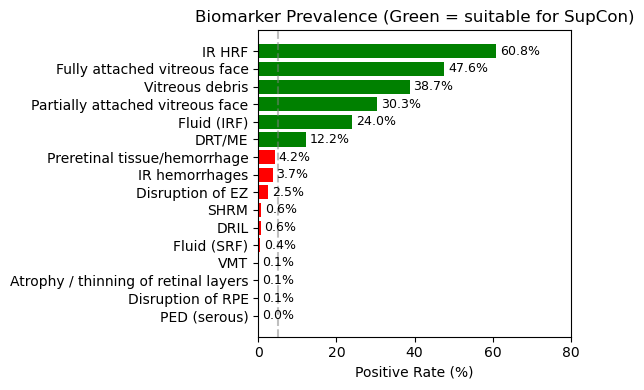

In [6]:
### 1) filter biomarkers with positive rate between 5% and 95%
ALL_BIOMARKER_COLS = [
    'Atrophy / thinning of retinal layers', 'Disruption of EZ', 'DRIL',
    'IR hemorrhages', 'IR HRF', 'Partially attached vitreous face',
    'Fully attached vitreous face', 'Preretinal tissue/hemorrhage',
    'Vitreous debris', 'VMT', 'DRT/ME', 'Fluid (IRF)', 'Fluid (SRF)',
    'Disruption of RPE', 'PED (serous)', 'SHRM'
]

# Calculate the positive rate for each biomarker
print('=== Biomarker Positive Rate Analysis ===')
print()
prevalence = {}
for col in ALL_BIOMARKER_COLS:
    pos_rate = biomarker_df[col].mean() * 100
    prevalence[col] = pos_rate


prevalence_sorted = dict(sorted(prevalence.items(), key=lambda x: x[1], reverse=True))


# Plot
plt.figure(figsize=(6, 4))
colors = ['green' if 5 <= v <= 95 else 'red' for v in prevalence_sorted.values()]
bars = plt.barh(list(prevalence_sorted.keys()), list(prevalence_sorted.values()), color=colors)


for bar, value in zip(bars, prevalence_sorted.values()):
    plt.text(
        bar.get_width() + 1,      # x position: slightly right of bar end
        bar.get_y() + bar.get_height()/2,  # y position: center of bar
        f'{value:.1f}%',          # text
        va='center',              # vertical alignment
        ha='left',                # horizontal alignment
        fontsize=9
    )

plt.axvline(x=5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=95, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Positive Rate (%)')
plt.title('Biomarker Prevalence (Green = suitable for SupCon)')
plt.xlim(0, 80)  # Adjust x-axis to make room for annotations
plt.gca().invert_yaxis()  # Highest value at top
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/biomarker_prevalence.png', dpi=150)
plt.show()

In [7]:
# Selected biomarkers for SupCon (prevalence 5-95%)
SELECTED_BIOMARKERS = [
    'IR HRF',                        
    'Fully attached vitreous face',  
    'Vitreous debris',               
    'Partially attached vitreous face',
    'Fluid (IRF)',                   
    'DRT/ME',                       
]

print(f'Selected {len(SELECTED_BIOMARKERS)} biomarkers for SupCon training')

Selected 6 biomarkers for SupCon training


In [8]:
# 2） Create combined biomarker labels
def create_biomarker_label(row, biomarker_cols):
    """Create a string label representing the combination of selected biomarkers."""
    return '_'.join([str(int(row[col])) for col in biomarker_cols])

biomarker_df['label_str'] = biomarker_df.apply(
    lambda row: create_biomarker_label(row, SELECTED_BIOMARKERS), axis=1
)

# Create label mappings(Pytorch Dataloader needs numeric labels)
# i.e. convert '1_0_0_1_0_1' --> 0, '0_1_0_0_1_0' --> 1, etc.(A category -> A number). So 6-dim biomarkers -> 1 categorical
label_counts = biomarker_df['label_str'].value_counts()
label_to_idx = {label: idx for idx, label in enumerate(label_counts.index)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

biomarker_df['label_idx'] = biomarker_df['label_str'].map(label_to_idx)

print(f'Created {len(label_to_idx)} unique biomarker combination labels')
print(f'\nTop 10 most common combinations:')
print(label_counts.head(10))

Created 48 unique biomarker combination labels

Top 10 most common combinations:
label_str
0_1_0_0_0_0    405
1_1_1_0_0_0    386
1_1_0_0_0_0    377
0_1_1_0_0_0    309
1_0_0_1_0_0    307
0_0_0_1_0_0    227
0_0_0_0_0_0    188
1_0_0_0_0_0    183
1_0_1_1_0_0    146
1_0_1_0_0_0    138
Name: count, dtype: int64


In [9]:
# Patient-level train/val split
patients = biomarker_df['Patient_ID_String'].unique()
train_patients, val_patients = train_test_split(
    patients, test_size=0.2, random_state=SEED
)

train_df = biomarker_df[biomarker_df['Patient_ID_String'].isin(train_patients)].copy()
val_df = biomarker_df[biomarker_df['Patient_ID_String'].isin(val_patients)].copy()

# Apply test mode sampling if enabled
if TEST_MODE:
    train_df = train_df.sample(n=min(TEST_SAMPLES, len(train_df)), random_state=SEED)
    val_df = val_df.sample(n=min(TEST_SAMPLES // 5, len(val_df)), random_state=SEED)
    print(f"TEST MODE: Using {len(train_df)} train and {len(val_df)} val samples")

print(f'\nTrain: {len(train_df)} samples from {len(train_patients)} patients')
print(f'Val: {len(val_df)} samples from {len(val_patients)} patients')


Train: 3136 samples from 32 patients
Val: 784 samples from 8 patients


---
## 3. Dataset and DataLoader

In [10]:
# Data augmentations
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # 轻微缩放裁剪
    transforms.RandomHorizontalFlip(p=0.5), # OCT 可以水平翻转
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), # 小角度旋转
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 标准化
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
class OCTSupConDataset(Dataset):
    """
    Dataset for Supervised Contrastive Learning on OCT images.
    Returns two augmented views of the same image.
    使用预处理好的 2_biomarker_processed.csv 中的路径信息。
    
    对于 SupCon，每个样本返回:
    - 两个不同增强的图像视图 (view1, view2), view1：模型从这个角度看这张 OCT, view2：模型从另一个角度看这张 OCT; 同一图像的 view1 和 view2, 一定是 positive pair; 不同图像但 label 相同, 也是 positive; label 不同, 则为 negative pair
    - biomarker 组合标签
    """
    
    def __init__(self, df, data_root, transform=None):
        """
        Args:
            df: DataFrame，包含 Patient_ID_String, Week, Eye, B_scan_number, label_idx 列
            data_root: OCT 图像根目录 (Prime_FULL 的路径)
            transform: 图像变换
            return_two_views: 是否返回两个增强视图 (SupCon 训练时为 True)
        """
        self.df = df.reset_index(drop=True)
        self.data_root = data_root
        self.transform = transform
        self.path_col = 'Path (Trial/Arm/Folder/Visit/Eye/Image Name)'
        
    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 直接使用 CSV 中的路径
        relative_path = row[self.path_col].lstrip('/')
        img_path = os.path.join(self.data_root, relative_path)
        
        # 处理扩展名：如果 .tif 不存在，尝试 .png
        if not os.path.exists(img_path):
            img_path = img_path.replace('.tif', '.png')
        
        image = Image.open(img_path).convert('RGB')
        label = row['label_idx']
        
        if self.transform:
            view1 = self.transform(image)
            view2 = self.transform(image)
            return view1, view2, label
        
        return image, image, label

class OCTValDataset(Dataset):
    """Validation dataset - returns single view without augmentation."""
    
    def __init__(self, df, data_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_root = data_root
        self.transform = transform
        self.path_col = 'Path (Trial/Arm/Folder/Visit/Eye/Image Name)'
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        relative_path = row[self.path_col].lstrip('/')
        img_path = os.path.join(self.data_root, relative_path)
        
        if not os.path.exists(img_path):
            img_path = img_path.replace('.tif', '.png')
        
        image = Image.open(img_path).convert('RGB')
        label = row['label_idx']

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [12]:
# Create datasets and dataloaders
train_dataset = OCTSupConDataset(train_df, DATA_ROOT, transform=train_transform)
val_dataset = OCTValDataset(val_df, DATA_ROOT, transform=val_transform)

# Intended to Use more workers for faster data loading, but Windows does not support it
num_workers =  0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True, 
    # prefetch_factor=4,          # Pre-fetch more data in advance to reduce latency
    # persistent_workers=True      # Keep workers alive between epochs for faster loading复用 worker 进程
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    # prefetch_factor=4,          
    # persistent_workers=True  
)

print(f'Train loader: {len(train_loader)} batches')
print(f'Val loader: {len(val_loader)} batches')

Train loader: 12 batches
Val loader: 4 batches


⏱️ 加载 batch 耗时: 2.01秒


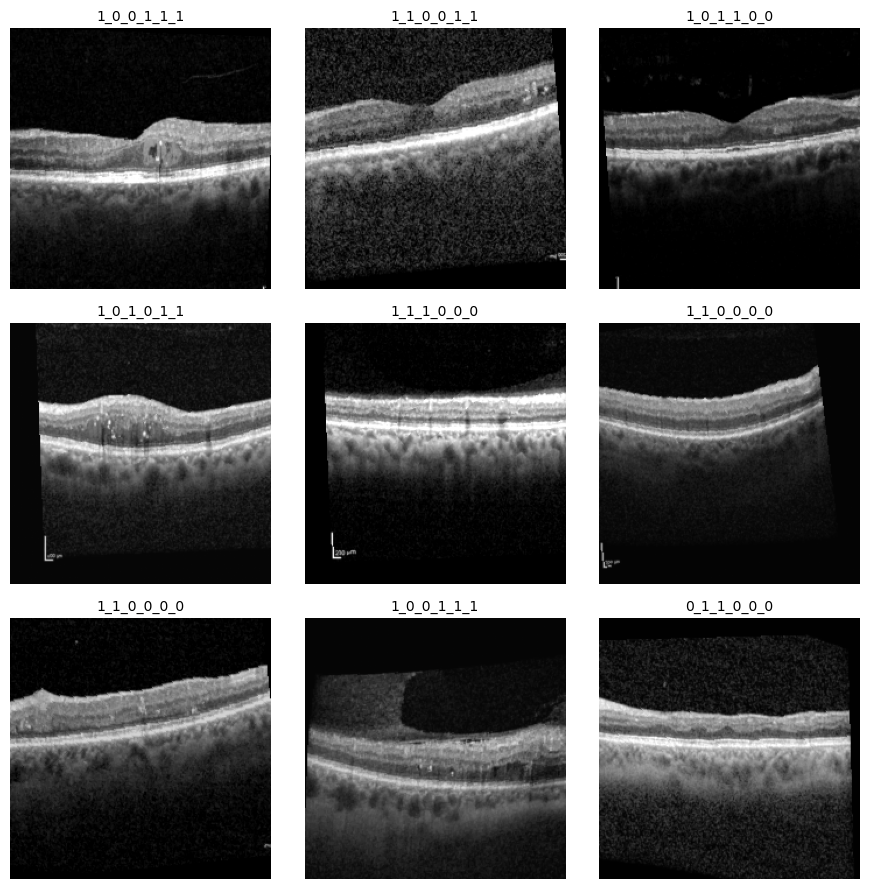

✓ 显示 9 张图像成功！总耗时: 2.81秒


In [13]:
# 可视化一个 batch 的数据
def show_batch(dataloader, n_samples=9):
    """显示一个 batch 的图像（优化版）"""
    try:
        import time
        start = time.time()
        
        # 获取一个 batch
        batch = next(iter(dataloader))
        print(f"⏱️ 加载 batch 耗时: {time.time()-start:.2f}秒")
        
        if len(batch) == 3:
            view1, view2, labels = batch
            images = view1
        else:
            images, labels = batch
        
        # 限制显示数量
        n_samples = min(n_samples, len(images))
        
        # 固定 3×3 布局
        n_cols = 3
        n_rows = 3
        
        # ⚡ 关键优化：立即移到 CPU
        images = images[:n_samples].cpu()  # ← 只取前 9 张，立即移到 CPU
        labels = labels[:n_samples].cpu()
        
        # 反标准化
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        images = images * std + mean
        images = torch.clamp(images, 0, 1)
        
        # 创建图表
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 9))
        axes = axes.flat
            
        for i, ax in enumerate(axes):
            if i < n_samples:
                img = images[i].permute(1, 2, 0).numpy()
                ax.imshow(img)
                label_str = idx_to_label.get(labels[i].item(), 'unknown')
                ax.set_title(f'{label_str}', fontsize=10)
            ax.axis('off')
            
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/sample_batch.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        total_time = time.time() - start
        print(f'✓ 显示 {n_samples} 张图像成功！总耗时: {total_time:.2f}秒')
        
    except Exception as e:
        print(f'❌ 无法显示图像: {e}')
        import traceback
        traceback.print_exc()

show_batch(train_loader)

---
## 4. Model Architecture

用 ImageNet 预训练的 ResNet-18 作为 OCT encoder，学习一个 256 维、语义稳定的表示；再通过一个独立的 projection head，把表示映射到一个更适合 Supervised Contrastive Learning 的对比空间，在该空间中施加 SupCon loss，而最终下游任务只使用 encoder 的输出。

In [14]:
class OCTEncoder(nn.Module):
    """OCT Encoder based on ResNet-18.输出: 256 维 embedding 向量"""
    
    def __init__(self, embedding_dim=256, pretrained=True):
        super(OCTEncoder, self).__init__()
        # 加载预训练的 ResNet-18
        if pretrained:
            self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            self.backbone = models.resnet18(weights=None)
        
        # 获取特征维度
        in_features = self.backbone.fc.in_features  # 512 for ResNet-18
        
        # 替换最后的全连接层为 embedding 层
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_dim)
        )
        
        self.embedding_dim = embedding_dim
        
    def forward(self, x):
        """
        Args:
            x: [B, 3, H, W] 输入图像
        Returns:
            embedding: [B, embedding_dim] 归一化的 embedding
        """
        embedding = self.backbone(x)
        embedding = F.normalize(embedding, p=2, dim=1) # L2 归一化 - 对于对比学习很重要
        return embedding


class ProjectionHead(nn.Module):
    """Projection head for contrastive learning.将 encoder 的输出投影到对比学习空间。"""
    
    def __init__(self, input_dim=256, hidden_dim=256, output_dim=128):
        super(ProjectionHead, self).__init__()
        
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        z = self.projection(x)
        z = F.normalize(z, p=2, dim=1)
        return z


class SupConModel(nn.Module):
    """Complete model for Supervised Contrastive Learning. 结构:Image → Encoder → Embedding → ProjectionHead → Contrastive Space"""
    
    def __init__(self, embedding_dim=256, projection_dim=128, pretrained=True):
        super(SupConModel, self).__init__()
        
        self.encoder = OCTEncoder(embedding_dim=embedding_dim, pretrained=pretrained)
        self.projection_head = ProjectionHead(
            input_dim=embedding_dim,
            hidden_dim=embedding_dim,
            output_dim=projection_dim
        )
        
    def forward(self, x):
        """
        Args:
            x: [B, 3, H, W]
        Returns:
            embedding: [B, embedding_dim] - 用于下游任务
            z: [B, projection_dim] - 用于对比学习
        """
        embedding = self.encoder(x)
        z = self.projection_head(embedding)
        return embedding, z
    
    def get_embedding(self, x):
        """Get embedding only (for downstream tasks)."""
        return self.encoder(x)

In [15]:
# Initialize model
model = SupConModel(
    embedding_dim=EMBEDDING_DIM,
    projection_dim=128,
    pretrained=True
).to(device)

print('The Model Info:\n', model)
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

The Model Info:
 SupConModel(
  (encoder): OCTEncoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

---
## 5. Supervised Contrastive Loss

In [16]:
class SupConLoss(nn.Module):
    """
    Supervised Contrastive Loss.
    
    参考: "Supervised Contrastive Learning" (Khosla et al., NeurIPS 2020)
    
    核心思想:
    - 相同标签的样本（正样本对）embedding 应该接近
    - 不同标签的样本（负样本对）embedding 应该远离
    """
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, features, labels):
        """
        Args:
            features: [2*B, D] - 两个视图的特征拼接
            labels: [B] - 样本标签
            
        Returns:
            loss: scalar
        """
        device = features.device
        batch_size = labels.shape[0]
        
        # Duplicate labels for two views复制标签 (因为有两个视图)
        labels = labels.contiguous().view(-1, 1)
        labels = torch.cat([labels, labels], dim=0)
        
        # Cosine similarity matrix
        similarity_matrix = torch.matmul(features, features.T)
        
        # Label mask 创建标签掩码: mask[i,j] = 1 if labels[i] == labels[j]
        mask = torch.eq(labels, labels.T).float().to(device)
        
        # Exclude self-contrast排除自身对比 (对角线)
        logits_mask = torch.ones_like(mask) - torch.eye(2 * batch_size).to(device)
        mask = mask * logits_mask
        
        # Calculate logits
        logits = similarity_matrix / self.temperature
        
        # Numerical stability 数值稳定性: 减去每行最大值
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()
        
        # 计算 log-softmax
        exp_logits = torch.exp(logits) * logits_mask# 排除自身
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        
        # Average log-prob of positive pairs 计算正样本对的平均 log-prob
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.where(mask_sum > 0, mask_sum, torch.ones_like(mask_sum)) # 避免除以0：只考虑有正样本对的锚点
        
        mean_log_prob_pos = (mask * log_prob).sum(dim=1) / mask_sum

        # loss
        loss = -mean_log_prob_pos.mean()
        
        return loss

criterion = SupConLoss(temperature=TEMPERATURE)
print(f"SupConLoss initialized with temperature={TEMPERATURE}")

SupConLoss initialized with temperature=0.07


---
## 6. Checkpointing System

In [17]:
CHECKPOINT_DIR #Windows 实际上两种分隔符都接受：/ 正斜杠 ✅； \\ 反斜杠 ✅

'./supcon_output\\checkpoints'

In [18]:
class CheckpointManager:
    """
    Manages checkpoints for training resumption.
    
    Features:
    - Periodic checkpoints (every N epochs)
    - Best model tracking
    - Automatic cleanup of old checkpoints
    - Complete state restoration (model, optimizer, scheduler, random states)
    """
    
    def __init__(self, checkpoint_dir, keep_last_n=5):
        self.checkpoint_dir = checkpoint_dir
        self.keep_last_n = keep_last_n
        os.makedirs(checkpoint_dir, exist_ok=True)
        
    def save_checkpoint(self, state, epoch, is_best=False, filename=None):
        """
        Save a checkpoint.
        
        Args:
            state: Dictionary containing training state
            epoch: Current epoch number
            is_best: Whether this is the best model so far
            filename: Custom filename (optional)
        """
        if filename is None:
            filename = f'checkpoint_epoch_{epoch:04d}.pth'
        
        filepath = os.path.join(self.checkpoint_dir, filename)
        
        # Add metadata
        state['checkpoint_time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        state['epoch'] = epoch
        
        torch.save(state, filepath)
        print(f"  ✓ Checkpoint saved: {filename}")
        
        # Save best model separately
        if is_best:
            best_path = os.path.join(self.checkpoint_dir, 'best_model.pth')
            torch.save(state, best_path)
            print(f"  ✓ Best model updated!")
        
        # Cleanup old checkpoints
        self._cleanup_old_checkpoints()
        
    def _cleanup_old_checkpoints(self):
        """Remove old checkpoints, keeping only the last N."""
        checkpoints = sorted([
            f for f in os.listdir(self.checkpoint_dir)
            if f.startswith('checkpoint_epoch_') and f.endswith('.pth')
        ])
        
        if len(checkpoints) > self.keep_last_n:
            for ckpt in checkpoints[:-self.keep_last_n]:
                os.remove(os.path.join(self.checkpoint_dir, ckpt))
                print(f"  Removed old checkpoint: {ckpt}")
    
    def load_latest_checkpoint(self):
        """Load the most recent checkpoint."""
        checkpoints = sorted([
            f for f in os.listdir(self.checkpoint_dir)
            if f.startswith('checkpoint_epoch_') and f.endswith('.pth')
        ])
        
        if not checkpoints:
            print("No checkpoints found. Starting from scratch.")
            return None
        
        latest = checkpoints[-1]
        filepath = os.path.join(self.checkpoint_dir, latest)
        print(f"Loading checkpoint: {latest}")
        
        return torch.load(filepath, map_location=device)
    
    def load_best_checkpoint(self):
        """Load the best model checkpoint."""
        best_path = os.path.join(self.checkpoint_dir, 'best_model.pth')
        
        if not os.path.exists(best_path):
            print("No best model checkpoint found.")
            return None
        
        print("Loading best model checkpoint...")
        return torch.load(best_path, map_location=device)


# Initialize checkpoint manager
checkpoint_manager = CheckpointManager(
    CHECKPOINT_DIR, 
    keep_last_n=KEEP_LAST_N_CHECKPOINTS
)
print(f"Checkpoint manager initialized. Checkpoints will be saved to: {CHECKPOINT_DIR}")

Checkpoint manager initialized. Checkpoints will be saved to: ./supcon_output\checkpoints


In [19]:
class TrainingLogger:
    """
    Logs training progress to CSV for monitoring and analysis.
    """
    
    def __init__(self, output_dir):
        self.log_path = os.path.join(output_dir, 'training_log.csv')
        self.logs = []
        
        # Load existing logs if resuming
        if os.path.exists(self.log_path):
            self.logs = pd.read_csv(self.log_path).to_dict('records')
            print(f"Loaded existing training log with {len(self.logs)} entries")
    
    def log(self, epoch, train_loss, val_loss=None, lr=None, best_loss=None):
        """Log training metrics."""
        entry = {
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'learning_rate': lr,
            'best_loss': best_loss,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        self.logs.append(entry)
        
        # Save to CSV
        pd.DataFrame(self.logs).to_csv(self.log_path, index=False)
    
    def get_history(self):
        """Get training history as DataFrame."""
        return pd.DataFrame(self.logs)


# Initialize logger
training_logger = TrainingLogger(OUTPUT_DIR)
print(f"Training logger initialized. Logs will be saved to: {OUTPUT_DIR}/training_log.csv")

Training logger initialized. Logs will be saved to: ./supcon_output/training_log.csv


---
## 7. Training Functions

In [20]:
# def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
#     """Train for one epoch."""
#     model.train()
#     total_loss = 0
#     num_batches = 0
    
#     pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
#     for view1, view2, labels in pbar:
#         view1 = view1.to(device)
#         view2 = view2.to(device)
#         labels = labels.to(device)
        
#         # Combine views
#         images = torch.cat([view1, view2], dim=0)
        
#         # Forward
#         _, z = model(images)
        
#         # Loss
#         loss = criterion(z, labels)
        
#         # Backward
#         optimizer.zero_grad()
#         loss.backward()
        
#         # Gradient clipping for stability
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
#         optimizer.step()
        
#         total_loss += loss.item()
#         num_batches += 1
        
#         pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
#     return total_loss / num_batches


# def validate(model, val_loader, criterion, device):
#     """Validate the model."""
#     model.eval()
#     total_loss = 0
#     num_batches = 0
    
#     all_embeddings = []
#     all_labels = []
    
#     with torch.no_grad():
#         for images, labels in tqdm(val_loader, desc='Validation'):
#             images = images.to(device)
#             labels = labels.to(device)
            
#             # Get embeddings
#             embedding = model.get_embedding(images)
            
#             all_embeddings.append(embedding.cpu())
#             all_labels.append(labels.cpu())
    
#     all_embeddings = torch.cat(all_embeddings, dim=0)
#     all_labels = torch.cat(all_labels, dim=0)
    
#     return all_embeddings, all_labels

In [21]:
# RTX 4090 的 Tensor Cores 专门优化了 FP16 计算
# 混合精度可以提速 2-3 倍且几乎不损失精度
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, scaler):  # ← 添加 scaler 参数
    """Train for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for view1, view2, labels in pbar:
        view1 = view1.to(device, non_blocking=True)      # ← 添加 non_blocking=True
        view2 = view2.to(device, non_blocking=True)      # ← 添加 non_blocking=True
        labels = labels.to(device, non_blocking=True)    # ← 添加 non_blocking=True
    
        # Combine views
        images = torch.cat([view1, view2], dim=0)
        
        # Forward with mixed precision
        with torch.cuda.amp.autocast():              # ← 新增这行
            _, z = model(images)
            loss = criterion(z, labels)
        
        # Backward with gradient scaling
        optimizer.zero_grad()
        scaler.scale(loss).backward()                # ← 修改这行
        scaler.unscale_(optimizer)                   # ← 新增这行
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)                       # ← 修改这行
        scaler.update()                              # ← 新增这行

        total_loss += loss.item()
        num_batches += 1
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / num_batches


def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images = images.to(device)
            labels = labels.to(device)
            
            # Get embeddings
            embedding = model.get_embedding(images)
            
            all_embeddings.append(embedding.cpu())
            all_labels.append(labels.cpu())
    
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_embeddings, all_labels


---
## 8. Training Loop with Checkpointing

In [22]:
# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY
)
# ← 新增: 初始化混合精度训练的 scaler
scaler = torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS, 
    eta_min=1e-6
)

# Training state
start_epoch = 0
best_loss = float('inf')
train_losses = []

# Resume from checkpoint if available
if RESUME_TRAINING:
    checkpoint = checkpoint_manager.load_latest_checkpoint()
    if checkpoint is not None:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_loss = checkpoint['best_loss']
        train_losses = checkpoint.get('train_losses', [])
        
        # Restore random states
        if 'random_states' in checkpoint:
            set_random_states(checkpoint['random_states'])
        
        print(f"\nResumed from epoch {start_epoch}")
        print(f"Best loss so far: {best_loss:.4f}")
        print(f"Previous training losses: {len(train_losses)} epochs")

print(f"\nStarting training from epoch {start_epoch + 1}")

No checkpoints found. Starting from scratch.

Starting training from epoch 1


In [23]:
# ============================================================
# Main Training Loop
# ============================================================

print('='*70)
print('SUPERVISED CONTRASTIVE LEARNING TRAINING')
print('='*70)
print(f'Start Time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Total Epochs: {NUM_EPOCHS}')
print(f'Starting Epoch: {start_epoch + 1}')
print('='*70)

try:
    for epoch in range(start_epoch, NUM_EPOCHS):
        epoch_start_time = datetime.now()
        current_lr = scheduler.get_last_lr()[0]
        
        print(f'\n{"="*70}')
        print(f'Epoch {epoch + 1}/{NUM_EPOCHS} | LR: {current_lr:.6f}')
        print(f'{"="*70}')
        
        # Train
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, scaler)  # ← 添加 scaler
        train_losses.append(train_loss)
        
        # Update scheduler
        scheduler.step()
        
        # Check if best model
        is_best = train_loss < best_loss
        if is_best:
            best_loss = train_loss
        
        # Log progress
        epoch_time = (datetime.now() - epoch_start_time).total_seconds() / 60
        print(f'\nEpoch {epoch + 1} Summary:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Best Loss: {best_loss:.4f}')
        print(f'  Time: {epoch_time:.2f} min')
        
        training_logger.log(
            epoch=epoch + 1,
            train_loss=train_loss,
            lr=current_lr,
            best_loss=best_loss
        )
        
        # Save checkpoint
        if (epoch + 1) % CHECKPOINT_EVERY == 0 or is_best or (epoch + 1) == NUM_EPOCHS:
            checkpoint_state = {
                'model_state_dict': model.state_dict(),
                'encoder_state_dict': model.encoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch,
                'train_loss': train_loss,
                'best_loss': best_loss,
                'train_losses': train_losses,
                'random_states': get_random_states(),
                'config': {
                    'batch_size': BATCH_SIZE,
                    'learning_rate': LEARNING_RATE,
                    'temperature': TEMPERATURE,
                    'embedding_dim': EMBEDDING_DIM,
                    'num_epochs': NUM_EPOCHS,
                }
            }
            checkpoint_manager.save_checkpoint(checkpoint_state, epoch + 1, is_best)
        
        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

except KeyboardInterrupt:
    print('\n\n' + '='*70)
    print('TRAINING INTERRUPTED!')
    print('Saving emergency checkpoint...')
    print('='*70)
    
    emergency_state = {
        'model_state_dict': model.state_dict(),
        'encoder_state_dict': model.encoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch,
        'train_loss': train_loss if 'train_loss' in dir() else None,
        'best_loss': best_loss,
        'train_losses': train_losses,
        'random_states': get_random_states(),
        'interrupted': True
    }
    checkpoint_manager.save_checkpoint(
        emergency_state, 
        epoch + 1, 
        filename='checkpoint_interrupted.pth'
    )
    print('Emergency checkpoint saved. You can resume training later.')

except Exception as e:
    print(f'\n\nERROR: {str(e)}')
    print('Saving error checkpoint...')
    
    error_state = {
        'model_state_dict': model.state_dict(),
        'encoder_state_dict': model.encoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch if 'epoch' in dir() else 0,
        'best_loss': best_loss,
        'train_losses': train_losses,
        'error': str(e)
    }
    checkpoint_manager.save_checkpoint(
        error_state, 
        epoch + 1 if 'epoch' in dir() else 0, 
        filename='checkpoint_error.pth'
    )
    raise

print('\n' + '='*70)
print('TRAINING COMPLETE!')
print(f'End Time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Best Loss: {best_loss:.4f}')
print('='*70)

SUPERVISED CONTRASTIVE LEARNING TRAINING
Start Time: 2025-12-15 21:40:04
Total Epochs: 1000
Starting Epoch: 1

Epoch 1/1000 | LR: 0.001000


Epoch 0: 100%|██████████| 12/12 [00:19<00:00,  1.62s/it, loss=5.9012]



Epoch 1 Summary:
  Train Loss: 6.0856
  Best Loss: 6.0856
  Time: 0.32 min
  ✓ Checkpoint saved: checkpoint_epoch_0001.pth
  ✓ Best model updated!

Epoch 2/1000 | LR: 0.001000


Epoch 1: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=5.6820]



Epoch 2 Summary:
  Train Loss: 5.7612
  Best Loss: 5.7612
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0002.pth
  ✓ Best model updated!

Epoch 3/1000 | LR: 0.001000


Epoch 2: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=5.5099]



Epoch 3 Summary:
  Train Loss: 5.5920
  Best Loss: 5.5920
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0003.pth
  ✓ Best model updated!

Epoch 4/1000 | LR: 0.001000


Epoch 3: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=5.3199]



Epoch 4 Summary:
  Train Loss: 5.4345
  Best Loss: 5.4345
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0004.pth
  ✓ Best model updated!

Epoch 5/1000 | LR: 0.001000


Epoch 4: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=5.2433]



Epoch 5 Summary:
  Train Loss: 5.2748
  Best Loss: 5.2748
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0005.pth
  ✓ Best model updated!

Epoch 6/1000 | LR: 0.001000


Epoch 5: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it, loss=5.2531]



Epoch 6 Summary:
  Train Loss: 5.1680
  Best Loss: 5.1680
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0006.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0001.pth

Epoch 7/1000 | LR: 0.001000


Epoch 6: 100%|██████████| 12/12 [00:17<00:00,  1.49s/it, loss=4.9874]



Epoch 7 Summary:
  Train Loss: 5.1047
  Best Loss: 5.1047
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0007.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0002.pth

Epoch 8/1000 | LR: 0.001000


Epoch 7: 100%|██████████| 12/12 [00:17<00:00,  1.49s/it, loss=4.9345]



Epoch 8 Summary:
  Train Loss: 5.0141
  Best Loss: 5.0141
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0008.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0003.pth

Epoch 9/1000 | LR: 0.001000


Epoch 8: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it, loss=4.9598]



Epoch 9 Summary:
  Train Loss: 4.9360
  Best Loss: 4.9360
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0009.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0004.pth

Epoch 10/1000 | LR: 0.001000


Epoch 9: 100%|██████████| 12/12 [00:17<00:00,  1.49s/it, loss=4.8237]



Epoch 10 Summary:
  Train Loss: 4.8763
  Best Loss: 4.8763
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0010.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0005.pth

Epoch 11/1000 | LR: 0.001000


Epoch 10: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it, loss=4.9301]



Epoch 11 Summary:
  Train Loss: 4.8068
  Best Loss: 4.8068
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0011.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0006.pth

Epoch 12/1000 | LR: 0.001000


Epoch 11: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it, loss=4.7261]



Epoch 12 Summary:
  Train Loss: 4.7336
  Best Loss: 4.7336
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0012.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0007.pth

Epoch 13/1000 | LR: 0.001000


Epoch 12: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it, loss=4.9014]



Epoch 13 Summary:
  Train Loss: 4.6889
  Best Loss: 4.6889
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0013.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0008.pth

Epoch 14/1000 | LR: 0.001000


Epoch 13: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it, loss=4.6865]



Epoch 14 Summary:
  Train Loss: 4.6867
  Best Loss: 4.6867
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0014.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0009.pth

Epoch 15/1000 | LR: 0.001000


Epoch 14: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=4.7854]



Epoch 15 Summary:
  Train Loss: 4.6741
  Best Loss: 4.6741
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0015.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0010.pth

Epoch 16/1000 | LR: 0.000999


Epoch 15: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it, loss=4.7057]



Epoch 16 Summary:
  Train Loss: 4.6532
  Best Loss: 4.6532
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0016.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0011.pth

Epoch 17/1000 | LR: 0.000999


Epoch 16: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=4.6536]



Epoch 17 Summary:
  Train Loss: 4.6021
  Best Loss: 4.6021
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0017.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0012.pth

Epoch 18/1000 | LR: 0.000999


Epoch 17: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=4.5765]



Epoch 18 Summary:
  Train Loss: 4.5615
  Best Loss: 4.5615
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0018.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0013.pth

Epoch 19/1000 | LR: 0.000999


Epoch 18: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=4.4657]



Epoch 19 Summary:
  Train Loss: 4.5318
  Best Loss: 4.5318
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0019.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0014.pth

Epoch 20/1000 | LR: 0.000999


Epoch 19: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=4.6122]



Epoch 20 Summary:
  Train Loss: 4.4993
  Best Loss: 4.4993
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0020.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0015.pth

Epoch 21/1000 | LR: 0.000999


Epoch 20: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=4.3041]



Epoch 21 Summary:
  Train Loss: 4.4714
  Best Loss: 4.4714
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0021.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0016.pth

Epoch 22/1000 | LR: 0.000999


Epoch 21: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=4.6149]



Epoch 22 Summary:
  Train Loss: 4.4290
  Best Loss: 4.4290
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0022.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0017.pth

Epoch 23/1000 | LR: 0.000999


Epoch 22: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=4.3962]



Epoch 23 Summary:
  Train Loss: 4.4305
  Best Loss: 4.4290
  Time: 0.30 min

Epoch 24/1000 | LR: 0.000999


Epoch 23: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.4311]



Epoch 24 Summary:
  Train Loss: 4.4212
  Best Loss: 4.4212
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0024.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0018.pth

Epoch 25/1000 | LR: 0.000999


Epoch 24: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.2187]



Epoch 25 Summary:
  Train Loss: 4.3882
  Best Loss: 4.3882
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0025.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0019.pth

Epoch 26/1000 | LR: 0.000998


Epoch 25: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=4.3647]



Epoch 26 Summary:
  Train Loss: 4.3531
  Best Loss: 4.3531
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0026.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0020.pth

Epoch 27/1000 | LR: 0.000998


Epoch 26: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.4330]



Epoch 27 Summary:
  Train Loss: 4.3279
  Best Loss: 4.3279
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0027.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0021.pth

Epoch 28/1000 | LR: 0.000998


Epoch 27: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.2694]



Epoch 28 Summary:
  Train Loss: 4.2972
  Best Loss: 4.2972
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0028.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0022.pth

Epoch 29/1000 | LR: 0.000998


Epoch 28: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.3620]



Epoch 29 Summary:
  Train Loss: 4.2786
  Best Loss: 4.2786
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0029.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0024.pth

Epoch 30/1000 | LR: 0.000998


Epoch 29: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=4.2804]



Epoch 30 Summary:
  Train Loss: 4.2616
  Best Loss: 4.2616
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0030.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0025.pth

Epoch 31/1000 | LR: 0.000998


Epoch 30: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.2497]



Epoch 31 Summary:
  Train Loss: 4.2445
  Best Loss: 4.2445
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0031.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0026.pth

Epoch 32/1000 | LR: 0.000998


Epoch 31: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=4.3262]



Epoch 32 Summary:
  Train Loss: 4.2813
  Best Loss: 4.2445
  Time: 0.31 min

Epoch 33/1000 | LR: 0.000997


Epoch 32: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.2000]



Epoch 33 Summary:
  Train Loss: 4.2164
  Best Loss: 4.2164
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0033.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0027.pth

Epoch 34/1000 | LR: 0.000997


Epoch 33: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.2950]



Epoch 34 Summary:
  Train Loss: 4.2056
  Best Loss: 4.2056
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0034.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0028.pth

Epoch 35/1000 | LR: 0.000997


Epoch 34: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=4.2718]



Epoch 35 Summary:
  Train Loss: 4.1851
  Best Loss: 4.1851
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0035.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0029.pth

Epoch 36/1000 | LR: 0.000997


Epoch 35: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.1979]



Epoch 36 Summary:
  Train Loss: 4.1517
  Best Loss: 4.1517
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0036.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0030.pth

Epoch 37/1000 | LR: 0.000997


Epoch 36: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=4.2027]



Epoch 37 Summary:
  Train Loss: 4.1353
  Best Loss: 4.1353
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0037.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0031.pth

Epoch 38/1000 | LR: 0.000997


Epoch 37: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=4.1363]



Epoch 38 Summary:
  Train Loss: 4.1289
  Best Loss: 4.1289
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0038.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0033.pth

Epoch 39/1000 | LR: 0.000996


Epoch 38: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=4.2178]



Epoch 39 Summary:
  Train Loss: 4.0947
  Best Loss: 4.0947
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0039.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0034.pth

Epoch 40/1000 | LR: 0.000996


Epoch 39: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.1108]



Epoch 40 Summary:
  Train Loss: 4.0936
  Best Loss: 4.0936
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0040.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0035.pth

Epoch 41/1000 | LR: 0.000996


Epoch 40: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.0958]



Epoch 41 Summary:
  Train Loss: 4.0788
  Best Loss: 4.0788
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0041.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0036.pth

Epoch 42/1000 | LR: 0.000996


Epoch 41: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=4.0018]



Epoch 42 Summary:
  Train Loss: 4.0388
  Best Loss: 4.0388
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0042.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0037.pth

Epoch 43/1000 | LR: 0.000996


Epoch 42: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.0077]



Epoch 43 Summary:
  Train Loss: 4.0414
  Best Loss: 4.0388
  Time: 0.30 min

Epoch 44/1000 | LR: 0.000995


Epoch 43: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.0881]



Epoch 44 Summary:
  Train Loss: 4.0202
  Best Loss: 4.0202
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0044.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0038.pth

Epoch 45/1000 | LR: 0.000995


Epoch 44: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=4.0751]



Epoch 45 Summary:
  Train Loss: 3.9741
  Best Loss: 3.9741
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0045.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0039.pth

Epoch 46/1000 | LR: 0.000995


Epoch 45: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.9415]



Epoch 46 Summary:
  Train Loss: 3.9399
  Best Loss: 3.9399
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0046.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0040.pth

Epoch 47/1000 | LR: 0.000995


Epoch 46: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=4.0605]



Epoch 47 Summary:
  Train Loss: 3.9605
  Best Loss: 3.9399
  Time: 0.31 min

Epoch 48/1000 | LR: 0.000995


Epoch 47: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.8711]



Epoch 48 Summary:
  Train Loss: 3.9094
  Best Loss: 3.9094
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0048.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0041.pth

Epoch 49/1000 | LR: 0.000994


Epoch 48: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.9443]



Epoch 49 Summary:
  Train Loss: 3.9100
  Best Loss: 3.9094
  Time: 0.30 min

Epoch 50/1000 | LR: 0.000994


Epoch 49: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.7949]



Epoch 50 Summary:
  Train Loss: 3.8990
  Best Loss: 3.8990
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0050.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0042.pth

Epoch 51/1000 | LR: 0.000994


Epoch 50: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.8757]



Epoch 51 Summary:
  Train Loss: 3.8912
  Best Loss: 3.8912
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0051.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0044.pth

Epoch 52/1000 | LR: 0.000994


Epoch 51: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.9495]



Epoch 52 Summary:
  Train Loss: 3.8808
  Best Loss: 3.8808
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0052.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0045.pth

Epoch 53/1000 | LR: 0.000993


Epoch 52: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.8481]



Epoch 53 Summary:
  Train Loss: 3.8584
  Best Loss: 3.8584
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0053.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0046.pth

Epoch 54/1000 | LR: 0.000993


Epoch 53: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.8895]



Epoch 54 Summary:
  Train Loss: 3.8333
  Best Loss: 3.8333
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0054.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0048.pth

Epoch 55/1000 | LR: 0.000993


Epoch 54: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.8225]



Epoch 55 Summary:
  Train Loss: 3.8249
  Best Loss: 3.8249
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0055.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0050.pth

Epoch 56/1000 | LR: 0.000993


Epoch 55: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.7635]



Epoch 56 Summary:
  Train Loss: 3.7962
  Best Loss: 3.7962
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0056.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0051.pth

Epoch 57/1000 | LR: 0.000992


Epoch 56: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.6988]



Epoch 57 Summary:
  Train Loss: 3.7883
  Best Loss: 3.7883
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0057.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0052.pth

Epoch 58/1000 | LR: 0.000992


Epoch 57: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.7644]



Epoch 58 Summary:
  Train Loss: 3.8002
  Best Loss: 3.7883
  Time: 0.30 min

Epoch 59/1000 | LR: 0.000992


Epoch 58: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.7127]



Epoch 59 Summary:
  Train Loss: 3.7472
  Best Loss: 3.7472
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0059.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0053.pth

Epoch 60/1000 | LR: 0.000991


Epoch 59: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.6721]



Epoch 60 Summary:
  Train Loss: 3.7502
  Best Loss: 3.7472
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0060.pth
  Removed old checkpoint: checkpoint_epoch_0054.pth

Epoch 61/1000 | LR: 0.000991


Epoch 60: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.7799]



Epoch 61 Summary:
  Train Loss: 3.7523
  Best Loss: 3.7472
  Time: 0.30 min

Epoch 62/1000 | LR: 0.000991


Epoch 61: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.9616]



Epoch 62 Summary:
  Train Loss: 3.7243
  Best Loss: 3.7243
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0062.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0055.pth

Epoch 63/1000 | LR: 0.000991


Epoch 62: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.7826]



Epoch 63 Summary:
  Train Loss: 3.7241
  Best Loss: 3.7241
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0063.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0056.pth

Epoch 64/1000 | LR: 0.000990


Epoch 63: 100%|██████████| 12/12 [00:21<00:00,  1.83s/it, loss=3.7879]



Epoch 64 Summary:
  Train Loss: 3.7251
  Best Loss: 3.7241
  Time: 0.37 min

Epoch 65/1000 | LR: 0.000990


Epoch 64: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it, loss=3.6674]



Epoch 65 Summary:
  Train Loss: 3.6672
  Best Loss: 3.6672
  Time: 0.54 min
  ✓ Checkpoint saved: checkpoint_epoch_0065.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0057.pth

Epoch 66/1000 | LR: 0.000990


Epoch 65: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.7336]



Epoch 66 Summary:
  Train Loss: 3.6691
  Best Loss: 3.6672
  Time: 0.31 min

Epoch 67/1000 | LR: 0.000989


Epoch 66: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.8040]



Epoch 67 Summary:
  Train Loss: 3.6462
  Best Loss: 3.6462
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0067.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0059.pth

Epoch 68/1000 | LR: 0.000989


Epoch 67: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.6872]



Epoch 68 Summary:
  Train Loss: 3.6665
  Best Loss: 3.6462
  Time: 0.30 min

Epoch 69/1000 | LR: 0.000989


Epoch 68: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.5889]



Epoch 69 Summary:
  Train Loss: 3.6262
  Best Loss: 3.6262
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0069.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0060.pth

Epoch 70/1000 | LR: 0.000988


Epoch 69: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.5893]



Epoch 70 Summary:
  Train Loss: 3.6286
  Best Loss: 3.6262
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0070.pth
  Removed old checkpoint: checkpoint_epoch_0062.pth

Epoch 71/1000 | LR: 0.000988


Epoch 70: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.6269]



Epoch 71 Summary:
  Train Loss: 3.6281
  Best Loss: 3.6262
  Time: 0.30 min

Epoch 72/1000 | LR: 0.000988


Epoch 71: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.5819]



Epoch 72 Summary:
  Train Loss: 3.5596
  Best Loss: 3.5596
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0072.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0063.pth

Epoch 73/1000 | LR: 0.000987


Epoch 72: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.5638]



Epoch 73 Summary:
  Train Loss: 3.5512
  Best Loss: 3.5512
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0073.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0065.pth

Epoch 74/1000 | LR: 0.000987


Epoch 73: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.5310]



Epoch 74 Summary:
  Train Loss: 3.5513
  Best Loss: 3.5512
  Time: 0.31 min

Epoch 75/1000 | LR: 0.000987


Epoch 74: 100%|██████████| 12/12 [00:18<00:00,  1.58s/it, loss=3.5618]



Epoch 75 Summary:
  Train Loss: 3.5796
  Best Loss: 3.5512
  Time: 0.32 min

Epoch 76/1000 | LR: 0.000986


Epoch 75: 100%|██████████| 12/12 [00:18<00:00,  1.57s/it, loss=3.5417]



Epoch 76 Summary:
  Train Loss: 3.5895
  Best Loss: 3.5512
  Time: 0.31 min

Epoch 77/1000 | LR: 0.000986


Epoch 76: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.5493]



Epoch 77 Summary:
  Train Loss: 3.5099
  Best Loss: 3.5099
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0077.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0067.pth

Epoch 78/1000 | LR: 0.000985


Epoch 77: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it, loss=3.5251]



Epoch 78 Summary:
  Train Loss: 3.5456
  Best Loss: 3.5099
  Time: 0.31 min

Epoch 79/1000 | LR: 0.000985


Epoch 78: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.5908]



Epoch 79 Summary:
  Train Loss: 3.5657
  Best Loss: 3.5099
  Time: 0.31 min

Epoch 80/1000 | LR: 0.000985


Epoch 79: 100%|██████████| 12/12 [00:20<00:00,  1.71s/it, loss=3.6007]



Epoch 80 Summary:
  Train Loss: 3.5638
  Best Loss: 3.5099
  Time: 0.34 min
  ✓ Checkpoint saved: checkpoint_epoch_0080.pth
  Removed old checkpoint: checkpoint_epoch_0069.pth

Epoch 81/1000 | LR: 0.000984


Epoch 80: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.6098]



Epoch 81 Summary:
  Train Loss: 3.5271
  Best Loss: 3.5099
  Time: 0.31 min

Epoch 82/1000 | LR: 0.000984


Epoch 81: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.4393]



Epoch 82 Summary:
  Train Loss: 3.4951
  Best Loss: 3.4951
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0082.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0070.pth

Epoch 83/1000 | LR: 0.000984


Epoch 82: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.6680]



Epoch 83 Summary:
  Train Loss: 3.5205
  Best Loss: 3.4951
  Time: 0.31 min

Epoch 84/1000 | LR: 0.000983


Epoch 83: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.4787]



Epoch 84 Summary:
  Train Loss: 3.4673
  Best Loss: 3.4673
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0084.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0072.pth

Epoch 85/1000 | LR: 0.000983


Epoch 84: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.5268]



Epoch 85 Summary:
  Train Loss: 3.5138
  Best Loss: 3.4673
  Time: 0.30 min

Epoch 86/1000 | LR: 0.000982


Epoch 85: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.4742]



Epoch 86 Summary:
  Train Loss: 3.4987
  Best Loss: 3.4673
  Time: 0.30 min

Epoch 87/1000 | LR: 0.000982


Epoch 86: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.6207]



Epoch 87 Summary:
  Train Loss: 3.5075
  Best Loss: 3.4673
  Time: 0.30 min

Epoch 88/1000 | LR: 0.000981


Epoch 87: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4112]



Epoch 88 Summary:
  Train Loss: 3.4693
  Best Loss: 3.4673
  Time: 0.30 min

Epoch 89/1000 | LR: 0.000981


Epoch 88: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4531]



Epoch 89 Summary:
  Train Loss: 3.5007
  Best Loss: 3.4673
  Time: 0.30 min

Epoch 90/1000 | LR: 0.000981


Epoch 89: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.4670]



Epoch 90 Summary:
  Train Loss: 3.4406
  Best Loss: 3.4406
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0090.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0073.pth

Epoch 91/1000 | LR: 0.000980


Epoch 90: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4890]



Epoch 91 Summary:
  Train Loss: 3.4557
  Best Loss: 3.4406
  Time: 0.30 min

Epoch 92/1000 | LR: 0.000980


Epoch 91: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4538]



Epoch 92 Summary:
  Train Loss: 3.5013
  Best Loss: 3.4406
  Time: 0.30 min

Epoch 93/1000 | LR: 0.000979


Epoch 92: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.5394]



Epoch 93 Summary:
  Train Loss: 3.4937
  Best Loss: 3.4406
  Time: 0.30 min

Epoch 94/1000 | LR: 0.000979


Epoch 93: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.4734]



Epoch 94 Summary:
  Train Loss: 3.4593
  Best Loss: 3.4406
  Time: 0.30 min

Epoch 95/1000 | LR: 0.000978


Epoch 94: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3812]



Epoch 95 Summary:
  Train Loss: 3.4227
  Best Loss: 3.4227
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0095.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0077.pth

Epoch 96/1000 | LR: 0.000978


Epoch 95: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4570]



Epoch 96 Summary:
  Train Loss: 3.4317
  Best Loss: 3.4227
  Time: 0.31 min

Epoch 97/1000 | LR: 0.000977


Epoch 96: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.5179]



Epoch 97 Summary:
  Train Loss: 3.4441
  Best Loss: 3.4227
  Time: 0.30 min

Epoch 98/1000 | LR: 0.000977


Epoch 97: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.4624]



Epoch 98 Summary:
  Train Loss: 3.3872
  Best Loss: 3.3872
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0098.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0080.pth

Epoch 99/1000 | LR: 0.000977


Epoch 98: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4679]



Epoch 99 Summary:
  Train Loss: 3.4236
  Best Loss: 3.3872
  Time: 0.30 min

Epoch 100/1000 | LR: 0.000976


Epoch 99: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3736]



Epoch 100 Summary:
  Train Loss: 3.3745
  Best Loss: 3.3745
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0100.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0082.pth

Epoch 101/1000 | LR: 0.000976


Epoch 100: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4284]



Epoch 101 Summary:
  Train Loss: 3.4121
  Best Loss: 3.3745
  Time: 0.30 min

Epoch 102/1000 | LR: 0.000975


Epoch 101: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.5101]



Epoch 102 Summary:
  Train Loss: 3.4087
  Best Loss: 3.3745
  Time: 0.30 min

Epoch 103/1000 | LR: 0.000975


Epoch 102: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.4281]



Epoch 103 Summary:
  Train Loss: 3.3786
  Best Loss: 3.3745
  Time: 0.30 min

Epoch 104/1000 | LR: 0.000974


Epoch 103: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3168]



Epoch 104 Summary:
  Train Loss: 3.3795
  Best Loss: 3.3745
  Time: 0.30 min

Epoch 105/1000 | LR: 0.000974


Epoch 104: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3675]



Epoch 105 Summary:
  Train Loss: 3.3617
  Best Loss: 3.3617
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0105.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0084.pth

Epoch 106/1000 | LR: 0.000973


Epoch 105: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4504]



Epoch 106 Summary:
  Train Loss: 3.3962
  Best Loss: 3.3617
  Time: 0.30 min

Epoch 107/1000 | LR: 0.000973


Epoch 106: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.3888]



Epoch 107 Summary:
  Train Loss: 3.3763
  Best Loss: 3.3617
  Time: 0.31 min

Epoch 108/1000 | LR: 0.000972


Epoch 107: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4735]



Epoch 108 Summary:
  Train Loss: 3.3883
  Best Loss: 3.3617
  Time: 0.30 min

Epoch 109/1000 | LR: 0.000972


Epoch 108: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.4242]



Epoch 109 Summary:
  Train Loss: 3.4040
  Best Loss: 3.3617
  Time: 0.30 min

Epoch 110/1000 | LR: 0.000971


Epoch 109: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.5053]



Epoch 110 Summary:
  Train Loss: 3.4017
  Best Loss: 3.3617
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0110.pth
  Removed old checkpoint: checkpoint_epoch_0090.pth

Epoch 111/1000 | LR: 0.000970


Epoch 110: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4635]



Epoch 111 Summary:
  Train Loss: 3.3817
  Best Loss: 3.3617
  Time: 0.30 min

Epoch 112/1000 | LR: 0.000970


Epoch 111: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.5530]



Epoch 112 Summary:
  Train Loss: 3.3680
  Best Loss: 3.3617
  Time: 0.30 min

Epoch 113/1000 | LR: 0.000969


Epoch 112: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.4124]



Epoch 113 Summary:
  Train Loss: 3.3415
  Best Loss: 3.3415
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0113.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0095.pth

Epoch 114/1000 | LR: 0.000969


Epoch 113: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2728]



Epoch 114 Summary:
  Train Loss: 3.3417
  Best Loss: 3.3415
  Time: 0.30 min

Epoch 115/1000 | LR: 0.000968


Epoch 114: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4104]



Epoch 115 Summary:
  Train Loss: 3.3597
  Best Loss: 3.3415
  Time: 0.30 min

Epoch 116/1000 | LR: 0.000968


Epoch 115: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4550]



Epoch 116 Summary:
  Train Loss: 3.3687
  Best Loss: 3.3415
  Time: 0.30 min

Epoch 117/1000 | LR: 0.000967


Epoch 116: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3417]



Epoch 117 Summary:
  Train Loss: 3.3397
  Best Loss: 3.3397
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0117.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0098.pth

Epoch 118/1000 | LR: 0.000967


Epoch 117: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3578]



Epoch 118 Summary:
  Train Loss: 3.3543
  Best Loss: 3.3397
  Time: 0.30 min

Epoch 119/1000 | LR: 0.000966


Epoch 118: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4689]



Epoch 119 Summary:
  Train Loss: 3.3627
  Best Loss: 3.3397
  Time: 0.30 min

Epoch 120/1000 | LR: 0.000965


Epoch 119: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3497]



Epoch 120 Summary:
  Train Loss: 3.3311
  Best Loss: 3.3311
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0120.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0100.pth

Epoch 121/1000 | LR: 0.000965


Epoch 120: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1956]



Epoch 121 Summary:
  Train Loss: 3.3268
  Best Loss: 3.3268
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0121.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0105.pth

Epoch 122/1000 | LR: 0.000964


Epoch 121: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3182]



Epoch 122 Summary:
  Train Loss: 3.3384
  Best Loss: 3.3268
  Time: 0.30 min

Epoch 123/1000 | LR: 0.000964


Epoch 122: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3980]



Epoch 123 Summary:
  Train Loss: 3.3795
  Best Loss: 3.3268
  Time: 0.30 min

Epoch 124/1000 | LR: 0.000963


Epoch 123: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3959]



Epoch 124 Summary:
  Train Loss: 3.3444
  Best Loss: 3.3268
  Time: 0.30 min

Epoch 125/1000 | LR: 0.000963


Epoch 124: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3793]



Epoch 125 Summary:
  Train Loss: 3.3342
  Best Loss: 3.3268
  Time: 0.30 min

Epoch 126/1000 | LR: 0.000962


Epoch 125: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3221]



Epoch 126 Summary:
  Train Loss: 3.3221
  Best Loss: 3.3221
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0126.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0110.pth

Epoch 127/1000 | LR: 0.000961


Epoch 126: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3241]



Epoch 127 Summary:
  Train Loss: 3.3273
  Best Loss: 3.3221
  Time: 0.30 min

Epoch 128/1000 | LR: 0.000961


Epoch 127: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.2977]



Epoch 128 Summary:
  Train Loss: 3.3175
  Best Loss: 3.3175
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0128.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0113.pth

Epoch 129/1000 | LR: 0.000960


Epoch 128: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.4611]



Epoch 129 Summary:
  Train Loss: 3.3379
  Best Loss: 3.3175
  Time: 0.30 min

Epoch 130/1000 | LR: 0.000960


Epoch 129: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3110]



Epoch 130 Summary:
  Train Loss: 3.3469
  Best Loss: 3.3175
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0130.pth
  Removed old checkpoint: checkpoint_epoch_0117.pth

Epoch 131/1000 | LR: 0.000959


Epoch 130: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2887]



Epoch 131 Summary:
  Train Loss: 3.2947
  Best Loss: 3.2947
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0131.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0120.pth

Epoch 132/1000 | LR: 0.000958


Epoch 131: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3675]



Epoch 132 Summary:
  Train Loss: 3.3186
  Best Loss: 3.2947
  Time: 0.30 min

Epoch 133/1000 | LR: 0.000958


Epoch 132: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.4343]



Epoch 133 Summary:
  Train Loss: 3.3076
  Best Loss: 3.2947
  Time: 0.30 min

Epoch 134/1000 | LR: 0.000957


Epoch 133: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2716]



Epoch 134 Summary:
  Train Loss: 3.2916
  Best Loss: 3.2916
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0134.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0121.pth

Epoch 135/1000 | LR: 0.000956


Epoch 134: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.2675]



Epoch 135 Summary:
  Train Loss: 3.3022
  Best Loss: 3.2916
  Time: 0.30 min

Epoch 136/1000 | LR: 0.000956


Epoch 135: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.4920]



Epoch 136 Summary:
  Train Loss: 3.3172
  Best Loss: 3.2916
  Time: 0.30 min

Epoch 137/1000 | LR: 0.000955


Epoch 136: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.3241]



Epoch 137 Summary:
  Train Loss: 3.2923
  Best Loss: 3.2916
  Time: 0.30 min

Epoch 138/1000 | LR: 0.000954


Epoch 137: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.2934]



Epoch 138 Summary:
  Train Loss: 3.3239
  Best Loss: 3.2916
  Time: 0.30 min

Epoch 139/1000 | LR: 0.000954


Epoch 138: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.3293]



Epoch 139 Summary:
  Train Loss: 3.2800
  Best Loss: 3.2800
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0139.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0126.pth

Epoch 140/1000 | LR: 0.000953


Epoch 139: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2966]



Epoch 140 Summary:
  Train Loss: 3.2959
  Best Loss: 3.2800
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0140.pth
  Removed old checkpoint: checkpoint_epoch_0128.pth

Epoch 141/1000 | LR: 0.000952


Epoch 140: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2736]



Epoch 141 Summary:
  Train Loss: 3.3004
  Best Loss: 3.2800
  Time: 0.30 min

Epoch 142/1000 | LR: 0.000952


Epoch 141: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3121]



Epoch 142 Summary:
  Train Loss: 3.3040
  Best Loss: 3.2800
  Time: 0.30 min

Epoch 143/1000 | LR: 0.000951


Epoch 142: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3020]



Epoch 143 Summary:
  Train Loss: 3.2816
  Best Loss: 3.2800
  Time: 0.30 min

Epoch 144/1000 | LR: 0.000950


Epoch 143: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2472]



Epoch 144 Summary:
  Train Loss: 3.2628
  Best Loss: 3.2628
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0144.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0130.pth

Epoch 145/1000 | LR: 0.000950


Epoch 144: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3400]



Epoch 145 Summary:
  Train Loss: 3.2945
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 146/1000 | LR: 0.000949


Epoch 145: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.4038]



Epoch 146 Summary:
  Train Loss: 3.3211
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 147/1000 | LR: 0.000948


Epoch 146: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3933]



Epoch 147 Summary:
  Train Loss: 3.2820
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 148/1000 | LR: 0.000948


Epoch 147: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3172]



Epoch 148 Summary:
  Train Loss: 3.3088
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 149/1000 | LR: 0.000947


Epoch 148: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2524]



Epoch 149 Summary:
  Train Loss: 3.2728
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 150/1000 | LR: 0.000946


Epoch 149: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3080]



Epoch 150 Summary:
  Train Loss: 3.2998
  Best Loss: 3.2628
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0150.pth
  Removed old checkpoint: checkpoint_epoch_0131.pth

Epoch 151/1000 | LR: 0.000946


Epoch 150: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3454]



Epoch 151 Summary:
  Train Loss: 3.2930
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 152/1000 | LR: 0.000945


Epoch 151: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2059]



Epoch 152 Summary:
  Train Loss: 3.2919
  Best Loss: 3.2628
  Time: 0.31 min

Epoch 153/1000 | LR: 0.000944


Epoch 152: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3375]



Epoch 153 Summary:
  Train Loss: 3.2786
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 154/1000 | LR: 0.000943


Epoch 153: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2218]



Epoch 154 Summary:
  Train Loss: 3.2922
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 155/1000 | LR: 0.000943


Epoch 154: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2109]



Epoch 155 Summary:
  Train Loss: 3.2649
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 156/1000 | LR: 0.000942


Epoch 155: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2224]



Epoch 156 Summary:
  Train Loss: 3.2634
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 157/1000 | LR: 0.000941


Epoch 156: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1920]



Epoch 157 Summary:
  Train Loss: 3.2863
  Best Loss: 3.2628
  Time: 0.30 min

Epoch 158/1000 | LR: 0.000940


Epoch 157: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2134]



Epoch 158 Summary:
  Train Loss: 3.2478
  Best Loss: 3.2478
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0158.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0134.pth

Epoch 159/1000 | LR: 0.000940


Epoch 158: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2087]



Epoch 159 Summary:
  Train Loss: 3.2359
  Best Loss: 3.2359
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0159.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0139.pth

Epoch 160/1000 | LR: 0.000939


Epoch 159: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.3245]



Epoch 160 Summary:
  Train Loss: 3.2538
  Best Loss: 3.2359
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0160.pth
  Removed old checkpoint: checkpoint_epoch_0140.pth

Epoch 161/1000 | LR: 0.000938


Epoch 160: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.3040]



Epoch 161 Summary:
  Train Loss: 3.2610
  Best Loss: 3.2359
  Time: 0.31 min

Epoch 162/1000 | LR: 0.000937


Epoch 161: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1901]



Epoch 162 Summary:
  Train Loss: 3.2607
  Best Loss: 3.2359
  Time: 0.30 min

Epoch 163/1000 | LR: 0.000937


Epoch 162: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3435]



Epoch 163 Summary:
  Train Loss: 3.2825
  Best Loss: 3.2359
  Time: 0.30 min

Epoch 164/1000 | LR: 0.000936


Epoch 163: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3471]



Epoch 164 Summary:
  Train Loss: 3.2510
  Best Loss: 3.2359
  Time: 0.30 min

Epoch 165/1000 | LR: 0.000935


Epoch 164: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2674]



Epoch 165 Summary:
  Train Loss: 3.2485
  Best Loss: 3.2359
  Time: 0.30 min

Epoch 166/1000 | LR: 0.000934


Epoch 165: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2024]



Epoch 166 Summary:
  Train Loss: 3.2864
  Best Loss: 3.2359
  Time: 0.30 min

Epoch 167/1000 | LR: 0.000934


Epoch 166: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.4453]



Epoch 167 Summary:
  Train Loss: 3.2577
  Best Loss: 3.2359
  Time: 0.30 min

Epoch 168/1000 | LR: 0.000933


Epoch 167: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2957]



Epoch 168 Summary:
  Train Loss: 3.2514
  Best Loss: 3.2359
  Time: 0.30 min

Epoch 169/1000 | LR: 0.000932


Epoch 168: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.2942]



Epoch 169 Summary:
  Train Loss: 3.2661
  Best Loss: 3.2359
  Time: 0.30 min

Epoch 170/1000 | LR: 0.000931


Epoch 169: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2336]



Epoch 170 Summary:
  Train Loss: 3.2684
  Best Loss: 3.2359
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0170.pth
  Removed old checkpoint: checkpoint_epoch_0144.pth

Epoch 171/1000 | LR: 0.000930


Epoch 170: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2139]



Epoch 171 Summary:
  Train Loss: 3.2200
  Best Loss: 3.2200
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0171.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0150.pth

Epoch 172/1000 | LR: 0.000930


Epoch 171: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3440]



Epoch 172 Summary:
  Train Loss: 3.2596
  Best Loss: 3.2200
  Time: 0.30 min

Epoch 173/1000 | LR: 0.000929


Epoch 172: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1530]



Epoch 173 Summary:
  Train Loss: 3.2439
  Best Loss: 3.2200
  Time: 0.30 min

Epoch 174/1000 | LR: 0.000928


Epoch 173: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2831]



Epoch 174 Summary:
  Train Loss: 3.2729
  Best Loss: 3.2200
  Time: 0.30 min

Epoch 175/1000 | LR: 0.000927


Epoch 174: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.4701]



Epoch 175 Summary:
  Train Loss: 3.2772
  Best Loss: 3.2200
  Time: 0.31 min

Epoch 176/1000 | LR: 0.000926


Epoch 175: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2275]



Epoch 176 Summary:
  Train Loss: 3.2528
  Best Loss: 3.2200
  Time: 0.30 min

Epoch 177/1000 | LR: 0.000926


Epoch 176: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2246]



Epoch 177 Summary:
  Train Loss: 3.2240
  Best Loss: 3.2200
  Time: 0.30 min

Epoch 178/1000 | LR: 0.000925


Epoch 177: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3378]



Epoch 178 Summary:
  Train Loss: 3.2097
  Best Loss: 3.2097
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0178.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0158.pth

Epoch 179/1000 | LR: 0.000924


Epoch 178: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3030]



Epoch 179 Summary:
  Train Loss: 3.2369
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 180/1000 | LR: 0.000923


Epoch 179: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2846]



Epoch 180 Summary:
  Train Loss: 3.2368
  Best Loss: 3.2097
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0180.pth
  Removed old checkpoint: checkpoint_epoch_0159.pth

Epoch 181/1000 | LR: 0.000922


Epoch 180: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1973]



Epoch 181 Summary:
  Train Loss: 3.2790
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 182/1000 | LR: 0.000921


Epoch 181: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1813]



Epoch 182 Summary:
  Train Loss: 3.2622
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 183/1000 | LR: 0.000921


Epoch 182: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3038]



Epoch 183 Summary:
  Train Loss: 3.2456
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 184/1000 | LR: 0.000920


Epoch 183: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.4230]



Epoch 184 Summary:
  Train Loss: 3.2335
  Best Loss: 3.2097
  Time: 0.31 min

Epoch 185/1000 | LR: 0.000919


Epoch 184: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2791]



Epoch 185 Summary:
  Train Loss: 3.2522
  Best Loss: 3.2097
  Time: 0.31 min

Epoch 186/1000 | LR: 0.000918


Epoch 185: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.3171]



Epoch 186 Summary:
  Train Loss: 3.2534
  Best Loss: 3.2097
  Time: 0.31 min

Epoch 187/1000 | LR: 0.000917


Epoch 186: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2471]



Epoch 187 Summary:
  Train Loss: 3.2237
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 188/1000 | LR: 0.000916


Epoch 187: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1959]



Epoch 188 Summary:
  Train Loss: 3.2136
  Best Loss: 3.2097
  Time: 0.31 min

Epoch 189/1000 | LR: 0.000915


Epoch 188: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1671]



Epoch 189 Summary:
  Train Loss: 3.2475
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 190/1000 | LR: 0.000915


Epoch 189: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2361]



Epoch 190 Summary:
  Train Loss: 3.2562
  Best Loss: 3.2097
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0190.pth
  Removed old checkpoint: checkpoint_epoch_0160.pth

Epoch 191/1000 | LR: 0.000914


Epoch 190: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3172]



Epoch 191 Summary:
  Train Loss: 3.2537
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 192/1000 | LR: 0.000913


Epoch 191: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2931]



Epoch 192 Summary:
  Train Loss: 3.2500
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 193/1000 | LR: 0.000912


Epoch 192: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2144]



Epoch 193 Summary:
  Train Loss: 3.2179
  Best Loss: 3.2097
  Time: 0.31 min

Epoch 194/1000 | LR: 0.000911


Epoch 193: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.4439]



Epoch 194 Summary:
  Train Loss: 3.2509
  Best Loss: 3.2097
  Time: 0.31 min

Epoch 195/1000 | LR: 0.000910


Epoch 194: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2237]



Epoch 195 Summary:
  Train Loss: 3.2664
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 196/1000 | LR: 0.000909


Epoch 195: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2344]



Epoch 196 Summary:
  Train Loss: 3.2342
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 197/1000 | LR: 0.000908


Epoch 196: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2787]



Epoch 197 Summary:
  Train Loss: 3.2493
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 198/1000 | LR: 0.000907


Epoch 197: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1783]



Epoch 198 Summary:
  Train Loss: 3.2201
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 199/1000 | LR: 0.000906


Epoch 198: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3882]



Epoch 199 Summary:
  Train Loss: 3.2494
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 200/1000 | LR: 0.000906


Epoch 199: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3823]



Epoch 200 Summary:
  Train Loss: 3.2342
  Best Loss: 3.2097
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0200.pth
  Removed old checkpoint: checkpoint_epoch_0170.pth

Epoch 201/1000 | LR: 0.000905


Epoch 200: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3041]



Epoch 201 Summary:
  Train Loss: 3.2124
  Best Loss: 3.2097
  Time: 0.30 min

Epoch 202/1000 | LR: 0.000904


Epoch 201: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1737]



Epoch 202 Summary:
  Train Loss: 3.2096
  Best Loss: 3.2096
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0202.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0171.pth

Epoch 203/1000 | LR: 0.000903


Epoch 202: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2505]



Epoch 203 Summary:
  Train Loss: 3.2345
  Best Loss: 3.2096
  Time: 0.30 min

Epoch 204/1000 | LR: 0.000902


Epoch 203: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2956]



Epoch 204 Summary:
  Train Loss: 3.2064
  Best Loss: 3.2064
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0204.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0178.pth

Epoch 205/1000 | LR: 0.000901


Epoch 204: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2802]



Epoch 205 Summary:
  Train Loss: 3.2279
  Best Loss: 3.2064
  Time: 0.30 min

Epoch 206/1000 | LR: 0.000900


Epoch 205: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2489]



Epoch 206 Summary:
  Train Loss: 3.2330
  Best Loss: 3.2064
  Time: 0.30 min

Epoch 207/1000 | LR: 0.000899


Epoch 206: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2450]



Epoch 207 Summary:
  Train Loss: 3.2441
  Best Loss: 3.2064
  Time: 0.30 min

Epoch 208/1000 | LR: 0.000898


Epoch 207: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1571]



Epoch 208 Summary:
  Train Loss: 3.2402
  Best Loss: 3.2064
  Time: 0.30 min

Epoch 209/1000 | LR: 0.000897


Epoch 208: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1734]



Epoch 209 Summary:
  Train Loss: 3.2520
  Best Loss: 3.2064
  Time: 0.31 min

Epoch 210/1000 | LR: 0.000896


Epoch 209: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1925]



Epoch 210 Summary:
  Train Loss: 3.2326
  Best Loss: 3.2064
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0210.pth
  Removed old checkpoint: checkpoint_epoch_0180.pth

Epoch 211/1000 | LR: 0.000895


Epoch 210: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3564]



Epoch 211 Summary:
  Train Loss: 3.2142
  Best Loss: 3.2064
  Time: 0.30 min

Epoch 212/1000 | LR: 0.000894


Epoch 211: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2633]



Epoch 212 Summary:
  Train Loss: 3.2163
  Best Loss: 3.2064
  Time: 0.31 min

Epoch 213/1000 | LR: 0.000893


Epoch 212: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2009]



Epoch 213 Summary:
  Train Loss: 3.2124
  Best Loss: 3.2064
  Time: 0.30 min

Epoch 214/1000 | LR: 0.000892


Epoch 213: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3541]



Epoch 214 Summary:
  Train Loss: 3.2062
  Best Loss: 3.2062
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0214.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0190.pth

Epoch 215/1000 | LR: 0.000891


Epoch 214: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2277]



Epoch 215 Summary:
  Train Loss: 3.1997
  Best Loss: 3.1997
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0215.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0200.pth

Epoch 216/1000 | LR: 0.000890


Epoch 215: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2774]



Epoch 216 Summary:
  Train Loss: 3.2094
  Best Loss: 3.1997
  Time: 0.30 min

Epoch 217/1000 | LR: 0.000889


Epoch 216: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2382]



Epoch 217 Summary:
  Train Loss: 3.2074
  Best Loss: 3.1997
  Time: 0.30 min

Epoch 218/1000 | LR: 0.000888


Epoch 217: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2515]



Epoch 218 Summary:
  Train Loss: 3.2117
  Best Loss: 3.1997
  Time: 0.30 min

Epoch 219/1000 | LR: 0.000887


Epoch 218: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3014]



Epoch 219 Summary:
  Train Loss: 3.2240
  Best Loss: 3.1997
  Time: 0.30 min

Epoch 220/1000 | LR: 0.000886


Epoch 219: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2573]



Epoch 220 Summary:
  Train Loss: 3.2259
  Best Loss: 3.1997
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0220.pth
  Removed old checkpoint: checkpoint_epoch_0202.pth

Epoch 221/1000 | LR: 0.000885


Epoch 220: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1102]



Epoch 221 Summary:
  Train Loss: 3.2261
  Best Loss: 3.1997
  Time: 0.30 min

Epoch 222/1000 | LR: 0.000884


Epoch 221: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1648]



Epoch 222 Summary:
  Train Loss: 3.2130
  Best Loss: 3.1997
  Time: 0.30 min

Epoch 223/1000 | LR: 0.000883


Epoch 222: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1766]



Epoch 223 Summary:
  Train Loss: 3.1882
  Best Loss: 3.1882
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0223.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0204.pth

Epoch 224/1000 | LR: 0.000882


Epoch 223: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2235]



Epoch 224 Summary:
  Train Loss: 3.1916
  Best Loss: 3.1882
  Time: 0.30 min

Epoch 225/1000 | LR: 0.000881


Epoch 224: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2199]



Epoch 225 Summary:
  Train Loss: 3.2074
  Best Loss: 3.1882
  Time: 0.30 min

Epoch 226/1000 | LR: 0.000880


Epoch 225: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1330]



Epoch 226 Summary:
  Train Loss: 3.1993
  Best Loss: 3.1882
  Time: 0.30 min

Epoch 227/1000 | LR: 0.000879


Epoch 226: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2019]



Epoch 227 Summary:
  Train Loss: 3.2310
  Best Loss: 3.1882
  Time: 0.30 min

Epoch 228/1000 | LR: 0.000878


Epoch 227: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2816]



Epoch 228 Summary:
  Train Loss: 3.2249
  Best Loss: 3.1882
  Time: 0.30 min

Epoch 229/1000 | LR: 0.000877


Epoch 228: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1878]



Epoch 229 Summary:
  Train Loss: 3.1908
  Best Loss: 3.1882
  Time: 0.30 min

Epoch 230/1000 | LR: 0.000876


Epoch 229: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2296]



Epoch 230 Summary:
  Train Loss: 3.2078
  Best Loss: 3.1882
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0230.pth
  Removed old checkpoint: checkpoint_epoch_0210.pth

Epoch 231/1000 | LR: 0.000875


Epoch 230: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2125]



Epoch 231 Summary:
  Train Loss: 3.2263
  Best Loss: 3.1882
  Time: 0.30 min

Epoch 232/1000 | LR: 0.000874


Epoch 231: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2143]



Epoch 232 Summary:
  Train Loss: 3.2221
  Best Loss: 3.1882
  Time: 0.31 min

Epoch 233/1000 | LR: 0.000873


Epoch 232: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1445]



Epoch 233 Summary:
  Train Loss: 3.1960
  Best Loss: 3.1882
  Time: 0.31 min

Epoch 234/1000 | LR: 0.000872


Epoch 233: 100%|██████████| 12/12 [00:24<00:00,  2.04s/it, loss=3.3668]



Epoch 234 Summary:
  Train Loss: 3.2615
  Best Loss: 3.1882
  Time: 0.41 min

Epoch 235/1000 | LR: 0.000871


Epoch 234: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it, loss=3.2427]



Epoch 235 Summary:
  Train Loss: 3.2160
  Best Loss: 3.1882
  Time: 0.57 min

Epoch 236/1000 | LR: 0.000870


Epoch 235: 100%|██████████| 12/12 [00:19<00:00,  1.63s/it, loss=3.1938]



Epoch 236 Summary:
  Train Loss: 3.2007
  Best Loss: 3.1882
  Time: 0.33 min

Epoch 237/1000 | LR: 0.000869


Epoch 236: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it, loss=3.1775]



Epoch 237 Summary:
  Train Loss: 3.1925
  Best Loss: 3.1882
  Time: 0.57 min

Epoch 238/1000 | LR: 0.000868


Epoch 237: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it, loss=3.1367]



Epoch 238 Summary:
  Train Loss: 3.2058
  Best Loss: 3.1882
  Time: 0.31 min

Epoch 239/1000 | LR: 0.000867


Epoch 238: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1757]



Epoch 239 Summary:
  Train Loss: 3.2193
  Best Loss: 3.1882
  Time: 0.30 min

Epoch 240/1000 | LR: 0.000866


Epoch 239: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1012]



Epoch 240 Summary:
  Train Loss: 3.1984
  Best Loss: 3.1882
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0240.pth
  Removed old checkpoint: checkpoint_epoch_0214.pth

Epoch 241/1000 | LR: 0.000865


Epoch 240: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2398]



Epoch 241 Summary:
  Train Loss: 3.2081
  Best Loss: 3.1882
  Time: 0.30 min

Epoch 242/1000 | LR: 0.000864


Epoch 241: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1624]



Epoch 242 Summary:
  Train Loss: 3.1611
  Best Loss: 3.1611
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0242.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0215.pth

Epoch 243/1000 | LR: 0.000862


Epoch 242: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1983]



Epoch 243 Summary:
  Train Loss: 3.2146
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 244/1000 | LR: 0.000861


Epoch 243: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1008]



Epoch 244 Summary:
  Train Loss: 3.2261
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 245/1000 | LR: 0.000860


Epoch 244: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1193]



Epoch 245 Summary:
  Train Loss: 3.1744
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 246/1000 | LR: 0.000859


Epoch 245: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1882]



Epoch 246 Summary:
  Train Loss: 3.2268
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 247/1000 | LR: 0.000858


Epoch 246: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1512]



Epoch 247 Summary:
  Train Loss: 3.2186
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 248/1000 | LR: 0.000857


Epoch 247: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2248]



Epoch 248 Summary:
  Train Loss: 3.1953
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 249/1000 | LR: 0.000856


Epoch 248: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2060]



Epoch 249 Summary:
  Train Loss: 3.1898
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 250/1000 | LR: 0.000855


Epoch 249: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.3034]



Epoch 250 Summary:
  Train Loss: 3.2045
  Best Loss: 3.1611
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0250.pth
  Removed old checkpoint: checkpoint_epoch_0220.pth

Epoch 251/1000 | LR: 0.000854


Epoch 250: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1517]



Epoch 251 Summary:
  Train Loss: 3.2196
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 252/1000 | LR: 0.000853


Epoch 251: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1715]



Epoch 252 Summary:
  Train Loss: 3.1884
  Best Loss: 3.1611
  Time: 0.31 min

Epoch 253/1000 | LR: 0.000851


Epoch 252: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1581]



Epoch 253 Summary:
  Train Loss: 3.2090
  Best Loss: 3.1611
  Time: 0.31 min

Epoch 254/1000 | LR: 0.000850


Epoch 253: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2554]



Epoch 254 Summary:
  Train Loss: 3.1891
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 255/1000 | LR: 0.000849


Epoch 254: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1844]



Epoch 255 Summary:
  Train Loss: 3.1787
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 256/1000 | LR: 0.000848


Epoch 255: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0871]



Epoch 256 Summary:
  Train Loss: 3.1987
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 257/1000 | LR: 0.000847


Epoch 256: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0862]



Epoch 257 Summary:
  Train Loss: 3.1951
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 258/1000 | LR: 0.000846


Epoch 257: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1926]



Epoch 258 Summary:
  Train Loss: 3.2006
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 259/1000 | LR: 0.000845


Epoch 258: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2615]



Epoch 259 Summary:
  Train Loss: 3.2213
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 260/1000 | LR: 0.000844


Epoch 259: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0540]



Epoch 260 Summary:
  Train Loss: 3.1963
  Best Loss: 3.1611
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0260.pth
  Removed old checkpoint: checkpoint_epoch_0223.pth

Epoch 261/1000 | LR: 0.000842


Epoch 260: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1172]



Epoch 261 Summary:
  Train Loss: 3.1850
  Best Loss: 3.1611
  Time: 0.30 min

Epoch 262/1000 | LR: 0.000841


Epoch 261: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0916]



Epoch 262 Summary:
  Train Loss: 3.1580
  Best Loss: 3.1580
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0262.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0230.pth

Epoch 263/1000 | LR: 0.000840


Epoch 262: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1650]



Epoch 263 Summary:
  Train Loss: 3.2096
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 264/1000 | LR: 0.000839


Epoch 263: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1813]



Epoch 264 Summary:
  Train Loss: 3.1856
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 265/1000 | LR: 0.000838


Epoch 264: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2718]



Epoch 265 Summary:
  Train Loss: 3.2023
  Best Loss: 3.1580
  Time: 0.31 min

Epoch 266/1000 | LR: 0.000837


Epoch 265: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it, loss=3.1563]



Epoch 266 Summary:
  Train Loss: 3.1797
  Best Loss: 3.1580
  Time: 0.31 min

Epoch 267/1000 | LR: 0.000836


Epoch 266: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it, loss=3.2334]



Epoch 267 Summary:
  Train Loss: 3.2072
  Best Loss: 3.1580
  Time: 0.31 min

Epoch 268/1000 | LR: 0.000834


Epoch 267: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it, loss=3.1978]



Epoch 268 Summary:
  Train Loss: 3.1942
  Best Loss: 3.1580
  Time: 0.31 min

Epoch 269/1000 | LR: 0.000833


Epoch 268: 100%|██████████| 12/12 [00:23<00:00,  1.95s/it, loss=3.1250]



Epoch 269 Summary:
  Train Loss: 3.1781
  Best Loss: 3.1580
  Time: 0.39 min

Epoch 270/1000 | LR: 0.000832


Epoch 269: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it, loss=3.2268]



Epoch 270 Summary:
  Train Loss: 3.2058
  Best Loss: 3.1580
  Time: 0.52 min
  ✓ Checkpoint saved: checkpoint_epoch_0270.pth
  Removed old checkpoint: checkpoint_epoch_0240.pth

Epoch 271/1000 | LR: 0.000831


Epoch 270: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.1960]



Epoch 271 Summary:
  Train Loss: 3.2090
  Best Loss: 3.1580
  Time: 0.31 min

Epoch 272/1000 | LR: 0.000830


Epoch 271: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2192]



Epoch 272 Summary:
  Train Loss: 3.1890
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 273/1000 | LR: 0.000828


Epoch 272: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1478]



Epoch 273 Summary:
  Train Loss: 3.1933
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 274/1000 | LR: 0.000827


Epoch 273: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0750]



Epoch 274 Summary:
  Train Loss: 3.1746
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 275/1000 | LR: 0.000826


Epoch 274: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1585]



Epoch 275 Summary:
  Train Loss: 3.1975
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 276/1000 | LR: 0.000825


Epoch 275: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1747]



Epoch 276 Summary:
  Train Loss: 3.1820
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 277/1000 | LR: 0.000824


Epoch 276: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1735]



Epoch 277 Summary:
  Train Loss: 3.1700
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 278/1000 | LR: 0.000823


Epoch 277: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.2558]



Epoch 278 Summary:
  Train Loss: 3.1788
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 279/1000 | LR: 0.000821


Epoch 278: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0678]



Epoch 279 Summary:
  Train Loss: 3.1899
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 280/1000 | LR: 0.000820


Epoch 279: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2618]



Epoch 280 Summary:
  Train Loss: 3.1905
  Best Loss: 3.1580
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0280.pth
  Removed old checkpoint: checkpoint_epoch_0242.pth

Epoch 281/1000 | LR: 0.000819


Epoch 280: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2249]



Epoch 281 Summary:
  Train Loss: 3.1946
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 282/1000 | LR: 0.000818


Epoch 281: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1167]



Epoch 282 Summary:
  Train Loss: 3.1930
  Best Loss: 3.1580
  Time: 0.31 min

Epoch 283/1000 | LR: 0.000816


Epoch 282: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2785]



Epoch 283 Summary:
  Train Loss: 3.2163
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 284/1000 | LR: 0.000815


Epoch 283: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2355]



Epoch 284 Summary:
  Train Loss: 3.1943
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 285/1000 | LR: 0.000814


Epoch 284: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1030]



Epoch 285 Summary:
  Train Loss: 3.1730
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 286/1000 | LR: 0.000813


Epoch 285: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2352]



Epoch 286 Summary:
  Train Loss: 3.2025
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 287/1000 | LR: 0.000812


Epoch 286: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2504]



Epoch 287 Summary:
  Train Loss: 3.1922
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 288/1000 | LR: 0.000810


Epoch 287: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1505]



Epoch 288 Summary:
  Train Loss: 3.1860
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 289/1000 | LR: 0.000809


Epoch 288: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2831]



Epoch 289 Summary:
  Train Loss: 3.1835
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 290/1000 | LR: 0.000808


Epoch 289: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.2630]



Epoch 290 Summary:
  Train Loss: 3.1872
  Best Loss: 3.1580
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0290.pth
  Removed old checkpoint: checkpoint_epoch_0250.pth

Epoch 291/1000 | LR: 0.000807


Epoch 290: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.1175]



Epoch 291 Summary:
  Train Loss: 3.1837
  Best Loss: 3.1580
  Time: 0.30 min

Epoch 292/1000 | LR: 0.000805


Epoch 291: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1253]



Epoch 292 Summary:
  Train Loss: 3.1515
  Best Loss: 3.1515
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0292.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0260.pth

Epoch 293/1000 | LR: 0.000804


Epoch 292: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2337]



Epoch 293 Summary:
  Train Loss: 3.1947
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 294/1000 | LR: 0.000803


Epoch 293: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2145]



Epoch 294 Summary:
  Train Loss: 3.1679
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 295/1000 | LR: 0.000802


Epoch 294: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1747]



Epoch 295 Summary:
  Train Loss: 3.1716
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 296/1000 | LR: 0.000800


Epoch 295: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2779]



Epoch 296 Summary:
  Train Loss: 3.1668
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 297/1000 | LR: 0.000799


Epoch 296: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2638]



Epoch 297 Summary:
  Train Loss: 3.1714
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 298/1000 | LR: 0.000798


Epoch 297: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1378]



Epoch 298 Summary:
  Train Loss: 3.1626
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 299/1000 | LR: 0.000797


Epoch 298: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2337]



Epoch 299 Summary:
  Train Loss: 3.1882
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 300/1000 | LR: 0.000795


Epoch 299: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2234]



Epoch 300 Summary:
  Train Loss: 3.1724
  Best Loss: 3.1515
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0300.pth
  Removed old checkpoint: checkpoint_epoch_0262.pth

Epoch 301/1000 | LR: 0.000794


Epoch 300: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2106]



Epoch 301 Summary:
  Train Loss: 3.1726
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 302/1000 | LR: 0.000793


Epoch 301: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1088]



Epoch 302 Summary:
  Train Loss: 3.1603
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 303/1000 | LR: 0.000792


Epoch 302: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1517]



Epoch 303 Summary:
  Train Loss: 3.1850
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 304/1000 | LR: 0.000790


Epoch 303: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1310]



Epoch 304 Summary:
  Train Loss: 3.1834
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 305/1000 | LR: 0.000789


Epoch 304: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2443]



Epoch 305 Summary:
  Train Loss: 3.1831
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 306/1000 | LR: 0.000788


Epoch 305: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1670]



Epoch 306 Summary:
  Train Loss: 3.1639
  Best Loss: 3.1515
  Time: 0.30 min

Epoch 307/1000 | LR: 0.000786


Epoch 306: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1399]



Epoch 307 Summary:
  Train Loss: 3.1479
  Best Loss: 3.1479
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0307.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0270.pth

Epoch 308/1000 | LR: 0.000785


Epoch 307: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2203]



Epoch 308 Summary:
  Train Loss: 3.1508
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 309/1000 | LR: 0.000784


Epoch 308: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2270]



Epoch 309 Summary:
  Train Loss: 3.1889
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 310/1000 | LR: 0.000783


Epoch 309: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2024]



Epoch 310 Summary:
  Train Loss: 3.1638
  Best Loss: 3.1479
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0310.pth
  Removed old checkpoint: checkpoint_epoch_0280.pth

Epoch 311/1000 | LR: 0.000781


Epoch 310: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1355]



Epoch 311 Summary:
  Train Loss: 3.1878
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 312/1000 | LR: 0.000780


Epoch 311: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1806]



Epoch 312 Summary:
  Train Loss: 3.1515
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 313/1000 | LR: 0.000779


Epoch 312: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1435]



Epoch 313 Summary:
  Train Loss: 3.1602
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 314/1000 | LR: 0.000777


Epoch 313: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1932]



Epoch 314 Summary:
  Train Loss: 3.1663
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 315/1000 | LR: 0.000776


Epoch 314: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1979]



Epoch 315 Summary:
  Train Loss: 3.1523
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 316/1000 | LR: 0.000775


Epoch 315: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2104]



Epoch 316 Summary:
  Train Loss: 3.1849
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 317/1000 | LR: 0.000773


Epoch 316: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1968]



Epoch 317 Summary:
  Train Loss: 3.1744
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 318/1000 | LR: 0.000772


Epoch 317: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1131]



Epoch 318 Summary:
  Train Loss: 3.1548
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 319/1000 | LR: 0.000771


Epoch 318: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1388]



Epoch 319 Summary:
  Train Loss: 3.1568
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 320/1000 | LR: 0.000769


Epoch 319: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2046]



Epoch 320 Summary:
  Train Loss: 3.1763
  Best Loss: 3.1479
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0320.pth
  Removed old checkpoint: checkpoint_epoch_0290.pth

Epoch 321/1000 | LR: 0.000768


Epoch 320: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.3273]



Epoch 321 Summary:
  Train Loss: 3.1784
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 322/1000 | LR: 0.000767


Epoch 321: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1930]



Epoch 322 Summary:
  Train Loss: 3.1952
  Best Loss: 3.1479
  Time: 0.31 min

Epoch 323/1000 | LR: 0.000765


Epoch 322: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2234]



Epoch 323 Summary:
  Train Loss: 3.1853
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 324/1000 | LR: 0.000764


Epoch 323: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1837]



Epoch 324 Summary:
  Train Loss: 3.1627
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 325/1000 | LR: 0.000763


Epoch 324: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1796]



Epoch 325 Summary:
  Train Loss: 3.1579
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 326/1000 | LR: 0.000761


Epoch 325: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2312]



Epoch 326 Summary:
  Train Loss: 3.1708
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 327/1000 | LR: 0.000760


Epoch 326: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0742]



Epoch 327 Summary:
  Train Loss: 3.1564
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 328/1000 | LR: 0.000759


Epoch 327: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2898]



Epoch 328 Summary:
  Train Loss: 3.1640
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 329/1000 | LR: 0.000757


Epoch 328: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2364]



Epoch 329 Summary:
  Train Loss: 3.1707
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 330/1000 | LR: 0.000756


Epoch 329: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1723]



Epoch 330 Summary:
  Train Loss: 3.1874
  Best Loss: 3.1479
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0330.pth
  Removed old checkpoint: checkpoint_epoch_0292.pth

Epoch 331/1000 | LR: 0.000755


Epoch 330: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2355]



Epoch 331 Summary:
  Train Loss: 3.1595
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 332/1000 | LR: 0.000753


Epoch 331: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.2312]



Epoch 332 Summary:
  Train Loss: 3.1617
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 333/1000 | LR: 0.000752


Epoch 332: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1923]



Epoch 333 Summary:
  Train Loss: 3.1605
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 334/1000 | LR: 0.000751


Epoch 333: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=2.9895]



Epoch 334 Summary:
  Train Loss: 3.1504
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 335/1000 | LR: 0.000749


Epoch 334: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1492]



Epoch 335 Summary:
  Train Loss: 3.1669
  Best Loss: 3.1479
  Time: 0.30 min

Epoch 336/1000 | LR: 0.000748


Epoch 335: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1526]



Epoch 336 Summary:
  Train Loss: 3.1450
  Best Loss: 3.1450
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0336.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0300.pth

Epoch 337/1000 | LR: 0.000747


Epoch 336: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1098]



Epoch 337 Summary:
  Train Loss: 3.1657
  Best Loss: 3.1450
  Time: 0.30 min

Epoch 338/1000 | LR: 0.000745


Epoch 337: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1218]



Epoch 338 Summary:
  Train Loss: 3.1548
  Best Loss: 3.1450
  Time: 0.31 min

Epoch 339/1000 | LR: 0.000744


Epoch 338: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1624]



Epoch 339 Summary:
  Train Loss: 3.1406
  Best Loss: 3.1406
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0339.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0307.pth

Epoch 340/1000 | LR: 0.000743


Epoch 339: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1300]



Epoch 340 Summary:
  Train Loss: 3.1384
  Best Loss: 3.1384
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0340.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0310.pth

Epoch 341/1000 | LR: 0.000741


Epoch 340: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2585]



Epoch 341 Summary:
  Train Loss: 3.1540
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 342/1000 | LR: 0.000740


Epoch 341: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2660]



Epoch 342 Summary:
  Train Loss: 3.1555
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 343/1000 | LR: 0.000738


Epoch 342: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2196]



Epoch 343 Summary:
  Train Loss: 3.1580
  Best Loss: 3.1384
  Time: 0.31 min

Epoch 344/1000 | LR: 0.000737


Epoch 343: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1539]



Epoch 344 Summary:
  Train Loss: 3.1535
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 345/1000 | LR: 0.000736


Epoch 344: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0963]



Epoch 345 Summary:
  Train Loss: 3.1673
  Best Loss: 3.1384
  Time: 0.31 min

Epoch 346/1000 | LR: 0.000734


Epoch 345: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1493]



Epoch 346 Summary:
  Train Loss: 3.1589
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 347/1000 | LR: 0.000733


Epoch 346: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1328]



Epoch 347 Summary:
  Train Loss: 3.1505
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 348/1000 | LR: 0.000731


Epoch 347: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.1696]



Epoch 348 Summary:
  Train Loss: 3.1545
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 349/1000 | LR: 0.000730


Epoch 348: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it, loss=3.1256]



Epoch 349 Summary:
  Train Loss: 3.1475
  Best Loss: 3.1384
  Time: 0.31 min

Epoch 350/1000 | LR: 0.000729


Epoch 349: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1342]



Epoch 350 Summary:
  Train Loss: 3.1508
  Best Loss: 3.1384
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0350.pth
  Removed old checkpoint: checkpoint_epoch_0320.pth

Epoch 351/1000 | LR: 0.000727


Epoch 350: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1639]



Epoch 351 Summary:
  Train Loss: 3.1768
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 352/1000 | LR: 0.000726


Epoch 351: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1161]



Epoch 352 Summary:
  Train Loss: 3.1579
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 353/1000 | LR: 0.000724


Epoch 352: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1672]



Epoch 353 Summary:
  Train Loss: 3.1506
  Best Loss: 3.1384
  Time: 0.31 min

Epoch 354/1000 | LR: 0.000723


Epoch 353: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2774]



Epoch 354 Summary:
  Train Loss: 3.1681
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 355/1000 | LR: 0.000722


Epoch 354: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2712]



Epoch 355 Summary:
  Train Loss: 3.1509
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 356/1000 | LR: 0.000720


Epoch 355: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2358]



Epoch 356 Summary:
  Train Loss: 3.1520
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 357/1000 | LR: 0.000719


Epoch 356: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1517]



Epoch 357 Summary:
  Train Loss: 3.1516
  Best Loss: 3.1384
  Time: 0.31 min

Epoch 358/1000 | LR: 0.000717


Epoch 357: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1640]



Epoch 358 Summary:
  Train Loss: 3.1471
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 359/1000 | LR: 0.000716


Epoch 358: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1324]



Epoch 359 Summary:
  Train Loss: 3.1488
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 360/1000 | LR: 0.000715


Epoch 359: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0640]



Epoch 360 Summary:
  Train Loss: 3.1466
  Best Loss: 3.1384
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0360.pth
  Removed old checkpoint: checkpoint_epoch_0330.pth

Epoch 361/1000 | LR: 0.000713


Epoch 360: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2835]



Epoch 361 Summary:
  Train Loss: 3.1488
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 362/1000 | LR: 0.000712


Epoch 361: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1503]



Epoch 362 Summary:
  Train Loss: 3.1761
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 363/1000 | LR: 0.000710


Epoch 362: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0397]



Epoch 363 Summary:
  Train Loss: 3.1452
  Best Loss: 3.1384
  Time: 0.31 min

Epoch 364/1000 | LR: 0.000709


Epoch 363: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0801]



Epoch 364 Summary:
  Train Loss: 3.1459
  Best Loss: 3.1384
  Time: 0.31 min

Epoch 365/1000 | LR: 0.000707


Epoch 364: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1127]



Epoch 365 Summary:
  Train Loss: 3.1456
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 366/1000 | LR: 0.000706


Epoch 365: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1304]



Epoch 366 Summary:
  Train Loss: 3.1545
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 367/1000 | LR: 0.000705


Epoch 366: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2398]



Epoch 367 Summary:
  Train Loss: 3.1420
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 368/1000 | LR: 0.000703


Epoch 367: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2065]



Epoch 368 Summary:
  Train Loss: 3.1403
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 369/1000 | LR: 0.000702


Epoch 368: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1390]



Epoch 369 Summary:
  Train Loss: 3.1489
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 370/1000 | LR: 0.000700


Epoch 369: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1759]



Epoch 370 Summary:
  Train Loss: 3.1726
  Best Loss: 3.1384
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0370.pth
  Removed old checkpoint: checkpoint_epoch_0336.pth

Epoch 371/1000 | LR: 0.000699


Epoch 370: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2566]



Epoch 371 Summary:
  Train Loss: 3.1388
  Best Loss: 3.1384
  Time: 0.30 min

Epoch 372/1000 | LR: 0.000697


Epoch 371: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1736]



Epoch 372 Summary:
  Train Loss: 3.1385
  Best Loss: 3.1384
  Time: 0.31 min

Epoch 373/1000 | LR: 0.000696


Epoch 372: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.3458]



Epoch 373 Summary:
  Train Loss: 3.1808
  Best Loss: 3.1384
  Time: 0.31 min

Epoch 374/1000 | LR: 0.000695


Epoch 373: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1745]



Epoch 374 Summary:
  Train Loss: 3.1509
  Best Loss: 3.1384
  Time: 0.31 min

Epoch 375/1000 | LR: 0.000693


Epoch 374: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1334]



Epoch 375 Summary:
  Train Loss: 3.1342
  Best Loss: 3.1342
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0375.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0339.pth

Epoch 376/1000 | LR: 0.000692


Epoch 375: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0577]



Epoch 376 Summary:
  Train Loss: 3.1339
  Best Loss: 3.1339
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0376.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0340.pth

Epoch 377/1000 | LR: 0.000690


Epoch 376: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1953]



Epoch 377 Summary:
  Train Loss: 3.1465
  Best Loss: 3.1339
  Time: 0.31 min

Epoch 378/1000 | LR: 0.000689


Epoch 377: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1381]



Epoch 378 Summary:
  Train Loss: 3.1319
  Best Loss: 3.1319
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0378.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0350.pth

Epoch 379/1000 | LR: 0.000687


Epoch 378: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1056]



Epoch 379 Summary:
  Train Loss: 3.1287
  Best Loss: 3.1287
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0379.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0360.pth

Epoch 380/1000 | LR: 0.000686


Epoch 379: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1167]



Epoch 380 Summary:
  Train Loss: 3.1495
  Best Loss: 3.1287
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0380.pth
  Removed old checkpoint: checkpoint_epoch_0370.pth

Epoch 381/1000 | LR: 0.000684


Epoch 380: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1650]



Epoch 381 Summary:
  Train Loss: 3.1297
  Best Loss: 3.1287
  Time: 0.31 min

Epoch 382/1000 | LR: 0.000683


Epoch 381: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1193]



Epoch 382 Summary:
  Train Loss: 3.1303
  Best Loss: 3.1287
  Time: 0.31 min

Epoch 383/1000 | LR: 0.000681


Epoch 382: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1416]



Epoch 383 Summary:
  Train Loss: 3.1485
  Best Loss: 3.1287
  Time: 0.31 min

Epoch 384/1000 | LR: 0.000680


Epoch 383: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1889]



Epoch 384 Summary:
  Train Loss: 3.1446
  Best Loss: 3.1287
  Time: 0.30 min

Epoch 385/1000 | LR: 0.000679


Epoch 384: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1645]



Epoch 385 Summary:
  Train Loss: 3.1371
  Best Loss: 3.1287
  Time: 0.30 min

Epoch 386/1000 | LR: 0.000677


Epoch 385: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1913]



Epoch 386 Summary:
  Train Loss: 3.1606
  Best Loss: 3.1287
  Time: 0.31 min

Epoch 387/1000 | LR: 0.000676


Epoch 386: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2138]



Epoch 387 Summary:
  Train Loss: 3.1660
  Best Loss: 3.1287
  Time: 0.31 min

Epoch 388/1000 | LR: 0.000674


Epoch 387: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1996]



Epoch 388 Summary:
  Train Loss: 3.1358
  Best Loss: 3.1287
  Time: 0.31 min

Epoch 389/1000 | LR: 0.000673


Epoch 388: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2590]



Epoch 389 Summary:
  Train Loss: 3.1532
  Best Loss: 3.1287
  Time: 0.30 min

Epoch 390/1000 | LR: 0.000671


Epoch 389: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1457]



Epoch 390 Summary:
  Train Loss: 3.1297
  Best Loss: 3.1287
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0390.pth
  Removed old checkpoint: checkpoint_epoch_0375.pth

Epoch 391/1000 | LR: 0.000670


Epoch 390: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1030]



Epoch 391 Summary:
  Train Loss: 3.1395
  Best Loss: 3.1287
  Time: 0.30 min

Epoch 392/1000 | LR: 0.000668


Epoch 391: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1069]



Epoch 392 Summary:
  Train Loss: 3.1300
  Best Loss: 3.1287
  Time: 0.30 min

Epoch 393/1000 | LR: 0.000667


Epoch 392: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2678]



Epoch 393 Summary:
  Train Loss: 3.1243
  Best Loss: 3.1243
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0393.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0376.pth

Epoch 394/1000 | LR: 0.000665


Epoch 393: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1735]



Epoch 394 Summary:
  Train Loss: 3.1499
  Best Loss: 3.1243
  Time: 0.31 min

Epoch 395/1000 | LR: 0.000664


Epoch 394: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1637]



Epoch 395 Summary:
  Train Loss: 3.1563
  Best Loss: 3.1243
  Time: 0.30 min

Epoch 396/1000 | LR: 0.000662


Epoch 395: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2153]



Epoch 396 Summary:
  Train Loss: 3.1308
  Best Loss: 3.1243
  Time: 0.30 min

Epoch 397/1000 | LR: 0.000661


Epoch 396: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1883]



Epoch 397 Summary:
  Train Loss: 3.1522
  Best Loss: 3.1243
  Time: 0.31 min

Epoch 398/1000 | LR: 0.000659


Epoch 397: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1194]



Epoch 398 Summary:
  Train Loss: 3.1482
  Best Loss: 3.1243
  Time: 0.31 min

Epoch 399/1000 | LR: 0.000658


Epoch 398: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2662]



Epoch 399 Summary:
  Train Loss: 3.1245
  Best Loss: 3.1243
  Time: 0.31 min

Epoch 400/1000 | LR: 0.000656


Epoch 399: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1290]



Epoch 400 Summary:
  Train Loss: 3.1379
  Best Loss: 3.1243
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0400.pth
  Removed old checkpoint: checkpoint_epoch_0378.pth

Epoch 401/1000 | LR: 0.000655


Epoch 400: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0973]



Epoch 401 Summary:
  Train Loss: 3.1384
  Best Loss: 3.1243
  Time: 0.30 min

Epoch 402/1000 | LR: 0.000653


Epoch 401: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2604]



Epoch 402 Summary:
  Train Loss: 3.1573
  Best Loss: 3.1243
  Time: 0.31 min

Epoch 403/1000 | LR: 0.000652


Epoch 402: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1097]



Epoch 403 Summary:
  Train Loss: 3.1226
  Best Loss: 3.1226
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0403.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0379.pth

Epoch 404/1000 | LR: 0.000650


Epoch 403: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1436]



Epoch 404 Summary:
  Train Loss: 3.1403
  Best Loss: 3.1226
  Time: 0.31 min

Epoch 405/1000 | LR: 0.000649


Epoch 404: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1129]



Epoch 405 Summary:
  Train Loss: 3.1324
  Best Loss: 3.1226
  Time: 0.31 min

Epoch 406/1000 | LR: 0.000647


Epoch 405: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2212]



Epoch 406 Summary:
  Train Loss: 3.1266
  Best Loss: 3.1226
  Time: 0.30 min

Epoch 407/1000 | LR: 0.000646


Epoch 406: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1240]



Epoch 407 Summary:
  Train Loss: 3.1344
  Best Loss: 3.1226
  Time: 0.30 min

Epoch 408/1000 | LR: 0.000644


Epoch 407: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0703]



Epoch 408 Summary:
  Train Loss: 3.1336
  Best Loss: 3.1226
  Time: 0.31 min

Epoch 409/1000 | LR: 0.000643


Epoch 408: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1530]



Epoch 409 Summary:
  Train Loss: 3.1178
  Best Loss: 3.1178
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0409.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0380.pth

Epoch 410/1000 | LR: 0.000641


Epoch 409: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1709]



Epoch 410 Summary:
  Train Loss: 3.1309
  Best Loss: 3.1178
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0410.pth
  Removed old checkpoint: checkpoint_epoch_0390.pth

Epoch 411/1000 | LR: 0.000640


Epoch 410: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0622]



Epoch 411 Summary:
  Train Loss: 3.1428
  Best Loss: 3.1178
  Time: 0.30 min

Epoch 412/1000 | LR: 0.000638


Epoch 411: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1128]



Epoch 412 Summary:
  Train Loss: 3.1354
  Best Loss: 3.1178
  Time: 0.30 min

Epoch 413/1000 | LR: 0.000637


Epoch 412: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1021]



Epoch 413 Summary:
  Train Loss: 3.1237
  Best Loss: 3.1178
  Time: 0.30 min

Epoch 414/1000 | LR: 0.000635


Epoch 413: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1586]



Epoch 414 Summary:
  Train Loss: 3.1289
  Best Loss: 3.1178
  Time: 0.31 min

Epoch 415/1000 | LR: 0.000634


Epoch 414: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1746]



Epoch 415 Summary:
  Train Loss: 3.1461
  Best Loss: 3.1178
  Time: 0.31 min

Epoch 416/1000 | LR: 0.000632


Epoch 415: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2321]



Epoch 416 Summary:
  Train Loss: 3.1481
  Best Loss: 3.1178
  Time: 0.31 min

Epoch 417/1000 | LR: 0.000631


Epoch 416: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1994]



Epoch 417 Summary:
  Train Loss: 3.1268
  Best Loss: 3.1178
  Time: 0.30 min

Epoch 418/1000 | LR: 0.000629


Epoch 417: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2348]



Epoch 418 Summary:
  Train Loss: 3.1342
  Best Loss: 3.1178
  Time: 0.30 min

Epoch 419/1000 | LR: 0.000628


Epoch 418: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1418]



Epoch 419 Summary:
  Train Loss: 3.1332
  Best Loss: 3.1178
  Time: 0.30 min

Epoch 420/1000 | LR: 0.000626


Epoch 419: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0552]



Epoch 420 Summary:
  Train Loss: 3.1188
  Best Loss: 3.1178
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0420.pth
  Removed old checkpoint: checkpoint_epoch_0393.pth

Epoch 421/1000 | LR: 0.000625


Epoch 420: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1983]



Epoch 421 Summary:
  Train Loss: 3.1341
  Best Loss: 3.1178
  Time: 0.31 min

Epoch 422/1000 | LR: 0.000623


Epoch 421: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1739]



Epoch 422 Summary:
  Train Loss: 3.1246
  Best Loss: 3.1178
  Time: 0.31 min

Epoch 423/1000 | LR: 0.000622


Epoch 422: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1255]



Epoch 423 Summary:
  Train Loss: 3.1329
  Best Loss: 3.1178
  Time: 0.30 min

Epoch 424/1000 | LR: 0.000620


Epoch 423: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1114]



Epoch 424 Summary:
  Train Loss: 3.1416
  Best Loss: 3.1178
  Time: 0.30 min

Epoch 425/1000 | LR: 0.000619


Epoch 424: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1432]



Epoch 425 Summary:
  Train Loss: 3.1343
  Best Loss: 3.1178
  Time: 0.30 min

Epoch 426/1000 | LR: 0.000617


Epoch 425: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0596]



Epoch 426 Summary:
  Train Loss: 3.1353
  Best Loss: 3.1178
  Time: 0.31 min

Epoch 427/1000 | LR: 0.000616


Epoch 426: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1361]



Epoch 427 Summary:
  Train Loss: 3.1296
  Best Loss: 3.1178
  Time: 0.31 min

Epoch 428/1000 | LR: 0.000614


Epoch 427: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1348]



Epoch 428 Summary:
  Train Loss: 3.1138
  Best Loss: 3.1138
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0428.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0400.pth

Epoch 429/1000 | LR: 0.000613


Epoch 428: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0877]



Epoch 429 Summary:
  Train Loss: 3.1135
  Best Loss: 3.1135
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0429.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0403.pth

Epoch 430/1000 | LR: 0.000611


Epoch 429: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, loss=3.1889]



Epoch 430 Summary:
  Train Loss: 3.1367
  Best Loss: 3.1135
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0430.pth
  Removed old checkpoint: checkpoint_epoch_0409.pth

Epoch 431/1000 | LR: 0.000609


Epoch 430: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0869]



Epoch 431 Summary:
  Train Loss: 3.1536
  Best Loss: 3.1135
  Time: 0.30 min

Epoch 432/1000 | LR: 0.000608


Epoch 431: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2040]



Epoch 432 Summary:
  Train Loss: 3.1311
  Best Loss: 3.1135
  Time: 0.31 min

Epoch 433/1000 | LR: 0.000606


Epoch 432: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9950]



Epoch 433 Summary:
  Train Loss: 3.1349
  Best Loss: 3.1135
  Time: 0.31 min

Epoch 434/1000 | LR: 0.000605


Epoch 433: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1810]



Epoch 434 Summary:
  Train Loss: 3.1272
  Best Loss: 3.1135
  Time: 0.31 min

Epoch 435/1000 | LR: 0.000603


Epoch 434: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1498]



Epoch 435 Summary:
  Train Loss: 3.1572
  Best Loss: 3.1135
  Time: 0.31 min

Epoch 436/1000 | LR: 0.000602


Epoch 435: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1038]



Epoch 436 Summary:
  Train Loss: 3.1280
  Best Loss: 3.1135
  Time: 0.30 min

Epoch 437/1000 | LR: 0.000600


Epoch 436: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1673]



Epoch 437 Summary:
  Train Loss: 3.1479
  Best Loss: 3.1135
  Time: 0.31 min

Epoch 438/1000 | LR: 0.000599


Epoch 437: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0722]



Epoch 438 Summary:
  Train Loss: 3.1439
  Best Loss: 3.1135
  Time: 0.31 min

Epoch 439/1000 | LR: 0.000597


Epoch 438: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1598]



Epoch 439 Summary:
  Train Loss: 3.1236
  Best Loss: 3.1135
  Time: 0.31 min

Epoch 440/1000 | LR: 0.000596


Epoch 439: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2323]



Epoch 440 Summary:
  Train Loss: 3.1281
  Best Loss: 3.1135
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0440.pth
  Removed old checkpoint: checkpoint_epoch_0410.pth

Epoch 441/1000 | LR: 0.000594


Epoch 440: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1573]



Epoch 441 Summary:
  Train Loss: 3.1322
  Best Loss: 3.1135
  Time: 0.30 min

Epoch 442/1000 | LR: 0.000593


Epoch 441: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1102]



Epoch 442 Summary:
  Train Loss: 3.1079
  Best Loss: 3.1079
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0442.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0420.pth

Epoch 443/1000 | LR: 0.000591


Epoch 442: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.2412]



Epoch 443 Summary:
  Train Loss: 3.1311
  Best Loss: 3.1079
  Time: 0.31 min

Epoch 444/1000 | LR: 0.000589


Epoch 443: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0703]



Epoch 444 Summary:
  Train Loss: 3.1134
  Best Loss: 3.1079
  Time: 0.31 min

Epoch 445/1000 | LR: 0.000588


Epoch 444: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0781]



Epoch 445 Summary:
  Train Loss: 3.1234
  Best Loss: 3.1079
  Time: 0.31 min

Epoch 446/1000 | LR: 0.000586


Epoch 445: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1981]



Epoch 446 Summary:
  Train Loss: 3.1265
  Best Loss: 3.1079
  Time: 0.30 min

Epoch 447/1000 | LR: 0.000585


Epoch 446: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1350]



Epoch 447 Summary:
  Train Loss: 3.1060
  Best Loss: 3.1060
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0447.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0428.pth

Epoch 448/1000 | LR: 0.000583


Epoch 447: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2425]



Epoch 448 Summary:
  Train Loss: 3.1047
  Best Loss: 3.1047
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0448.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0429.pth

Epoch 449/1000 | LR: 0.000582


Epoch 448: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0915]



Epoch 449 Summary:
  Train Loss: 3.1206
  Best Loss: 3.1047
  Time: 0.31 min

Epoch 450/1000 | LR: 0.000580


Epoch 449: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1068]



Epoch 450 Summary:
  Train Loss: 3.1241
  Best Loss: 3.1047
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0450.pth
  Removed old checkpoint: checkpoint_epoch_0430.pth

Epoch 451/1000 | LR: 0.000579


Epoch 450: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1061]



Epoch 451 Summary:
  Train Loss: 3.1113
  Best Loss: 3.1047
  Time: 0.31 min

Epoch 452/1000 | LR: 0.000577


Epoch 451: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2238]



Epoch 452 Summary:
  Train Loss: 3.1185
  Best Loss: 3.1047
  Time: 0.30 min

Epoch 453/1000 | LR: 0.000576


Epoch 452: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1273]



Epoch 453 Summary:
  Train Loss: 3.1179
  Best Loss: 3.1047
  Time: 0.30 min

Epoch 454/1000 | LR: 0.000574


Epoch 453: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1740]



Epoch 454 Summary:
  Train Loss: 3.1331
  Best Loss: 3.1047
  Time: 0.30 min

Epoch 455/1000 | LR: 0.000572


Epoch 454: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1434]



Epoch 455 Summary:
  Train Loss: 3.1200
  Best Loss: 3.1047
  Time: 0.31 min

Epoch 456/1000 | LR: 0.000571


Epoch 455: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2501]



Epoch 456 Summary:
  Train Loss: 3.1021
  Best Loss: 3.1021
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0456.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0440.pth

Epoch 457/1000 | LR: 0.000569


Epoch 456: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1009]



Epoch 457 Summary:
  Train Loss: 3.1130
  Best Loss: 3.1021
  Time: 0.30 min

Epoch 458/1000 | LR: 0.000568


Epoch 457: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9977]



Epoch 458 Summary:
  Train Loss: 3.1072
  Best Loss: 3.1021
  Time: 0.30 min

Epoch 459/1000 | LR: 0.000566


Epoch 458: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1077]



Epoch 459 Summary:
  Train Loss: 3.1110
  Best Loss: 3.1021
  Time: 0.30 min

Epoch 460/1000 | LR: 0.000565


Epoch 459: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0678]



Epoch 460 Summary:
  Train Loss: 3.1460
  Best Loss: 3.1021
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0460.pth
  Removed old checkpoint: checkpoint_epoch_0442.pth

Epoch 461/1000 | LR: 0.000563


Epoch 460: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.1482]



Epoch 461 Summary:
  Train Loss: 3.1521
  Best Loss: 3.1021
  Time: 0.31 min

Epoch 462/1000 | LR: 0.000562


Epoch 461: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0413]



Epoch 462 Summary:
  Train Loss: 3.1153
  Best Loss: 3.1021
  Time: 0.31 min

Epoch 463/1000 | LR: 0.000560


Epoch 462: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0821]



Epoch 463 Summary:
  Train Loss: 3.1036
  Best Loss: 3.1021
  Time: 0.30 min

Epoch 464/1000 | LR: 0.000558


Epoch 463: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1173]



Epoch 464 Summary:
  Train Loss: 3.1065
  Best Loss: 3.1021
  Time: 0.31 min

Epoch 465/1000 | LR: 0.000557


Epoch 464: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2163]



Epoch 465 Summary:
  Train Loss: 3.1265
  Best Loss: 3.1021
  Time: 0.30 min

Epoch 466/1000 | LR: 0.000555


Epoch 465: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0274]



Epoch 466 Summary:
  Train Loss: 3.1157
  Best Loss: 3.1021
  Time: 0.30 min

Epoch 467/1000 | LR: 0.000554


Epoch 466: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1270]



Epoch 467 Summary:
  Train Loss: 3.1125
  Best Loss: 3.1021
  Time: 0.30 min

Epoch 468/1000 | LR: 0.000552


Epoch 467: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1585]



Epoch 468 Summary:
  Train Loss: 3.1258
  Best Loss: 3.1021
  Time: 0.31 min

Epoch 469/1000 | LR: 0.000551


Epoch 468: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0951]



Epoch 469 Summary:
  Train Loss: 3.1182
  Best Loss: 3.1021
  Time: 0.31 min

Epoch 470/1000 | LR: 0.000549


Epoch 469: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1529]



Epoch 470 Summary:
  Train Loss: 3.1121
  Best Loss: 3.1021
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0470.pth
  Removed old checkpoint: checkpoint_epoch_0447.pth

Epoch 471/1000 | LR: 0.000548


Epoch 470: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0474]



Epoch 471 Summary:
  Train Loss: 3.1242
  Best Loss: 3.1021
  Time: 0.31 min

Epoch 472/1000 | LR: 0.000546


Epoch 471: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0980]



Epoch 472 Summary:
  Train Loss: 3.1131
  Best Loss: 3.1021
  Time: 0.31 min

Epoch 473/1000 | LR: 0.000544


Epoch 472: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9921]



Epoch 473 Summary:
  Train Loss: 3.1136
  Best Loss: 3.1021
  Time: 0.31 min

Epoch 474/1000 | LR: 0.000543


Epoch 473: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2035]



Epoch 474 Summary:
  Train Loss: 3.1270
  Best Loss: 3.1021
  Time: 0.31 min

Epoch 475/1000 | LR: 0.000541


Epoch 474: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1585]



Epoch 475 Summary:
  Train Loss: 3.1381
  Best Loss: 3.1021
  Time: 0.31 min

Epoch 476/1000 | LR: 0.000540


Epoch 475: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1402]



Epoch 476 Summary:
  Train Loss: 3.1217
  Best Loss: 3.1021
  Time: 0.30 min

Epoch 477/1000 | LR: 0.000538


Epoch 476: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2077]



Epoch 477 Summary:
  Train Loss: 3.1067
  Best Loss: 3.1021
  Time: 0.30 min

Epoch 478/1000 | LR: 0.000537


Epoch 477: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1333]



Epoch 478 Summary:
  Train Loss: 3.1017
  Best Loss: 3.1017
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0478.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0448.pth

Epoch 479/1000 | LR: 0.000535


Epoch 478: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1541]



Epoch 479 Summary:
  Train Loss: 3.1074
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 480/1000 | LR: 0.000533


Epoch 479: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1108]



Epoch 480 Summary:
  Train Loss: 3.1300
  Best Loss: 3.1017
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0480.pth
  Removed old checkpoint: checkpoint_epoch_0450.pth

Epoch 481/1000 | LR: 0.000532


Epoch 480: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1080]



Epoch 481 Summary:
  Train Loss: 3.1318
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 482/1000 | LR: 0.000530


Epoch 481: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1930]



Epoch 482 Summary:
  Train Loss: 3.1186
  Best Loss: 3.1017
  Time: 0.30 min

Epoch 483/1000 | LR: 0.000529


Epoch 482: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1776]



Epoch 483 Summary:
  Train Loss: 3.1194
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 484/1000 | LR: 0.000527


Epoch 483: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.2130]



Epoch 484 Summary:
  Train Loss: 3.1047
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 485/1000 | LR: 0.000526


Epoch 484: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0724]



Epoch 485 Summary:
  Train Loss: 3.1243
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 486/1000 | LR: 0.000524


Epoch 485: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1519]



Epoch 486 Summary:
  Train Loss: 3.1076
  Best Loss: 3.1017
  Time: 0.30 min

Epoch 487/1000 | LR: 0.000522


Epoch 486: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0720]



Epoch 487 Summary:
  Train Loss: 3.1055
  Best Loss: 3.1017
  Time: 0.30 min

Epoch 488/1000 | LR: 0.000521


Epoch 487: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1247]



Epoch 488 Summary:
  Train Loss: 3.1118
  Best Loss: 3.1017
  Time: 0.30 min

Epoch 489/1000 | LR: 0.000519


Epoch 488: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1414]



Epoch 489 Summary:
  Train Loss: 3.1231
  Best Loss: 3.1017
  Time: 0.30 min

Epoch 490/1000 | LR: 0.000518


Epoch 489: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0701]



Epoch 490 Summary:
  Train Loss: 3.1142
  Best Loss: 3.1017
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0490.pth
  Removed old checkpoint: checkpoint_epoch_0456.pth

Epoch 491/1000 | LR: 0.000516


Epoch 490: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1475]



Epoch 491 Summary:
  Train Loss: 3.1104
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 492/1000 | LR: 0.000515


Epoch 491: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2425]



Epoch 492 Summary:
  Train Loss: 3.1244
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 493/1000 | LR: 0.000513


Epoch 492: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1627]



Epoch 493 Summary:
  Train Loss: 3.1257
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 494/1000 | LR: 0.000511


Epoch 493: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0846]



Epoch 494 Summary:
  Train Loss: 3.1129
  Best Loss: 3.1017
  Time: 0.30 min

Epoch 495/1000 | LR: 0.000510


Epoch 494: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1193]



Epoch 495 Summary:
  Train Loss: 3.1239
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 496/1000 | LR: 0.000508


Epoch 495: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1737]



Epoch 496 Summary:
  Train Loss: 3.1154
  Best Loss: 3.1017
  Time: 0.30 min

Epoch 497/1000 | LR: 0.000507


Epoch 496: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0974]



Epoch 497 Summary:
  Train Loss: 3.1180
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 498/1000 | LR: 0.000505


Epoch 497: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1034]



Epoch 498 Summary:
  Train Loss: 3.1056
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 499/1000 | LR: 0.000504


Epoch 498: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1630]



Epoch 499 Summary:
  Train Loss: 3.1119
  Best Loss: 3.1017
  Time: 0.31 min

Epoch 500/1000 | LR: 0.000502


Epoch 499: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0509]



Epoch 500 Summary:
  Train Loss: 3.0853
  Best Loss: 3.0853
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0500.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0460.pth

Epoch 501/1000 | LR: 0.000500


Epoch 500: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1599]



Epoch 501 Summary:
  Train Loss: 3.1224
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 502/1000 | LR: 0.000499


Epoch 501: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1352]



Epoch 502 Summary:
  Train Loss: 3.1229
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 503/1000 | LR: 0.000497


Epoch 502: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.2536]



Epoch 503 Summary:
  Train Loss: 3.1054
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 504/1000 | LR: 0.000496


Epoch 503: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2010]



Epoch 504 Summary:
  Train Loss: 3.1062
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 505/1000 | LR: 0.000494


Epoch 504: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0826]



Epoch 505 Summary:
  Train Loss: 3.1033
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 506/1000 | LR: 0.000493


Epoch 505: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0984]



Epoch 506 Summary:
  Train Loss: 3.1016
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 507/1000 | LR: 0.000491


Epoch 506: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0569]



Epoch 507 Summary:
  Train Loss: 3.0990
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 508/1000 | LR: 0.000490


Epoch 507: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1039]



Epoch 508 Summary:
  Train Loss: 3.1158
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 509/1000 | LR: 0.000488


Epoch 508: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0207]



Epoch 509 Summary:
  Train Loss: 3.1081
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 510/1000 | LR: 0.000486


Epoch 509: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0922]



Epoch 510 Summary:
  Train Loss: 3.1133
  Best Loss: 3.0853
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0510.pth
  Removed old checkpoint: checkpoint_epoch_0470.pth

Epoch 511/1000 | LR: 0.000485


Epoch 510: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1475]



Epoch 511 Summary:
  Train Loss: 3.1170
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 512/1000 | LR: 0.000483


Epoch 511: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0215]



Epoch 512 Summary:
  Train Loss: 3.0901
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 513/1000 | LR: 0.000482


Epoch 512: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2782]



Epoch 513 Summary:
  Train Loss: 3.1140
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 514/1000 | LR: 0.000480


Epoch 513: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1006]



Epoch 514 Summary:
  Train Loss: 3.0973
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 515/1000 | LR: 0.000479


Epoch 514: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1091]



Epoch 515 Summary:
  Train Loss: 3.1010
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 516/1000 | LR: 0.000477


Epoch 515: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1520]



Epoch 516 Summary:
  Train Loss: 3.1016
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 517/1000 | LR: 0.000475


Epoch 516: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1085]



Epoch 517 Summary:
  Train Loss: 3.0940
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 518/1000 | LR: 0.000474


Epoch 517: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1587]



Epoch 518 Summary:
  Train Loss: 3.0935
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 519/1000 | LR: 0.000472


Epoch 518: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9993]



Epoch 519 Summary:
  Train Loss: 3.0994
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 520/1000 | LR: 0.000471


Epoch 519: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0365]



Epoch 520 Summary:
  Train Loss: 3.0905
  Best Loss: 3.0853
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0520.pth
  Removed old checkpoint: checkpoint_epoch_0478.pth

Epoch 521/1000 | LR: 0.000469


Epoch 520: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2161]



Epoch 521 Summary:
  Train Loss: 3.0959
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 522/1000 | LR: 0.000468


Epoch 521: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0782]



Epoch 522 Summary:
  Train Loss: 3.1037
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 523/1000 | LR: 0.000466


Epoch 522: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1217]



Epoch 523 Summary:
  Train Loss: 3.1035
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 524/1000 | LR: 0.000464


Epoch 523: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0791]



Epoch 524 Summary:
  Train Loss: 3.1131
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 525/1000 | LR: 0.000463


Epoch 524: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0524]



Epoch 525 Summary:
  Train Loss: 3.1096
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 526/1000 | LR: 0.000461


Epoch 525: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1946]



Epoch 526 Summary:
  Train Loss: 3.1044
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 527/1000 | LR: 0.000460


Epoch 526: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0828]



Epoch 527 Summary:
  Train Loss: 3.0935
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 528/1000 | LR: 0.000458


Epoch 527: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1246]



Epoch 528 Summary:
  Train Loss: 3.1019
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 529/1000 | LR: 0.000457


Epoch 528: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0388]



Epoch 529 Summary:
  Train Loss: 3.1037
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 530/1000 | LR: 0.000455


Epoch 529: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0796]



Epoch 530 Summary:
  Train Loss: 3.0863
  Best Loss: 3.0853
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0530.pth
  Removed old checkpoint: checkpoint_epoch_0480.pth

Epoch 531/1000 | LR: 0.000453


Epoch 530: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1257]



Epoch 531 Summary:
  Train Loss: 3.0971
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 532/1000 | LR: 0.000452


Epoch 531: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0408]



Epoch 532 Summary:
  Train Loss: 3.0973
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 533/1000 | LR: 0.000450


Epoch 532: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0660]



Epoch 533 Summary:
  Train Loss: 3.0972
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 534/1000 | LR: 0.000449


Epoch 533: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0287]



Epoch 534 Summary:
  Train Loss: 3.0986
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 535/1000 | LR: 0.000447


Epoch 534: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1690]



Epoch 535 Summary:
  Train Loss: 3.1127
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 536/1000 | LR: 0.000446


Epoch 535: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0952]



Epoch 536 Summary:
  Train Loss: 3.1057
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 537/1000 | LR: 0.000444


Epoch 536: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0532]



Epoch 537 Summary:
  Train Loss: 3.1061
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 538/1000 | LR: 0.000443


Epoch 537: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0925]



Epoch 538 Summary:
  Train Loss: 3.0991
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 539/1000 | LR: 0.000441


Epoch 538: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0214]



Epoch 539 Summary:
  Train Loss: 3.1175
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 540/1000 | LR: 0.000439


Epoch 539: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1075]



Epoch 540 Summary:
  Train Loss: 3.1266
  Best Loss: 3.0853
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0540.pth
  Removed old checkpoint: checkpoint_epoch_0490.pth

Epoch 541/1000 | LR: 0.000438


Epoch 540: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1270]



Epoch 541 Summary:
  Train Loss: 3.0970
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 542/1000 | LR: 0.000436


Epoch 541: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0458]



Epoch 542 Summary:
  Train Loss: 3.1092
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 543/1000 | LR: 0.000435


Epoch 542: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0072]



Epoch 543 Summary:
  Train Loss: 3.0940
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 544/1000 | LR: 0.000433


Epoch 543: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0535]



Epoch 544 Summary:
  Train Loss: 3.1085
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 545/1000 | LR: 0.000432


Epoch 544: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0831]



Epoch 545 Summary:
  Train Loss: 3.0887
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 546/1000 | LR: 0.000430


Epoch 545: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1457]



Epoch 546 Summary:
  Train Loss: 3.0922
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 547/1000 | LR: 0.000429


Epoch 546: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1099]



Epoch 547 Summary:
  Train Loss: 3.1168
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 548/1000 | LR: 0.000427


Epoch 547: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1009]



Epoch 548 Summary:
  Train Loss: 3.1067
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 549/1000 | LR: 0.000425


Epoch 548: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1128]



Epoch 549 Summary:
  Train Loss: 3.0919
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 550/1000 | LR: 0.000424


Epoch 549: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0156]



Epoch 550 Summary:
  Train Loss: 3.0923
  Best Loss: 3.0853
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0550.pth
  Removed old checkpoint: checkpoint_epoch_0500.pth

Epoch 551/1000 | LR: 0.000422


Epoch 550: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0912]



Epoch 551 Summary:
  Train Loss: 3.0895
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 552/1000 | LR: 0.000421


Epoch 551: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0704]



Epoch 552 Summary:
  Train Loss: 3.1011
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 553/1000 | LR: 0.000419


Epoch 552: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0883]



Epoch 553 Summary:
  Train Loss: 3.1001
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 554/1000 | LR: 0.000418


Epoch 553: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0945]



Epoch 554 Summary:
  Train Loss: 3.1046
  Best Loss: 3.0853
  Time: 0.31 min

Epoch 555/1000 | LR: 0.000416


Epoch 554: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1483]



Epoch 555 Summary:
  Train Loss: 3.0903
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 556/1000 | LR: 0.000415


Epoch 555: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.2178]



Epoch 556 Summary:
  Train Loss: 3.1014
  Best Loss: 3.0853
  Time: 0.30 min

Epoch 557/1000 | LR: 0.000413


Epoch 556: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0715]



Epoch 557 Summary:
  Train Loss: 3.0825
  Best Loss: 3.0825
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0557.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0510.pth

Epoch 558/1000 | LR: 0.000412


Epoch 557: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0781]



Epoch 558 Summary:
  Train Loss: 3.0850
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 559/1000 | LR: 0.000410


Epoch 558: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1116]



Epoch 559 Summary:
  Train Loss: 3.1032
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 560/1000 | LR: 0.000408


Epoch 559: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1382]



Epoch 560 Summary:
  Train Loss: 3.0870
  Best Loss: 3.0825
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0560.pth
  Removed old checkpoint: checkpoint_epoch_0520.pth

Epoch 561/1000 | LR: 0.000407


Epoch 560: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0521]



Epoch 561 Summary:
  Train Loss: 3.1111
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 562/1000 | LR: 0.000405


Epoch 561: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0962]



Epoch 562 Summary:
  Train Loss: 3.1039
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 563/1000 | LR: 0.000404


Epoch 562: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0969]



Epoch 563 Summary:
  Train Loss: 3.0930
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 564/1000 | LR: 0.000402


Epoch 563: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1672]



Epoch 564 Summary:
  Train Loss: 3.0872
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 565/1000 | LR: 0.000401


Epoch 564: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1942]



Epoch 565 Summary:
  Train Loss: 3.0945
  Best Loss: 3.0825
  Time: 0.30 min

Epoch 566/1000 | LR: 0.000399


Epoch 565: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0281]



Epoch 566 Summary:
  Train Loss: 3.0911
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 567/1000 | LR: 0.000398


Epoch 566: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0552]



Epoch 567 Summary:
  Train Loss: 3.0829
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 568/1000 | LR: 0.000396


Epoch 567: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0464]



Epoch 568 Summary:
  Train Loss: 3.0835
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 569/1000 | LR: 0.000395


Epoch 568: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0897]



Epoch 569 Summary:
  Train Loss: 3.0930
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 570/1000 | LR: 0.000393


Epoch 569: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0986]



Epoch 570 Summary:
  Train Loss: 3.0837
  Best Loss: 3.0825
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0570.pth
  Removed old checkpoint: checkpoint_epoch_0530.pth

Epoch 571/1000 | LR: 0.000392


Epoch 570: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1223]



Epoch 571 Summary:
  Train Loss: 3.0911
  Best Loss: 3.0825
  Time: 0.30 min

Epoch 572/1000 | LR: 0.000390


Epoch 571: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0551]



Epoch 572 Summary:
  Train Loss: 3.0894
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 573/1000 | LR: 0.000388


Epoch 572: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1804]



Epoch 573 Summary:
  Train Loss: 3.0968
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 574/1000 | LR: 0.000387


Epoch 573: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1154]



Epoch 574 Summary:
  Train Loss: 3.0895
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 575/1000 | LR: 0.000385


Epoch 574: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0365]



Epoch 575 Summary:
  Train Loss: 3.0932
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 576/1000 | LR: 0.000384


Epoch 575: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1314]



Epoch 576 Summary:
  Train Loss: 3.0946
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 577/1000 | LR: 0.000382


Epoch 576: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1773]



Epoch 577 Summary:
  Train Loss: 3.0884
  Best Loss: 3.0825
  Time: 0.30 min

Epoch 578/1000 | LR: 0.000381


Epoch 577: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0934]



Epoch 578 Summary:
  Train Loss: 3.0893
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 579/1000 | LR: 0.000379


Epoch 578: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1268]



Epoch 579 Summary:
  Train Loss: 3.1073
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 580/1000 | LR: 0.000378


Epoch 579: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0523]



Epoch 580 Summary:
  Train Loss: 3.0958
  Best Loss: 3.0825
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0580.pth
  Removed old checkpoint: checkpoint_epoch_0540.pth

Epoch 581/1000 | LR: 0.000376


Epoch 580: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0799]



Epoch 581 Summary:
  Train Loss: 3.0915
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 582/1000 | LR: 0.000375


Epoch 581: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1305]



Epoch 582 Summary:
  Train Loss: 3.1040
  Best Loss: 3.0825
  Time: 0.30 min

Epoch 583/1000 | LR: 0.000373


Epoch 582: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1279]



Epoch 583 Summary:
  Train Loss: 3.0886
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 584/1000 | LR: 0.000372


Epoch 583: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1322]



Epoch 584 Summary:
  Train Loss: 3.1038
  Best Loss: 3.0825
  Time: 0.31 min

Epoch 585/1000 | LR: 0.000370


Epoch 584: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1065]



Epoch 585 Summary:
  Train Loss: 3.0673
  Best Loss: 3.0673
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0585.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0550.pth

Epoch 586/1000 | LR: 0.000369


Epoch 585: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0472]



Epoch 586 Summary:
  Train Loss: 3.0825
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 587/1000 | LR: 0.000367


Epoch 586: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9878]



Epoch 587 Summary:
  Train Loss: 3.0954
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 588/1000 | LR: 0.000366


Epoch 587: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0922]



Epoch 588 Summary:
  Train Loss: 3.0864
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 589/1000 | LR: 0.000364


Epoch 588: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1160]



Epoch 589 Summary:
  Train Loss: 3.1046
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 590/1000 | LR: 0.000363


Epoch 589: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1431]



Epoch 590 Summary:
  Train Loss: 3.0836
  Best Loss: 3.0673
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0590.pth
  Removed old checkpoint: checkpoint_epoch_0557.pth

Epoch 591/1000 | LR: 0.000361


Epoch 590: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0513]



Epoch 591 Summary:
  Train Loss: 3.0837
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 592/1000 | LR: 0.000360


Epoch 591: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1101]



Epoch 592 Summary:
  Train Loss: 3.0990
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 593/1000 | LR: 0.000358


Epoch 592: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0692]



Epoch 593 Summary:
  Train Loss: 3.0847
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 594/1000 | LR: 0.000357


Epoch 593: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1279]



Epoch 594 Summary:
  Train Loss: 3.0940
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 595/1000 | LR: 0.000355


Epoch 594: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0420]



Epoch 595 Summary:
  Train Loss: 3.0859
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 596/1000 | LR: 0.000354


Epoch 595: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0892]



Epoch 596 Summary:
  Train Loss: 3.0938
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 597/1000 | LR: 0.000352


Epoch 596: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0362]



Epoch 597 Summary:
  Train Loss: 3.0739
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 598/1000 | LR: 0.000351


Epoch 597: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0801]



Epoch 598 Summary:
  Train Loss: 3.0908
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 599/1000 | LR: 0.000349


Epoch 598: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0593]



Epoch 599 Summary:
  Train Loss: 3.0938
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 600/1000 | LR: 0.000348


Epoch 599: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1783]



Epoch 600 Summary:
  Train Loss: 3.1091
  Best Loss: 3.0673
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0600.pth
  Removed old checkpoint: checkpoint_epoch_0560.pth

Epoch 601/1000 | LR: 0.000346


Epoch 600: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1296]



Epoch 601 Summary:
  Train Loss: 3.0842
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 602/1000 | LR: 0.000345


Epoch 601: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0613]



Epoch 602 Summary:
  Train Loss: 3.0779
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 603/1000 | LR: 0.000343


Epoch 602: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0978]



Epoch 603 Summary:
  Train Loss: 3.0945
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 604/1000 | LR: 0.000342


Epoch 603: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0289]



Epoch 604 Summary:
  Train Loss: 3.0832
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 605/1000 | LR: 0.000340


Epoch 604: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1111]



Epoch 605 Summary:
  Train Loss: 3.0820
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 606/1000 | LR: 0.000339


Epoch 605: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0850]



Epoch 606 Summary:
  Train Loss: 3.0761
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 607/1000 | LR: 0.000337


Epoch 606: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0024]



Epoch 607 Summary:
  Train Loss: 3.0948
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 608/1000 | LR: 0.000336


Epoch 607: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0715]



Epoch 608 Summary:
  Train Loss: 3.1006
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 609/1000 | LR: 0.000334


Epoch 608: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1635]



Epoch 609 Summary:
  Train Loss: 3.1163
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 610/1000 | LR: 0.000333


Epoch 609: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1175]



Epoch 610 Summary:
  Train Loss: 3.0736
  Best Loss: 3.0673
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0610.pth
  Removed old checkpoint: checkpoint_epoch_0570.pth

Epoch 611/1000 | LR: 0.000331


Epoch 610: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0644]



Epoch 611 Summary:
  Train Loss: 3.0793
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 612/1000 | LR: 0.000330


Epoch 611: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0419]



Epoch 612 Summary:
  Train Loss: 3.0874
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 613/1000 | LR: 0.000328


Epoch 612: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0944]



Epoch 613 Summary:
  Train Loss: 3.0955
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 614/1000 | LR: 0.000327


Epoch 613: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1743]



Epoch 614 Summary:
  Train Loss: 3.0905
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 615/1000 | LR: 0.000325


Epoch 614: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1789]



Epoch 615 Summary:
  Train Loss: 3.0885
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 616/1000 | LR: 0.000324


Epoch 615: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0908]



Epoch 616 Summary:
  Train Loss: 3.0904
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 617/1000 | LR: 0.000322


Epoch 616: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1127]



Epoch 617 Summary:
  Train Loss: 3.0959
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 618/1000 | LR: 0.000321


Epoch 617: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0008]



Epoch 618 Summary:
  Train Loss: 3.0884
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 619/1000 | LR: 0.000320


Epoch 618: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9609]



Epoch 619 Summary:
  Train Loss: 3.0810
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 620/1000 | LR: 0.000318


Epoch 619: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1519]



Epoch 620 Summary:
  Train Loss: 3.0915
  Best Loss: 3.0673
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0620.pth
  Removed old checkpoint: checkpoint_epoch_0580.pth

Epoch 621/1000 | LR: 0.000317


Epoch 620: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9755]



Epoch 621 Summary:
  Train Loss: 3.0911
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 622/1000 | LR: 0.000315


Epoch 621: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0728]



Epoch 622 Summary:
  Train Loss: 3.0978
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 623/1000 | LR: 0.000314


Epoch 622: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0909]



Epoch 623 Summary:
  Train Loss: 3.0958
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 624/1000 | LR: 0.000312


Epoch 623: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1194]



Epoch 624 Summary:
  Train Loss: 3.0797
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 625/1000 | LR: 0.000311


Epoch 624: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.3136]



Epoch 625 Summary:
  Train Loss: 3.1003
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 626/1000 | LR: 0.000309


Epoch 625: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0690]



Epoch 626 Summary:
  Train Loss: 3.0861
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 627/1000 | LR: 0.000308


Epoch 626: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0761]



Epoch 627 Summary:
  Train Loss: 3.0842
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 628/1000 | LR: 0.000306


Epoch 627: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0901]



Epoch 628 Summary:
  Train Loss: 3.0866
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 629/1000 | LR: 0.000305


Epoch 628: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1559]



Epoch 629 Summary:
  Train Loss: 3.1027
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 630/1000 | LR: 0.000304


Epoch 629: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1436]



Epoch 630 Summary:
  Train Loss: 3.0742
  Best Loss: 3.0673
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0630.pth
  Removed old checkpoint: checkpoint_epoch_0585.pth

Epoch 631/1000 | LR: 0.000302


Epoch 630: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9193]



Epoch 631 Summary:
  Train Loss: 3.0681
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 632/1000 | LR: 0.000301


Epoch 631: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1136]



Epoch 632 Summary:
  Train Loss: 3.0735
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 633/1000 | LR: 0.000299


Epoch 632: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0530]



Epoch 633 Summary:
  Train Loss: 3.0732
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 634/1000 | LR: 0.000298


Epoch 633: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0466]



Epoch 634 Summary:
  Train Loss: 3.0785
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 635/1000 | LR: 0.000296


Epoch 634: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0521]



Epoch 635 Summary:
  Train Loss: 3.0774
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 636/1000 | LR: 0.000295


Epoch 635: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0872]



Epoch 636 Summary:
  Train Loss: 3.0789
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 637/1000 | LR: 0.000294


Epoch 636: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0811]



Epoch 637 Summary:
  Train Loss: 3.0758
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 638/1000 | LR: 0.000292


Epoch 637: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9313]



Epoch 638 Summary:
  Train Loss: 3.0791
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 639/1000 | LR: 0.000291


Epoch 638: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1035]



Epoch 639 Summary:
  Train Loss: 3.0744
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 640/1000 | LR: 0.000289


Epoch 639: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1367]



Epoch 640 Summary:
  Train Loss: 3.0879
  Best Loss: 3.0673
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0640.pth
  Removed old checkpoint: checkpoint_epoch_0590.pth

Epoch 641/1000 | LR: 0.000288


Epoch 640: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0934]



Epoch 641 Summary:
  Train Loss: 3.0764
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 642/1000 | LR: 0.000286


Epoch 641: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0659]



Epoch 642 Summary:
  Train Loss: 3.0732
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 643/1000 | LR: 0.000285


Epoch 642: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1545]



Epoch 643 Summary:
  Train Loss: 3.0775
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 644/1000 | LR: 0.000284


Epoch 643: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0731]



Epoch 644 Summary:
  Train Loss: 3.0680
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 645/1000 | LR: 0.000282


Epoch 644: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0737]



Epoch 645 Summary:
  Train Loss: 3.0808
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 646/1000 | LR: 0.000281


Epoch 645: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0915]



Epoch 646 Summary:
  Train Loss: 3.0807
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 647/1000 | LR: 0.000279


Epoch 646: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1045]



Epoch 647 Summary:
  Train Loss: 3.0828
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 648/1000 | LR: 0.000278


Epoch 647: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1242]



Epoch 648 Summary:
  Train Loss: 3.0792
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 649/1000 | LR: 0.000277


Epoch 648: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9722]



Epoch 649 Summary:
  Train Loss: 3.0738
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 650/1000 | LR: 0.000275


Epoch 649: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0954]



Epoch 650 Summary:
  Train Loss: 3.0917
  Best Loss: 3.0673
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0650.pth
  Removed old checkpoint: checkpoint_epoch_0600.pth

Epoch 651/1000 | LR: 0.000274


Epoch 650: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0367]



Epoch 651 Summary:
  Train Loss: 3.0900
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 652/1000 | LR: 0.000272


Epoch 651: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0995]



Epoch 652 Summary:
  Train Loss: 3.0701
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 653/1000 | LR: 0.000271


Epoch 652: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0543]



Epoch 653 Summary:
  Train Loss: 3.0746
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 654/1000 | LR: 0.000270


Epoch 653: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2270]



Epoch 654 Summary:
  Train Loss: 3.0804
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 655/1000 | LR: 0.000268


Epoch 654: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0470]



Epoch 655 Summary:
  Train Loss: 3.0838
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 656/1000 | LR: 0.000267


Epoch 655: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.0684]



Epoch 656 Summary:
  Train Loss: 3.1013
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 657/1000 | LR: 0.000265


Epoch 656: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9781]



Epoch 657 Summary:
  Train Loss: 3.0775
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 658/1000 | LR: 0.000264


Epoch 657: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.2543]



Epoch 658 Summary:
  Train Loss: 3.0765
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 659/1000 | LR: 0.000263


Epoch 658: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1193]



Epoch 659 Summary:
  Train Loss: 3.0815
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 660/1000 | LR: 0.000261


Epoch 659: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0060]



Epoch 660 Summary:
  Train Loss: 3.0697
  Best Loss: 3.0673
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0660.pth
  Removed old checkpoint: checkpoint_epoch_0610.pth

Epoch 661/1000 | LR: 0.000260


Epoch 660: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0176]



Epoch 661 Summary:
  Train Loss: 3.0723
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 662/1000 | LR: 0.000258


Epoch 661: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1053]



Epoch 662 Summary:
  Train Loss: 3.0925
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 663/1000 | LR: 0.000257


Epoch 662: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1480]



Epoch 663 Summary:
  Train Loss: 3.0873
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 664/1000 | LR: 0.000256


Epoch 663: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0555]



Epoch 664 Summary:
  Train Loss: 3.0738
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 665/1000 | LR: 0.000254


Epoch 664: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1194]



Epoch 665 Summary:
  Train Loss: 3.0760
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 666/1000 | LR: 0.000253


Epoch 665: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1791]



Epoch 666 Summary:
  Train Loss: 3.0866
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 667/1000 | LR: 0.000252


Epoch 666: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0525]



Epoch 667 Summary:
  Train Loss: 3.0702
  Best Loss: 3.0673
  Time: 0.30 min

Epoch 668/1000 | LR: 0.000250


Epoch 667: 100%|██████████| 12/12 [00:19<00:00,  1.59s/it, loss=3.2601]



Epoch 668 Summary:
  Train Loss: 3.0750
  Best Loss: 3.0673
  Time: 0.32 min

Epoch 669/1000 | LR: 0.000249


Epoch 668: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.1587]



Epoch 669 Summary:
  Train Loss: 3.0925
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 670/1000 | LR: 0.000248


Epoch 669: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it, loss=3.0535]



Epoch 670 Summary:
  Train Loss: 3.0890
  Best Loss: 3.0673
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0670.pth
  Removed old checkpoint: checkpoint_epoch_0620.pth

Epoch 671/1000 | LR: 0.000246


Epoch 670: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.1398]



Epoch 671 Summary:
  Train Loss: 3.0750
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 672/1000 | LR: 0.000245


Epoch 671: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1377]



Epoch 672 Summary:
  Train Loss: 3.0831
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 673/1000 | LR: 0.000244


Epoch 672: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1159]



Epoch 673 Summary:
  Train Loss: 3.0847
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 674/1000 | LR: 0.000242


Epoch 673: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1117]



Epoch 674 Summary:
  Train Loss: 3.0752
  Best Loss: 3.0673
  Time: 0.31 min

Epoch 675/1000 | LR: 0.000241


Epoch 674: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0257]



Epoch 675 Summary:
  Train Loss: 3.0645
  Best Loss: 3.0645
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0675.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0630.pth

Epoch 676/1000 | LR: 0.000240


Epoch 675: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0143]



Epoch 676 Summary:
  Train Loss: 3.0706
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 677/1000 | LR: 0.000238


Epoch 676: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1426]



Epoch 677 Summary:
  Train Loss: 3.0671
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 678/1000 | LR: 0.000237


Epoch 677: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0305]



Epoch 678 Summary:
  Train Loss: 3.0698
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 679/1000 | LR: 0.000236


Epoch 678: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0841]



Epoch 679 Summary:
  Train Loss: 3.0811
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 680/1000 | LR: 0.000234


Epoch 679: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1742]



Epoch 680 Summary:
  Train Loss: 3.0677
  Best Loss: 3.0645
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0680.pth
  Removed old checkpoint: checkpoint_epoch_0640.pth

Epoch 681/1000 | LR: 0.000233


Epoch 680: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1139]



Epoch 681 Summary:
  Train Loss: 3.0732
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 682/1000 | LR: 0.000232


Epoch 681: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0196]



Epoch 682 Summary:
  Train Loss: 3.0767
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 683/1000 | LR: 0.000230


Epoch 682: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0686]



Epoch 683 Summary:
  Train Loss: 3.0722
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 684/1000 | LR: 0.000229


Epoch 683: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0640]



Epoch 684 Summary:
  Train Loss: 3.0756
  Best Loss: 3.0645
  Time: 0.30 min

Epoch 685/1000 | LR: 0.000228


Epoch 684: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0423]



Epoch 685 Summary:
  Train Loss: 3.0683
  Best Loss: 3.0645
  Time: 0.30 min

Epoch 686/1000 | LR: 0.000226


Epoch 685: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0093]



Epoch 686 Summary:
  Train Loss: 3.0711
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 687/1000 | LR: 0.000225


Epoch 686: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0766]



Epoch 687 Summary:
  Train Loss: 3.0797
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 688/1000 | LR: 0.000224


Epoch 687: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1506]



Epoch 688 Summary:
  Train Loss: 3.0798
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 689/1000 | LR: 0.000222


Epoch 688: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0465]



Epoch 689 Summary:
  Train Loss: 3.0848
  Best Loss: 3.0645
  Time: 0.30 min

Epoch 690/1000 | LR: 0.000221


Epoch 689: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0835]



Epoch 690 Summary:
  Train Loss: 3.0752
  Best Loss: 3.0645
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0690.pth
  Removed old checkpoint: checkpoint_epoch_0650.pth

Epoch 691/1000 | LR: 0.000220


Epoch 690: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1223]



Epoch 691 Summary:
  Train Loss: 3.0670
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 692/1000 | LR: 0.000218


Epoch 691: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0978]



Epoch 692 Summary:
  Train Loss: 3.0761
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 693/1000 | LR: 0.000217


Epoch 692: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0298]



Epoch 693 Summary:
  Train Loss: 3.0740
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 694/1000 | LR: 0.000216


Epoch 693: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0564]



Epoch 694 Summary:
  Train Loss: 3.0715
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 695/1000 | LR: 0.000215


Epoch 694: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0098]



Epoch 695 Summary:
  Train Loss: 3.0765
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 696/1000 | LR: 0.000213


Epoch 695: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0805]



Epoch 696 Summary:
  Train Loss: 3.0671
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 697/1000 | LR: 0.000212


Epoch 696: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0178]



Epoch 697 Summary:
  Train Loss: 3.0717
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 698/1000 | LR: 0.000211


Epoch 697: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1141]



Epoch 698 Summary:
  Train Loss: 3.0764
  Best Loss: 3.0645
  Time: 0.31 min

Epoch 699/1000 | LR: 0.000209


Epoch 698: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0185]



Epoch 699 Summary:
  Train Loss: 3.0603
  Best Loss: 3.0603
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0699.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0660.pth

Epoch 700/1000 | LR: 0.000208


Epoch 699: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0709]



Epoch 700 Summary:
  Train Loss: 3.0785
  Best Loss: 3.0603
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0700.pth
  Removed old checkpoint: checkpoint_epoch_0670.pth

Epoch 701/1000 | LR: 0.000207


Epoch 700: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0107]



Epoch 701 Summary:
  Train Loss: 3.0741
  Best Loss: 3.0603
  Time: 0.31 min

Epoch 702/1000 | LR: 0.000206


Epoch 701: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9953]



Epoch 702 Summary:
  Train Loss: 3.0844
  Best Loss: 3.0603
  Time: 0.31 min

Epoch 703/1000 | LR: 0.000204


Epoch 702: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0197]



Epoch 703 Summary:
  Train Loss: 3.0729
  Best Loss: 3.0603
  Time: 0.30 min

Epoch 704/1000 | LR: 0.000203


Epoch 703: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0589]



Epoch 704 Summary:
  Train Loss: 3.0745
  Best Loss: 3.0603
  Time: 0.30 min

Epoch 705/1000 | LR: 0.000202


Epoch 704: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1274]



Epoch 705 Summary:
  Train Loss: 3.0798
  Best Loss: 3.0603
  Time: 0.30 min

Epoch 706/1000 | LR: 0.000201


Epoch 705: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9738]



Epoch 706 Summary:
  Train Loss: 3.0746
  Best Loss: 3.0603
  Time: 0.31 min

Epoch 707/1000 | LR: 0.000199


Epoch 706: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0643]



Epoch 707 Summary:
  Train Loss: 3.0669
  Best Loss: 3.0603
  Time: 0.31 min

Epoch 708/1000 | LR: 0.000198


Epoch 707: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0848]



Epoch 708 Summary:
  Train Loss: 3.0678
  Best Loss: 3.0603
  Time: 0.30 min

Epoch 709/1000 | LR: 0.000197


Epoch 708: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0066]



Epoch 709 Summary:
  Train Loss: 3.0591
  Best Loss: 3.0591
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0709.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0675.pth

Epoch 710/1000 | LR: 0.000196


Epoch 709: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0671]



Epoch 710 Summary:
  Train Loss: 3.0621
  Best Loss: 3.0591
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0710.pth
  Removed old checkpoint: checkpoint_epoch_0680.pth

Epoch 711/1000 | LR: 0.000194


Epoch 710: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0142]



Epoch 711 Summary:
  Train Loss: 3.0735
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 712/1000 | LR: 0.000193


Epoch 711: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1153]



Epoch 712 Summary:
  Train Loss: 3.0660
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 713/1000 | LR: 0.000192


Epoch 712: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1866]



Epoch 713 Summary:
  Train Loss: 3.0814
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 714/1000 | LR: 0.000191


Epoch 713: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0698]



Epoch 714 Summary:
  Train Loss: 3.0766
  Best Loss: 3.0591
  Time: 0.30 min

Epoch 715/1000 | LR: 0.000189


Epoch 714: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1091]



Epoch 715 Summary:
  Train Loss: 3.0710
  Best Loss: 3.0591
  Time: 0.30 min

Epoch 716/1000 | LR: 0.000188


Epoch 715: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=2.9590]



Epoch 716 Summary:
  Train Loss: 3.0621
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 717/1000 | LR: 0.000187


Epoch 716: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=2.9969]



Epoch 717 Summary:
  Train Loss: 3.0732
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 718/1000 | LR: 0.000186


Epoch 717: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0473]



Epoch 718 Summary:
  Train Loss: 3.0773
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 719/1000 | LR: 0.000185


Epoch 718: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0591]



Epoch 719 Summary:
  Train Loss: 3.0668
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 720/1000 | LR: 0.000183


Epoch 719: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0878]



Epoch 720 Summary:
  Train Loss: 3.0704
  Best Loss: 3.0591
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0720.pth
  Removed old checkpoint: checkpoint_epoch_0690.pth

Epoch 721/1000 | LR: 0.000182


Epoch 720: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=2.9669]



Epoch 721 Summary:
  Train Loss: 3.0744
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 722/1000 | LR: 0.000181


Epoch 721: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0558]



Epoch 722 Summary:
  Train Loss: 3.0598
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 723/1000 | LR: 0.000180


Epoch 722: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0880]



Epoch 723 Summary:
  Train Loss: 3.0649
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 724/1000 | LR: 0.000178


Epoch 723: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0536]



Epoch 724 Summary:
  Train Loss: 3.0692
  Best Loss: 3.0591
  Time: 0.30 min

Epoch 725/1000 | LR: 0.000177


Epoch 724: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9216]



Epoch 725 Summary:
  Train Loss: 3.0622
  Best Loss: 3.0591
  Time: 0.30 min

Epoch 726/1000 | LR: 0.000176


Epoch 725: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0752]



Epoch 726 Summary:
  Train Loss: 3.0763
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 727/1000 | LR: 0.000175


Epoch 726: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0052]



Epoch 727 Summary:
  Train Loss: 3.0677
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 728/1000 | LR: 0.000174


Epoch 727: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0017]



Epoch 728 Summary:
  Train Loss: 3.0702
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 729/1000 | LR: 0.000173


Epoch 728: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0315]



Epoch 729 Summary:
  Train Loss: 3.0703
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 730/1000 | LR: 0.000171


Epoch 729: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1649]



Epoch 730 Summary:
  Train Loss: 3.0616
  Best Loss: 3.0591
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0730.pth
  Removed old checkpoint: checkpoint_epoch_0699.pth

Epoch 731/1000 | LR: 0.000170


Epoch 730: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0781]



Epoch 731 Summary:
  Train Loss: 3.0698
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 732/1000 | LR: 0.000169


Epoch 731: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1402]



Epoch 732 Summary:
  Train Loss: 3.0752
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 733/1000 | LR: 0.000168


Epoch 732: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0401]



Epoch 733 Summary:
  Train Loss: 3.0788
  Best Loss: 3.0591
  Time: 0.31 min

Epoch 734/1000 | LR: 0.000167


Epoch 733: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1115]



Epoch 734 Summary:
  Train Loss: 3.0585
  Best Loss: 3.0585
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0734.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0700.pth

Epoch 735/1000 | LR: 0.000165


Epoch 734: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0968]



Epoch 735 Summary:
  Train Loss: 3.0655
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 736/1000 | LR: 0.000164


Epoch 735: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0633]



Epoch 736 Summary:
  Train Loss: 3.0655
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 737/1000 | LR: 0.000163


Epoch 736: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0599]



Epoch 737 Summary:
  Train Loss: 3.0736
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 738/1000 | LR: 0.000162


Epoch 737: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1153]



Epoch 738 Summary:
  Train Loss: 3.0797
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 739/1000 | LR: 0.000161


Epoch 738: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9682]



Epoch 739 Summary:
  Train Loss: 3.0636
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 740/1000 | LR: 0.000160


Epoch 739: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0942]



Epoch 740 Summary:
  Train Loss: 3.0711
  Best Loss: 3.0585
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0740.pth
  Removed old checkpoint: checkpoint_epoch_0709.pth

Epoch 741/1000 | LR: 0.000159


Epoch 740: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0417]



Epoch 741 Summary:
  Train Loss: 3.0612
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 742/1000 | LR: 0.000157


Epoch 741: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0707]



Epoch 742 Summary:
  Train Loss: 3.0675
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 743/1000 | LR: 0.000156


Epoch 742: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0751]



Epoch 743 Summary:
  Train Loss: 3.0691
  Best Loss: 3.0585
  Time: 0.30 min

Epoch 744/1000 | LR: 0.000155


Epoch 743: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1384]



Epoch 744 Summary:
  Train Loss: 3.0751
  Best Loss: 3.0585
  Time: 0.30 min

Epoch 745/1000 | LR: 0.000154


Epoch 744: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0497]



Epoch 745 Summary:
  Train Loss: 3.0680
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 746/1000 | LR: 0.000153


Epoch 745: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0334]



Epoch 746 Summary:
  Train Loss: 3.0602
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 747/1000 | LR: 0.000152


Epoch 746: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0505]



Epoch 747 Summary:
  Train Loss: 3.0776
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 748/1000 | LR: 0.000151


Epoch 747: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9655]



Epoch 748 Summary:
  Train Loss: 3.0672
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 749/1000 | LR: 0.000150


Epoch 748: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0394]



Epoch 749 Summary:
  Train Loss: 3.0710
  Best Loss: 3.0585
  Time: 0.30 min

Epoch 750/1000 | LR: 0.000148


Epoch 749: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0806]



Epoch 750 Summary:
  Train Loss: 3.0792
  Best Loss: 3.0585
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0750.pth
  Removed old checkpoint: checkpoint_epoch_0710.pth

Epoch 751/1000 | LR: 0.000147


Epoch 750: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0023]



Epoch 751 Summary:
  Train Loss: 3.0700
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 752/1000 | LR: 0.000146


Epoch 751: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0979]



Epoch 752 Summary:
  Train Loss: 3.0627
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 753/1000 | LR: 0.000145


Epoch 752: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0236]



Epoch 753 Summary:
  Train Loss: 3.0601
  Best Loss: 3.0585
  Time: 0.30 min

Epoch 754/1000 | LR: 0.000144


Epoch 753: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0661]



Epoch 754 Summary:
  Train Loss: 3.0712
  Best Loss: 3.0585
  Time: 0.30 min

Epoch 755/1000 | LR: 0.000143


Epoch 754: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0847]



Epoch 755 Summary:
  Train Loss: 3.0639
  Best Loss: 3.0585
  Time: 0.30 min

Epoch 756/1000 | LR: 0.000142


Epoch 755: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=2.9859]



Epoch 756 Summary:
  Train Loss: 3.0586
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 757/1000 | LR: 0.000141


Epoch 756: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0445]



Epoch 757 Summary:
  Train Loss: 3.0665
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 758/1000 | LR: 0.000140


Epoch 757: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0802]



Epoch 758 Summary:
  Train Loss: 3.0714
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 759/1000 | LR: 0.000139


Epoch 758: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0421]



Epoch 759 Summary:
  Train Loss: 3.0635
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 760/1000 | LR: 0.000137


Epoch 759: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0428]



Epoch 760 Summary:
  Train Loss: 3.0732
  Best Loss: 3.0585
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0760.pth
  Removed old checkpoint: checkpoint_epoch_0720.pth

Epoch 761/1000 | LR: 0.000136


Epoch 760: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0666]



Epoch 761 Summary:
  Train Loss: 3.0648
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 762/1000 | LR: 0.000135


Epoch 761: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0226]



Epoch 762 Summary:
  Train Loss: 3.0633
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 763/1000 | LR: 0.000134


Epoch 762: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0003]



Epoch 763 Summary:
  Train Loss: 3.0647
  Best Loss: 3.0585
  Time: 0.30 min

Epoch 764/1000 | LR: 0.000133


Epoch 763: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1185]



Epoch 764 Summary:
  Train Loss: 3.0702
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 765/1000 | LR: 0.000132


Epoch 764: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0152]



Epoch 765 Summary:
  Train Loss: 3.0659
  Best Loss: 3.0585
  Time: 0.30 min

Epoch 766/1000 | LR: 0.000131


Epoch 765: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1236]



Epoch 766 Summary:
  Train Loss: 3.0624
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 767/1000 | LR: 0.000130


Epoch 766: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0373]



Epoch 767 Summary:
  Train Loss: 3.0665
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 768/1000 | LR: 0.000129


Epoch 767: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0473]



Epoch 768 Summary:
  Train Loss: 3.0650
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 769/1000 | LR: 0.000128


Epoch 768: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1631]



Epoch 769 Summary:
  Train Loss: 3.0769
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 770/1000 | LR: 0.000127


Epoch 769: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0711]



Epoch 770 Summary:
  Train Loss: 3.0599
  Best Loss: 3.0585
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0770.pth
  Removed old checkpoint: checkpoint_epoch_0730.pth

Epoch 771/1000 | LR: 0.000126


Epoch 770: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0813]



Epoch 771 Summary:
  Train Loss: 3.0742
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 772/1000 | LR: 0.000125


Epoch 771: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0091]



Epoch 772 Summary:
  Train Loss: 3.0736
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 773/1000 | LR: 0.000124


Epoch 772: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0700]



Epoch 773 Summary:
  Train Loss: 3.0647
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 774/1000 | LR: 0.000123


Epoch 773: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0921]



Epoch 774 Summary:
  Train Loss: 3.0671
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 775/1000 | LR: 0.000122


Epoch 774: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0477]



Epoch 775 Summary:
  Train Loss: 3.0799
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 776/1000 | LR: 0.000121


Epoch 775: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0509]



Epoch 776 Summary:
  Train Loss: 3.0701
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 777/1000 | LR: 0.000120


Epoch 776: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1315]



Epoch 777 Summary:
  Train Loss: 3.0665
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 778/1000 | LR: 0.000119


Epoch 777: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0332]



Epoch 778 Summary:
  Train Loss: 3.0615
  Best Loss: 3.0585
  Time: 0.31 min

Epoch 779/1000 | LR: 0.000118


Epoch 778: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0526]



Epoch 779 Summary:
  Train Loss: 3.0584
  Best Loss: 3.0584
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0779.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0734.pth

Epoch 780/1000 | LR: 0.000117


Epoch 779: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0429]



Epoch 780 Summary:
  Train Loss: 3.0714
  Best Loss: 3.0584
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0780.pth
  Removed old checkpoint: checkpoint_epoch_0740.pth

Epoch 781/1000 | LR: 0.000116


Epoch 780: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=2.9624]



Epoch 781 Summary:
  Train Loss: 3.0665
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 782/1000 | LR: 0.000115


Epoch 781: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0224]



Epoch 782 Summary:
  Train Loss: 3.0636
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 783/1000 | LR: 0.000114


Epoch 782: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1791]



Epoch 783 Summary:
  Train Loss: 3.0593
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 784/1000 | LR: 0.000113


Epoch 783: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9834]



Epoch 784 Summary:
  Train Loss: 3.0720
  Best Loss: 3.0584
  Time: 0.30 min

Epoch 785/1000 | LR: 0.000112


Epoch 784: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0656]



Epoch 785 Summary:
  Train Loss: 3.0629
  Best Loss: 3.0584
  Time: 0.30 min

Epoch 786/1000 | LR: 0.000111


Epoch 785: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0316]



Epoch 786 Summary:
  Train Loss: 3.0653
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 787/1000 | LR: 0.000110


Epoch 786: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1067]



Epoch 787 Summary:
  Train Loss: 3.0613
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 788/1000 | LR: 0.000109


Epoch 787: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0990]



Epoch 788 Summary:
  Train Loss: 3.0725
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 789/1000 | LR: 0.000108


Epoch 788: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0330]



Epoch 789 Summary:
  Train Loss: 3.0716
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 790/1000 | LR: 0.000107


Epoch 789: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.2225]



Epoch 790 Summary:
  Train Loss: 3.0645
  Best Loss: 3.0584
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0790.pth
  Removed old checkpoint: checkpoint_epoch_0750.pth

Epoch 791/1000 | LR: 0.000106


Epoch 790: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1219]



Epoch 791 Summary:
  Train Loss: 3.0726
  Best Loss: 3.0584
  Time: 0.30 min

Epoch 792/1000 | LR: 0.000105


Epoch 791: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0888]



Epoch 792 Summary:
  Train Loss: 3.0704
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 793/1000 | LR: 0.000104


Epoch 792: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0879]



Epoch 793 Summary:
  Train Loss: 3.0684
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 794/1000 | LR: 0.000103


Epoch 793: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0585]



Epoch 794 Summary:
  Train Loss: 3.0770
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 795/1000 | LR: 0.000102


Epoch 794: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0689]



Epoch 795 Summary:
  Train Loss: 3.0751
  Best Loss: 3.0584
  Time: 0.30 min

Epoch 796/1000 | LR: 0.000101


Epoch 795: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0602]



Epoch 796 Summary:
  Train Loss: 3.0603
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 797/1000 | LR: 0.000100


Epoch 796: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0203]



Epoch 797 Summary:
  Train Loss: 3.0619
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 798/1000 | LR: 0.000099


Epoch 797: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1593]



Epoch 798 Summary:
  Train Loss: 3.0670
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 799/1000 | LR: 0.000098


Epoch 798: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0352]



Epoch 799 Summary:
  Train Loss: 3.0610
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 800/1000 | LR: 0.000097


Epoch 799: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1028]



Epoch 800 Summary:
  Train Loss: 3.0636
  Best Loss: 3.0584
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0800.pth
  Removed old checkpoint: checkpoint_epoch_0760.pth

Epoch 801/1000 | LR: 0.000096


Epoch 800: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0515]



Epoch 801 Summary:
  Train Loss: 3.0647
  Best Loss: 3.0584
  Time: 0.30 min

Epoch 802/1000 | LR: 0.000095


Epoch 801: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0833]



Epoch 802 Summary:
  Train Loss: 3.0684
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 803/1000 | LR: 0.000095


Epoch 802: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0022]



Epoch 803 Summary:
  Train Loss: 3.0712
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 804/1000 | LR: 0.000094


Epoch 803: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0140]



Epoch 804 Summary:
  Train Loss: 3.0624
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 805/1000 | LR: 0.000093


Epoch 804: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0595]



Epoch 805 Summary:
  Train Loss: 3.0643
  Best Loss: 3.0584
  Time: 0.31 min

Epoch 806/1000 | LR: 0.000092


Epoch 805: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0672]



Epoch 806 Summary:
  Train Loss: 3.0539
  Best Loss: 3.0539
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0806.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0770.pth

Epoch 807/1000 | LR: 0.000091


Epoch 806: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9923]



Epoch 807 Summary:
  Train Loss: 3.0524
  Best Loss: 3.0524
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0807.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0779.pth

Epoch 808/1000 | LR: 0.000090


Epoch 807: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0745]



Epoch 808 Summary:
  Train Loss: 3.0689
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 809/1000 | LR: 0.000089


Epoch 808: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0880]



Epoch 809 Summary:
  Train Loss: 3.0796
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 810/1000 | LR: 0.000088


Epoch 809: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1396]



Epoch 810 Summary:
  Train Loss: 3.0764
  Best Loss: 3.0524
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0810.pth
  Removed old checkpoint: checkpoint_epoch_0780.pth

Epoch 811/1000 | LR: 0.000087


Epoch 810: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0568]



Epoch 811 Summary:
  Train Loss: 3.0622
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 812/1000 | LR: 0.000086


Epoch 811: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0696]



Epoch 812 Summary:
  Train Loss: 3.0649
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 813/1000 | LR: 0.000086


Epoch 812: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0398]



Epoch 813 Summary:
  Train Loss: 3.0567
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 814/1000 | LR: 0.000085


Epoch 813: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1566]



Epoch 814 Summary:
  Train Loss: 3.0624
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 815/1000 | LR: 0.000084


Epoch 814: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.1302]



Epoch 815 Summary:
  Train Loss: 3.0624
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 816/1000 | LR: 0.000083


Epoch 815: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1427]



Epoch 816 Summary:
  Train Loss: 3.0681
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 817/1000 | LR: 0.000082


Epoch 816: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0412]



Epoch 817 Summary:
  Train Loss: 3.0596
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 818/1000 | LR: 0.000081


Epoch 817: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0762]



Epoch 818 Summary:
  Train Loss: 3.0633
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 819/1000 | LR: 0.000080


Epoch 818: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0106]



Epoch 819 Summary:
  Train Loss: 3.0680
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 820/1000 | LR: 0.000080


Epoch 819: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0891]



Epoch 820 Summary:
  Train Loss: 3.0656
  Best Loss: 3.0524
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0820.pth
  Removed old checkpoint: checkpoint_epoch_0790.pth

Epoch 821/1000 | LR: 0.000079


Epoch 820: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0414]



Epoch 821 Summary:
  Train Loss: 3.0635
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 822/1000 | LR: 0.000078


Epoch 821: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9843]



Epoch 822 Summary:
  Train Loss: 3.0667
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 823/1000 | LR: 0.000077


Epoch 822: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0027]



Epoch 823 Summary:
  Train Loss: 3.0623
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 824/1000 | LR: 0.000076


Epoch 823: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0710]



Epoch 824 Summary:
  Train Loss: 3.0696
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 825/1000 | LR: 0.000075


Epoch 824: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0478]



Epoch 825 Summary:
  Train Loss: 3.0669
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 826/1000 | LR: 0.000075


Epoch 825: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0020]



Epoch 826 Summary:
  Train Loss: 3.0598
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 827/1000 | LR: 0.000074


Epoch 826: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0955]



Epoch 827 Summary:
  Train Loss: 3.0547
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 828/1000 | LR: 0.000073


Epoch 827: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0630]



Epoch 828 Summary:
  Train Loss: 3.0582
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 829/1000 | LR: 0.000072


Epoch 828: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0739]



Epoch 829 Summary:
  Train Loss: 3.0666
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 830/1000 | LR: 0.000071


Epoch 829: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0992]



Epoch 830 Summary:
  Train Loss: 3.0598
  Best Loss: 3.0524
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0830.pth
  Removed old checkpoint: checkpoint_epoch_0800.pth

Epoch 831/1000 | LR: 0.000071


Epoch 830: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=2.9928]



Epoch 831 Summary:
  Train Loss: 3.0657
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 832/1000 | LR: 0.000070


Epoch 831: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0129]



Epoch 832 Summary:
  Train Loss: 3.0697
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 833/1000 | LR: 0.000069


Epoch 832: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0548]



Epoch 833 Summary:
  Train Loss: 3.0689
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 834/1000 | LR: 0.000068


Epoch 833: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0651]



Epoch 834 Summary:
  Train Loss: 3.0612
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 835/1000 | LR: 0.000067


Epoch 834: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0240]



Epoch 835 Summary:
  Train Loss: 3.0594
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 836/1000 | LR: 0.000067


Epoch 835: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1021]



Epoch 836 Summary:
  Train Loss: 3.0674
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 837/1000 | LR: 0.000066


Epoch 836: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0847]



Epoch 837 Summary:
  Train Loss: 3.0810
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 838/1000 | LR: 0.000065


Epoch 837: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0142]



Epoch 838 Summary:
  Train Loss: 3.0623
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 839/1000 | LR: 0.000064


Epoch 838: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0888]



Epoch 839 Summary:
  Train Loss: 3.0809
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 840/1000 | LR: 0.000064


Epoch 839: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0686]



Epoch 840 Summary:
  Train Loss: 3.0743
  Best Loss: 3.0524
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0840.pth
  Removed old checkpoint: checkpoint_epoch_0806.pth

Epoch 841/1000 | LR: 0.000063


Epoch 840: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0156]



Epoch 841 Summary:
  Train Loss: 3.0570
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 842/1000 | LR: 0.000062


Epoch 841: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0190]



Epoch 842 Summary:
  Train Loss: 3.0644
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 843/1000 | LR: 0.000061


Epoch 842: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1075]



Epoch 843 Summary:
  Train Loss: 3.0625
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 844/1000 | LR: 0.000061


Epoch 843: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0612]



Epoch 844 Summary:
  Train Loss: 3.0601
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 845/1000 | LR: 0.000060


Epoch 844: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1265]



Epoch 845 Summary:
  Train Loss: 3.0626
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 846/1000 | LR: 0.000059


Epoch 845: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0660]



Epoch 846 Summary:
  Train Loss: 3.0647
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 847/1000 | LR: 0.000058


Epoch 846: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1405]



Epoch 847 Summary:
  Train Loss: 3.0691
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 848/1000 | LR: 0.000058


Epoch 847: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9452]



Epoch 848 Summary:
  Train Loss: 3.0644
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 849/1000 | LR: 0.000057


Epoch 848: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0955]



Epoch 849 Summary:
  Train Loss: 3.0621
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 850/1000 | LR: 0.000056


Epoch 849: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0447]



Epoch 850 Summary:
  Train Loss: 3.0680
  Best Loss: 3.0524
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0850.pth
  Removed old checkpoint: checkpoint_epoch_0807.pth

Epoch 851/1000 | LR: 0.000055


Epoch 850: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9956]



Epoch 851 Summary:
  Train Loss: 3.0696
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 852/1000 | LR: 0.000055


Epoch 851: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0306]



Epoch 852 Summary:
  Train Loss: 3.0581
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 853/1000 | LR: 0.000054


Epoch 852: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0276]



Epoch 853 Summary:
  Train Loss: 3.0643
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 854/1000 | LR: 0.000053


Epoch 853: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1344]



Epoch 854 Summary:
  Train Loss: 3.0684
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 855/1000 | LR: 0.000053


Epoch 854: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1613]



Epoch 855 Summary:
  Train Loss: 3.0663
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 856/1000 | LR: 0.000052


Epoch 855: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1592]



Epoch 856 Summary:
  Train Loss: 3.0710
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 857/1000 | LR: 0.000051


Epoch 856: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0039]



Epoch 857 Summary:
  Train Loss: 3.0589
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 858/1000 | LR: 0.000051


Epoch 857: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1008]



Epoch 858 Summary:
  Train Loss: 3.0638
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 859/1000 | LR: 0.000050


Epoch 858: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1452]



Epoch 859 Summary:
  Train Loss: 3.0709
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 860/1000 | LR: 0.000049


Epoch 859: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=3.0747]



Epoch 860 Summary:
  Train Loss: 3.0651
  Best Loss: 3.0524
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0860.pth
  Removed old checkpoint: checkpoint_epoch_0810.pth

Epoch 861/1000 | LR: 0.000049


Epoch 860: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0006]



Epoch 861 Summary:
  Train Loss: 3.0653
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 862/1000 | LR: 0.000048


Epoch 861: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1037]



Epoch 862 Summary:
  Train Loss: 3.0667
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 863/1000 | LR: 0.000047


Epoch 862: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0834]



Epoch 863 Summary:
  Train Loss: 3.0692
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 864/1000 | LR: 0.000047


Epoch 863: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9425]



Epoch 864 Summary:
  Train Loss: 3.0691
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 865/1000 | LR: 0.000046


Epoch 864: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9976]



Epoch 865 Summary:
  Train Loss: 3.0602
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 866/1000 | LR: 0.000045


Epoch 865: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0592]



Epoch 866 Summary:
  Train Loss: 3.0649
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 867/1000 | LR: 0.000045


Epoch 866: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0642]



Epoch 867 Summary:
  Train Loss: 3.0770
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 868/1000 | LR: 0.000044


Epoch 867: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1152]



Epoch 868 Summary:
  Train Loss: 3.0710
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 869/1000 | LR: 0.000043


Epoch 868: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0068]



Epoch 869 Summary:
  Train Loss: 3.0732
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 870/1000 | LR: 0.000043


Epoch 869: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0509]



Epoch 870 Summary:
  Train Loss: 3.0592
  Best Loss: 3.0524
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0870.pth
  Removed old checkpoint: checkpoint_epoch_0820.pth

Epoch 871/1000 | LR: 0.000042


Epoch 870: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1423]



Epoch 871 Summary:
  Train Loss: 3.0630
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 872/1000 | LR: 0.000041


Epoch 871: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0006]



Epoch 872 Summary:
  Train Loss: 3.0616
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 873/1000 | LR: 0.000041


Epoch 872: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0947]



Epoch 873 Summary:
  Train Loss: 3.0798
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 874/1000 | LR: 0.000040


Epoch 873: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0082]



Epoch 874 Summary:
  Train Loss: 3.0636
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 875/1000 | LR: 0.000040


Epoch 874: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9927]



Epoch 875 Summary:
  Train Loss: 3.0672
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 876/1000 | LR: 0.000039


Epoch 875: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9949]



Epoch 876 Summary:
  Train Loss: 3.0714
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 877/1000 | LR: 0.000038


Epoch 876: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0054]



Epoch 877 Summary:
  Train Loss: 3.0641
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 878/1000 | LR: 0.000038


Epoch 877: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1286]



Epoch 878 Summary:
  Train Loss: 3.0667
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 879/1000 | LR: 0.000037


Epoch 878: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0121]



Epoch 879 Summary:
  Train Loss: 3.0680
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 880/1000 | LR: 0.000037


Epoch 879: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0696]



Epoch 880 Summary:
  Train Loss: 3.0639
  Best Loss: 3.0524
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0880.pth
  Removed old checkpoint: checkpoint_epoch_0830.pth

Epoch 881/1000 | LR: 0.000036


Epoch 880: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1484]



Epoch 881 Summary:
  Train Loss: 3.0652
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 882/1000 | LR: 0.000036


Epoch 881: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0027]



Epoch 882 Summary:
  Train Loss: 3.0596
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 883/1000 | LR: 0.000035


Epoch 882: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0806]



Epoch 883 Summary:
  Train Loss: 3.0623
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 884/1000 | LR: 0.000034


Epoch 883: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0599]



Epoch 884 Summary:
  Train Loss: 3.0634
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 885/1000 | LR: 0.000034


Epoch 884: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1054]



Epoch 885 Summary:
  Train Loss: 3.0661
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 886/1000 | LR: 0.000033


Epoch 885: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0025]



Epoch 886 Summary:
  Train Loss: 3.0649
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 887/1000 | LR: 0.000033


Epoch 886: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0117]



Epoch 887 Summary:
  Train Loss: 3.0665
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 888/1000 | LR: 0.000032


Epoch 887: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1470]



Epoch 888 Summary:
  Train Loss: 3.0747
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 889/1000 | LR: 0.000032


Epoch 888: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0446]



Epoch 889 Summary:
  Train Loss: 3.0585
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 890/1000 | LR: 0.000031


Epoch 889: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0964]



Epoch 890 Summary:
  Train Loss: 3.0694
  Best Loss: 3.0524
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0890.pth
  Removed old checkpoint: checkpoint_epoch_0840.pth

Epoch 891/1000 | LR: 0.000031


Epoch 890: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0189]



Epoch 891 Summary:
  Train Loss: 3.0585
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 892/1000 | LR: 0.000030


Epoch 891: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0766]



Epoch 892 Summary:
  Train Loss: 3.0675
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 893/1000 | LR: 0.000029


Epoch 892: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1416]



Epoch 893 Summary:
  Train Loss: 3.0591
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 894/1000 | LR: 0.000029


Epoch 893: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0803]



Epoch 894 Summary:
  Train Loss: 3.0635
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 895/1000 | LR: 0.000028


Epoch 894: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0150]



Epoch 895 Summary:
  Train Loss: 3.0637
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 896/1000 | LR: 0.000028


Epoch 895: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0862]



Epoch 896 Summary:
  Train Loss: 3.0631
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 897/1000 | LR: 0.000027


Epoch 896: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1170]



Epoch 897 Summary:
  Train Loss: 3.0631
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 898/1000 | LR: 0.000027


Epoch 897: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1464]



Epoch 898 Summary:
  Train Loss: 3.0612
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 899/1000 | LR: 0.000026


Epoch 898: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0842]



Epoch 899 Summary:
  Train Loss: 3.0675
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 900/1000 | LR: 0.000026


Epoch 899: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0629]



Epoch 900 Summary:
  Train Loss: 3.0583
  Best Loss: 3.0524
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0900.pth
  Removed old checkpoint: checkpoint_epoch_0850.pth

Epoch 901/1000 | LR: 0.000025


Epoch 900: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0427]



Epoch 901 Summary:
  Train Loss: 3.0635
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 902/1000 | LR: 0.000025


Epoch 901: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0186]



Epoch 902 Summary:
  Train Loss: 3.0654
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 903/1000 | LR: 0.000024


Epoch 902: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0134]



Epoch 903 Summary:
  Train Loss: 3.0585
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 904/1000 | LR: 0.000024


Epoch 903: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0996]



Epoch 904 Summary:
  Train Loss: 3.0645
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 905/1000 | LR: 0.000024


Epoch 904: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0120]



Epoch 905 Summary:
  Train Loss: 3.0569
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 906/1000 | LR: 0.000023


Epoch 905: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0202]



Epoch 906 Summary:
  Train Loss: 3.0652
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 907/1000 | LR: 0.000023


Epoch 906: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0374]



Epoch 907 Summary:
  Train Loss: 3.0620
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 908/1000 | LR: 0.000022


Epoch 907: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0242]



Epoch 908 Summary:
  Train Loss: 3.0686
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 909/1000 | LR: 0.000022


Epoch 908: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0907]



Epoch 909 Summary:
  Train Loss: 3.0572
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 910/1000 | LR: 0.000021


Epoch 909: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9962]



Epoch 910 Summary:
  Train Loss: 3.0670
  Best Loss: 3.0524
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0910.pth
  Removed old checkpoint: checkpoint_epoch_0860.pth

Epoch 911/1000 | LR: 0.000021


Epoch 910: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0071]



Epoch 911 Summary:
  Train Loss: 3.0644
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 912/1000 | LR: 0.000020


Epoch 911: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0159]



Epoch 912 Summary:
  Train Loss: 3.0653
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 913/1000 | LR: 0.000020


Epoch 912: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0531]



Epoch 913 Summary:
  Train Loss: 3.0576
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 914/1000 | LR: 0.000020


Epoch 913: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1090]



Epoch 914 Summary:
  Train Loss: 3.0682
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 915/1000 | LR: 0.000019


Epoch 914: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1162]



Epoch 915 Summary:
  Train Loss: 3.0635
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 916/1000 | LR: 0.000019


Epoch 915: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0474]



Epoch 916 Summary:
  Train Loss: 3.0721
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 917/1000 | LR: 0.000018


Epoch 916: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0989]



Epoch 917 Summary:
  Train Loss: 3.0701
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 918/1000 | LR: 0.000018


Epoch 917: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0053]



Epoch 918 Summary:
  Train Loss: 3.0696
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 919/1000 | LR: 0.000017


Epoch 918: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9721]



Epoch 919 Summary:
  Train Loss: 3.0679
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 920/1000 | LR: 0.000017


Epoch 919: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0612]



Epoch 920 Summary:
  Train Loss: 3.0685
  Best Loss: 3.0524
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0920.pth
  Removed old checkpoint: checkpoint_epoch_0870.pth

Epoch 921/1000 | LR: 0.000017


Epoch 920: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0630]



Epoch 921 Summary:
  Train Loss: 3.0630
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 922/1000 | LR: 0.000016


Epoch 921: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1754]



Epoch 922 Summary:
  Train Loss: 3.0677
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 923/1000 | LR: 0.000016


Epoch 922: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1155]



Epoch 923 Summary:
  Train Loss: 3.0687
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 924/1000 | LR: 0.000016


Epoch 923: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1568]



Epoch 924 Summary:
  Train Loss: 3.0614
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 925/1000 | LR: 0.000015


Epoch 924: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0160]



Epoch 925 Summary:
  Train Loss: 3.0679
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 926/1000 | LR: 0.000015


Epoch 925: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0905]



Epoch 926 Summary:
  Train Loss: 3.0566
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 927/1000 | LR: 0.000014


Epoch 926: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1164]



Epoch 927 Summary:
  Train Loss: 3.0616
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 928/1000 | LR: 0.000014


Epoch 927: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0825]



Epoch 928 Summary:
  Train Loss: 3.0683
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 929/1000 | LR: 0.000014


Epoch 928: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0612]



Epoch 929 Summary:
  Train Loss: 3.0700
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 930/1000 | LR: 0.000013


Epoch 929: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0579]



Epoch 930 Summary:
  Train Loss: 3.0581
  Best Loss: 3.0524
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0930.pth
  Removed old checkpoint: checkpoint_epoch_0880.pth

Epoch 931/1000 | LR: 0.000013


Epoch 930: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it, loss=3.1411]



Epoch 931 Summary:
  Train Loss: 3.0699
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 932/1000 | LR: 0.000013


Epoch 931: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0470]



Epoch 932 Summary:
  Train Loss: 3.0716
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 933/1000 | LR: 0.000012


Epoch 932: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0844]



Epoch 933 Summary:
  Train Loss: 3.0698
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 934/1000 | LR: 0.000012


Epoch 933: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0678]



Epoch 934 Summary:
  Train Loss: 3.0738
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 935/1000 | LR: 0.000012


Epoch 934: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=2.8945]



Epoch 935 Summary:
  Train Loss: 3.0630
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 936/1000 | LR: 0.000011


Epoch 935: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0407]



Epoch 936 Summary:
  Train Loss: 3.0674
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 937/1000 | LR: 0.000011


Epoch 936: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1344]



Epoch 937 Summary:
  Train Loss: 3.0649
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 938/1000 | LR: 0.000011


Epoch 937: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0769]



Epoch 938 Summary:
  Train Loss: 3.0639
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 939/1000 | LR: 0.000010


Epoch 938: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0729]



Epoch 939 Summary:
  Train Loss: 3.0709
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 940/1000 | LR: 0.000010


Epoch 939: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0304]



Epoch 940 Summary:
  Train Loss: 3.0549
  Best Loss: 3.0524
  Time: 0.30 min
  ✓ Checkpoint saved: checkpoint_epoch_0940.pth
  Removed old checkpoint: checkpoint_epoch_0890.pth

Epoch 941/1000 | LR: 0.000010


Epoch 940: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.0145]



Epoch 941 Summary:
  Train Loss: 3.0680
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 942/1000 | LR: 0.000010


Epoch 941: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.1320]



Epoch 942 Summary:
  Train Loss: 3.0667
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 943/1000 | LR: 0.000009


Epoch 942: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.2069]



Epoch 943 Summary:
  Train Loss: 3.0696
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 944/1000 | LR: 0.000009


Epoch 943: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0537]



Epoch 944 Summary:
  Train Loss: 3.0677
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 945/1000 | LR: 0.000009


Epoch 944: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0840]



Epoch 945 Summary:
  Train Loss: 3.0667
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 946/1000 | LR: 0.000008


Epoch 945: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0389]



Epoch 946 Summary:
  Train Loss: 3.0713
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 947/1000 | LR: 0.000008


Epoch 946: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0831]



Epoch 947 Summary:
  Train Loss: 3.0723
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 948/1000 | LR: 0.000008


Epoch 947: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1157]



Epoch 948 Summary:
  Train Loss: 3.0659
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 949/1000 | LR: 0.000008


Epoch 948: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0559]



Epoch 949 Summary:
  Train Loss: 3.0667
  Best Loss: 3.0524
  Time: 0.30 min

Epoch 950/1000 | LR: 0.000007


Epoch 949: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.0673]



Epoch 950 Summary:
  Train Loss: 3.0653
  Best Loss: 3.0524
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0950.pth
  Removed old checkpoint: checkpoint_epoch_0900.pth

Epoch 951/1000 | LR: 0.000007


Epoch 950: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0604]



Epoch 951 Summary:
  Train Loss: 3.0657
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 952/1000 | LR: 0.000007


Epoch 951: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0357]



Epoch 952 Summary:
  Train Loss: 3.0671
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 953/1000 | LR: 0.000007


Epoch 952: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=2.9599]



Epoch 953 Summary:
  Train Loss: 3.0596
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 954/1000 | LR: 0.000006


Epoch 953: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1008]



Epoch 954 Summary:
  Train Loss: 3.0653
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 955/1000 | LR: 0.000006


Epoch 954: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0136]



Epoch 955 Summary:
  Train Loss: 3.0633
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 956/1000 | LR: 0.000006


Epoch 955: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0886]



Epoch 956 Summary:
  Train Loss: 3.0552
  Best Loss: 3.0524
  Time: 0.31 min

Epoch 957/1000 | LR: 0.000006


Epoch 956: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1008]



Epoch 957 Summary:
  Train Loss: 3.0508
  Best Loss: 3.0508
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0957.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0910.pth

Epoch 958/1000 | LR: 0.000006


Epoch 957: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1574]



Epoch 958 Summary:
  Train Loss: 3.0660
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 959/1000 | LR: 0.000005


Epoch 958: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0600]



Epoch 959 Summary:
  Train Loss: 3.0701
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 960/1000 | LR: 0.000005


Epoch 959: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.0522]



Epoch 960 Summary:
  Train Loss: 3.0650
  Best Loss: 3.0508
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0960.pth
  Removed old checkpoint: checkpoint_epoch_0920.pth

Epoch 961/1000 | LR: 0.000005


Epoch 960: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1659]



Epoch 961 Summary:
  Train Loss: 3.0627
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 962/1000 | LR: 0.000005


Epoch 961: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0730]



Epoch 962 Summary:
  Train Loss: 3.0669
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 963/1000 | LR: 0.000005


Epoch 962: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1064]



Epoch 963 Summary:
  Train Loss: 3.0640
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 964/1000 | LR: 0.000004


Epoch 963: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1426]



Epoch 964 Summary:
  Train Loss: 3.0777
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 965/1000 | LR: 0.000004


Epoch 964: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1052]



Epoch 965 Summary:
  Train Loss: 3.0751
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 966/1000 | LR: 0.000004


Epoch 965: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0693]



Epoch 966 Summary:
  Train Loss: 3.0677
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 967/1000 | LR: 0.000004


Epoch 966: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it, loss=3.0570]



Epoch 967 Summary:
  Train Loss: 3.0559
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 968/1000 | LR: 0.000004


Epoch 967: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0323]



Epoch 968 Summary:
  Train Loss: 3.0734
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 969/1000 | LR: 0.000004


Epoch 968: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1096]



Epoch 969 Summary:
  Train Loss: 3.0660
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 970/1000 | LR: 0.000003


Epoch 969: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0421]



Epoch 970 Summary:
  Train Loss: 3.0600
  Best Loss: 3.0508
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0970.pth
  Removed old checkpoint: checkpoint_epoch_0930.pth

Epoch 971/1000 | LR: 0.000003


Epoch 970: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1572]



Epoch 971 Summary:
  Train Loss: 3.0576
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 972/1000 | LR: 0.000003


Epoch 971: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0216]



Epoch 972 Summary:
  Train Loss: 3.0689
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 973/1000 | LR: 0.000003


Epoch 972: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0347]



Epoch 973 Summary:
  Train Loss: 3.0637
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 974/1000 | LR: 0.000003


Epoch 973: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1288]



Epoch 974 Summary:
  Train Loss: 3.0618
  Best Loss: 3.0508
  Time: 0.30 min

Epoch 975/1000 | LR: 0.000003


Epoch 974: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1007]



Epoch 975 Summary:
  Train Loss: 3.0692
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 976/1000 | LR: 0.000003


Epoch 975: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0256]



Epoch 976 Summary:
  Train Loss: 3.0697
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 977/1000 | LR: 0.000002


Epoch 976: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1172]



Epoch 977 Summary:
  Train Loss: 3.0715
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 978/1000 | LR: 0.000002


Epoch 977: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1195]



Epoch 978 Summary:
  Train Loss: 3.0700
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 979/1000 | LR: 0.000002


Epoch 978: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0384]



Epoch 979 Summary:
  Train Loss: 3.0644
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 980/1000 | LR: 0.000002


Epoch 979: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1117]



Epoch 980 Summary:
  Train Loss: 3.0641
  Best Loss: 3.0508
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0980.pth
  Removed old checkpoint: checkpoint_epoch_0940.pth

Epoch 981/1000 | LR: 0.000002


Epoch 980: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0319]



Epoch 981 Summary:
  Train Loss: 3.0676
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 982/1000 | LR: 0.000002


Epoch 981: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0677]



Epoch 982 Summary:
  Train Loss: 3.0745
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 983/1000 | LR: 0.000002


Epoch 982: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1177]



Epoch 983 Summary:
  Train Loss: 3.0708
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 984/1000 | LR: 0.000002


Epoch 983: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0946]



Epoch 984 Summary:
  Train Loss: 3.0692
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 985/1000 | LR: 0.000002


Epoch 984: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=2.9730]



Epoch 985 Summary:
  Train Loss: 3.0675
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 986/1000 | LR: 0.000002


Epoch 985: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0842]



Epoch 986 Summary:
  Train Loss: 3.0749
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 987/1000 | LR: 0.000001


Epoch 986: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0445]



Epoch 987 Summary:
  Train Loss: 3.0631
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 988/1000 | LR: 0.000001


Epoch 987: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.1310]



Epoch 988 Summary:
  Train Loss: 3.0632
  Best Loss: 3.0508
  Time: 0.30 min

Epoch 989/1000 | LR: 0.000001


Epoch 988: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1089]



Epoch 989 Summary:
  Train Loss: 3.0656
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 990/1000 | LR: 0.000001


Epoch 989: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0709]



Epoch 990 Summary:
  Train Loss: 3.0611
  Best Loss: 3.0508
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_0990.pth
  Removed old checkpoint: checkpoint_epoch_0950.pth

Epoch 991/1000 | LR: 0.000001


Epoch 990: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0947]



Epoch 991 Summary:
  Train Loss: 3.0672
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 992/1000 | LR: 0.000001


Epoch 991: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0555]



Epoch 992 Summary:
  Train Loss: 3.0591
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 993/1000 | LR: 0.000001


Epoch 992: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0697]



Epoch 993 Summary:
  Train Loss: 3.0743
  Best Loss: 3.0508
  Time: 0.30 min

Epoch 994/1000 | LR: 0.000001


Epoch 993: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.0522]



Epoch 994 Summary:
  Train Loss: 3.0616
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 995/1000 | LR: 0.000001


Epoch 994: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.1283]



Epoch 995 Summary:
  Train Loss: 3.0561
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 996/1000 | LR: 0.000001


Epoch 995: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, loss=3.0435]



Epoch 996 Summary:
  Train Loss: 3.0653
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 997/1000 | LR: 0.000001


Epoch 996: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=2.9617]



Epoch 997 Summary:
  Train Loss: 3.0640
  Best Loss: 3.0508
  Time: 0.30 min

Epoch 998/1000 | LR: 0.000001


Epoch 997: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0512]



Epoch 998 Summary:
  Train Loss: 3.0766
  Best Loss: 3.0508
  Time: 0.31 min

Epoch 999/1000 | LR: 0.000001


Epoch 998: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=3.0256]



Epoch 999 Summary:
  Train Loss: 3.0740
  Best Loss: 3.0508
  Time: 0.30 min

Epoch 1000/1000 | LR: 0.000001


Epoch 999: 100%|██████████| 12/12 [00:18<00:00,  1.54s/it, loss=3.1948]


Epoch 1000 Summary:
  Train Loss: 3.0709
  Best Loss: 3.0508
  Time: 0.31 min
  ✓ Checkpoint saved: checkpoint_epoch_1000.pth
  Removed old checkpoint: checkpoint_epoch_0957.pth

TRAINING COMPLETE!
End Time: 2025-12-16 02:47:43
Best Loss: 3.0508


---
## 9. Training Visualization

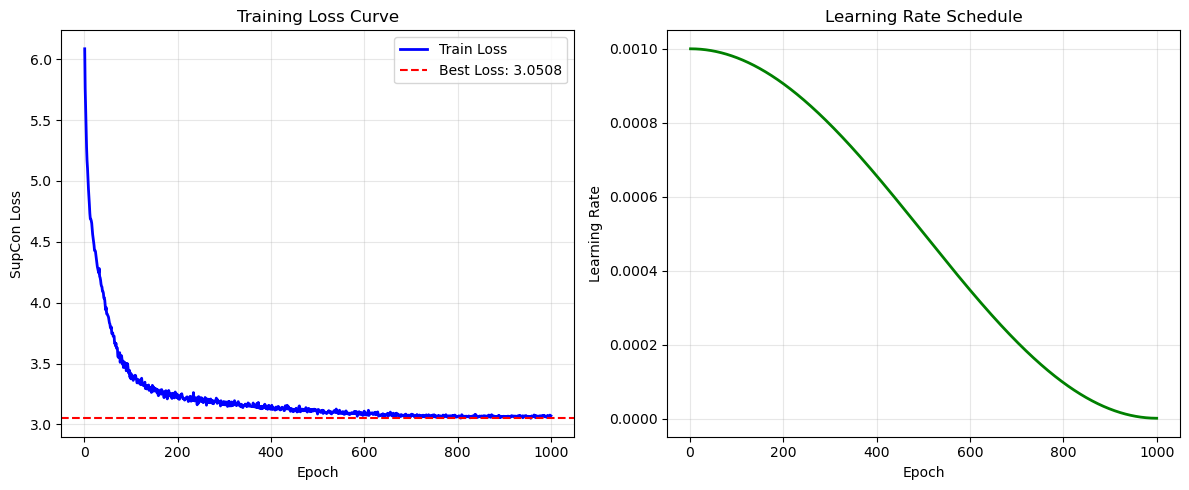

Training curves saved to ./supcon_output/training_curves.png


In [24]:
# Plot training curve
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2, label='Train Loss')
plt.axhline(y=best_loss, color='r', linestyle='--', label=f'Best Loss: {best_loss:.4f}')
plt.xlabel('Epoch')
plt.ylabel('SupCon Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate curve
plt.subplot(1, 2, 2)
log_df = training_logger.get_history()
if not log_df.empty and 'learning_rate' in log_df.columns:
    plt.plot(log_df['epoch'], log_df['learning_rate'], 'g-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curves saved to {OUTPUT_DIR}/training_curves.png")

---
## 10. Save Final Encoder

In [25]:
# Save the encoder weights (for downstream tasks)
encoder_path = f'{OUTPUT_DIR}/oct_encoder_supcon.pth'

# Load best model
best_checkpoint = checkpoint_manager.load_best_checkpoint()
if best_checkpoint:
    model.load_state_dict(best_checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {best_checkpoint['epoch'] + 1}")

# Save encoder only
torch.save(model.encoder.state_dict(), encoder_path)
print(f'\nOCT Encoder saved to: {encoder_path}')

# Save training configuration
config = {
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'temperature': TEMPERATURE,
    'embedding_dim': EMBEDDING_DIM,
    'image_size': IMAGE_SIZE,
    'selected_biomarkers': SELECTED_BIOMARKERS,
    'num_labels': len(label_to_idx),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'best_loss': best_loss,
    'training_completed': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'seed': SEED
}

with open(f'{OUTPUT_DIR}/training_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f'Training configuration saved to: {OUTPUT_DIR}/training_config.json')
print('\nConfiguration:')
print(json.dumps(config, indent=2))

Loading best model checkpoint...
Loaded best model from epoch 958

OCT Encoder saved to: ./supcon_output/oct_encoder_supcon.pth
Training configuration saved to: ./supcon_output/training_config.json

Configuration:
{
  "batch_size": 256,
  "num_epochs": 1000,
  "learning_rate": 0.001,
  "weight_decay": 0.0001,
  "temperature": 0.07,
  "embedding_dim": 256,
  "image_size": 224,
  "selected_biomarkers": [
    "IR HRF",
    "Fully attached vitreous face",
    "Vitreous debris",
    "Partially attached vitreous face",
    "Fluid (IRF)",
    "DRT/ME"
  ],
  "num_labels": 48,
  "train_samples": 3136,
  "val_samples": 784,
  "best_loss": 3.050785700480143,
  "training_completed": "2025-12-16 02:47:44",
  "seed": 42
}


---
## 11. Utility Functions for Loading Pretrained Encoder

In [26]:
def load_pretrained_encoder(checkpoint_path, embedding_dim=256, device='cpu'):
    """
    Load the pretrained OCT encoder for downstream tasks.
    
    Args:
        checkpoint_path: Path to the saved encoder weights
        embedding_dim: Dimension of the embedding (must match training)
        device: Device to load the model on
    
    Returns:
        encoder: Loaded and ready-to-use encoder
    """
    encoder = OCTEncoder(embedding_dim=embedding_dim, pretrained=False)
    encoder.load_state_dict(torch.load(checkpoint_path, map_location=device))
    encoder.to(device)
    encoder.eval()
    return encoder


def extract_visit_embedding(encoder, oct_folder_path, transform, device='cpu'):
    """
    Extract embedding for a single visit (aggregating all B-scans).
    
    Args:
        encoder: Pretrained encoder
        oct_folder_path: Path to the OCT folder containing B-scans
        transform: Image preprocessing transform
        device: Device to use
    
    Returns:
        visit_embedding: [embedding_dim] averaged embedding
    """
    embeddings = []
    
    for scan_num in range(49):  # 0 to 48
        img_path = os.path.join(oct_folder_path, f'{scan_num}.tif')
        
        if not os.path.exists(img_path):
            continue
            
        try:
            image = Image.open(img_path).convert('RGB')
            image = transform(image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                emb = encoder(image).squeeze(0).cpu().numpy()
            embeddings.append(emb)
        except Exception as e:
            print(f'Warning: Failed to process {img_path}: {e}')
            continue
    
    if len(embeddings) == 0:
        return np.zeros(encoder.embedding_dim)
    
    embeddings = np.stack(embeddings)
    return embeddings.mean(axis=0)


print('Utility functions defined!')
print()
print('Usage example:')
print('```python')
print("encoder = load_pretrained_encoder('supcon_output/oct_encoder_supcon.pth', device='cuda')")
print("embedding = extract_visit_embedding(encoder, 'Prime_FULL/02-010/W0/OD', val_transform)")
print('print(embedding.shape)  # (256,)')
print('```')

Utility functions defined!

Usage example:
```python
encoder = load_pretrained_encoder('supcon_output/oct_encoder_supcon.pth', device='cuda')
embedding = extract_visit_embedding(encoder, 'Prime_FULL/02-010/W0/OD', val_transform)
print(embedding.shape)  # (256,)
```


---
## Summary

### Key Files Generated:
1. `supcon_output/checkpoints/` - Periodic checkpoints for resuming
2. `supcon_output/checkpoints/best_model.pth` - Best model checkpoint
3. `supcon_output/oct_encoder_supcon.pth` - Final encoder weights
4. `supcon_output/training_config.json` - Training configuration
5. `supcon_output/training_log.csv` - Training metrics log
6. `supcon_output/training_curves.png` - Training visualization

### To Resume Training:
1. Set `RESUME_TRAINING = True`
2. Run all cells - training will automatically resume from the latest checkpoint

### Next Steps:
1. Use `load_pretrained_encoder()` to load the trained encoder
2. Apply to all visits for OCT embedding extraction
3. Proceed to multi-modal feature fusion for BCVA prediction